In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/seonahryu/Desktop/urp/combined_data.csv", index_col='date')

-1~1 정규화

In [2]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
features_to_scale = ['past_day_close', 'Open', 'High', 'Low', 'Volume', 'Adj Close'] # nasdaq 지수만 정규화

scaler = MinMaxScaler(feature_range=(-1,1))
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print(df.head(10))

            vader_sentiment  roberta_sentiment  past_day_close      Open  \
date                                                                       
2009-05-05           0.7712                  0       -0.989263 -0.990806   
2009-05-08           0.6468                  1       -0.994376 -0.993383   
2009-05-12           0.0000                 -1       -0.992755 -0.992368   
2009-05-12           0.3235                  0       -0.992755 -0.992368   
2009-05-13           0.7506                  0       -0.994410 -0.997363   
2009-05-14           0.0000                  1       -1.000000 -1.000000   
2009-05-15           0.3612                  0       -0.997297 -0.998372   
2009-05-19           0.0000                  0       -0.992634 -0.994088   
2009-05-20           0.0000                  1       -0.992399 -0.992287   
2009-05-21           0.6249                  1       -0.993123 -0.995950   

                High       Low    Volume  Adj Close  
date                             

sentiment 범위 확인

In [3]:
# 최대값과 최소값 계산
vader_max = df['vader_sentiment'].max()
vader_min = df['vader_sentiment'].min()
roberta_max = df['roberta_sentiment'].max()
roberta_min = df['roberta_sentiment'].min()

# 결과 출력
print(f"VADER Sentiment - 최대값: {vader_max}, 최소값: {vader_min}")
print(f"Roberta Sentiment - 최대값: {roberta_max}, 최소값: {roberta_min}")

VADER Sentiment - 최대값: 0.9961, 최소값: -0.9963
Roberta Sentiment - 최대값: 1, 최소값: -1


In [4]:
# VADER Sentiment 정규화
min_vader = vader_min
max_vader = vader_max

# 정규화: -1에서 1 사이로 변환
df['vader_sentiment'] = 2 * ((df['vader_sentiment'] - min_vader) / (max_vader - min_vader)) - 1

# LSTM

In [5]:
import numpy as np

# 데이터셋 생성 함수 정의
def create_dataset(X, y, time_step=30):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# 예측 및 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    return mse, rmse, r_squared

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# LSTM 모델 정의
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input 레이어 추가
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='tanh'))  # -1~1 정규화해서 출력층 tanh 함수
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

input : VADER

In [8]:
from sklearn.model_selection import train_test_split

vader = ['vader_sentiment']

X, y = create_dataset(df[vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [9]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 32, MSE: 1.026, RMSE: 1.013, R-squared: -16.013
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 64, MSE: 0.898, RMSE: 0.948, R-squared: -13.887
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 128, MSE: 0.921, RMSE: 0.960, R-squared: -14.269
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 256, MSE: 0.979, RMSE: 0.989, R-squared: -15.229
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Batch Size: 512, MSE: 1.023, RMSE: 1.012, R-squared: -15.968
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 1024, MSE: 0.976, RMSE: 0.988, R-squared: -15.188


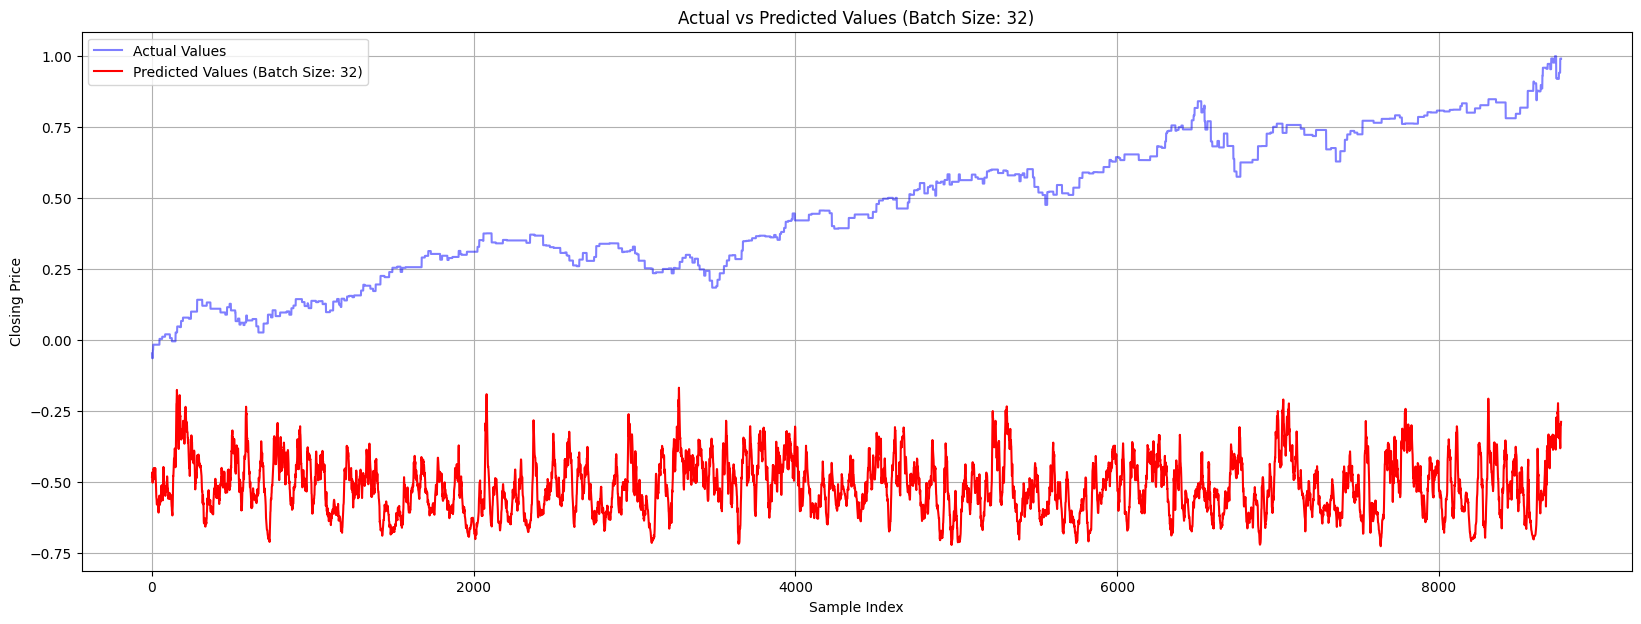

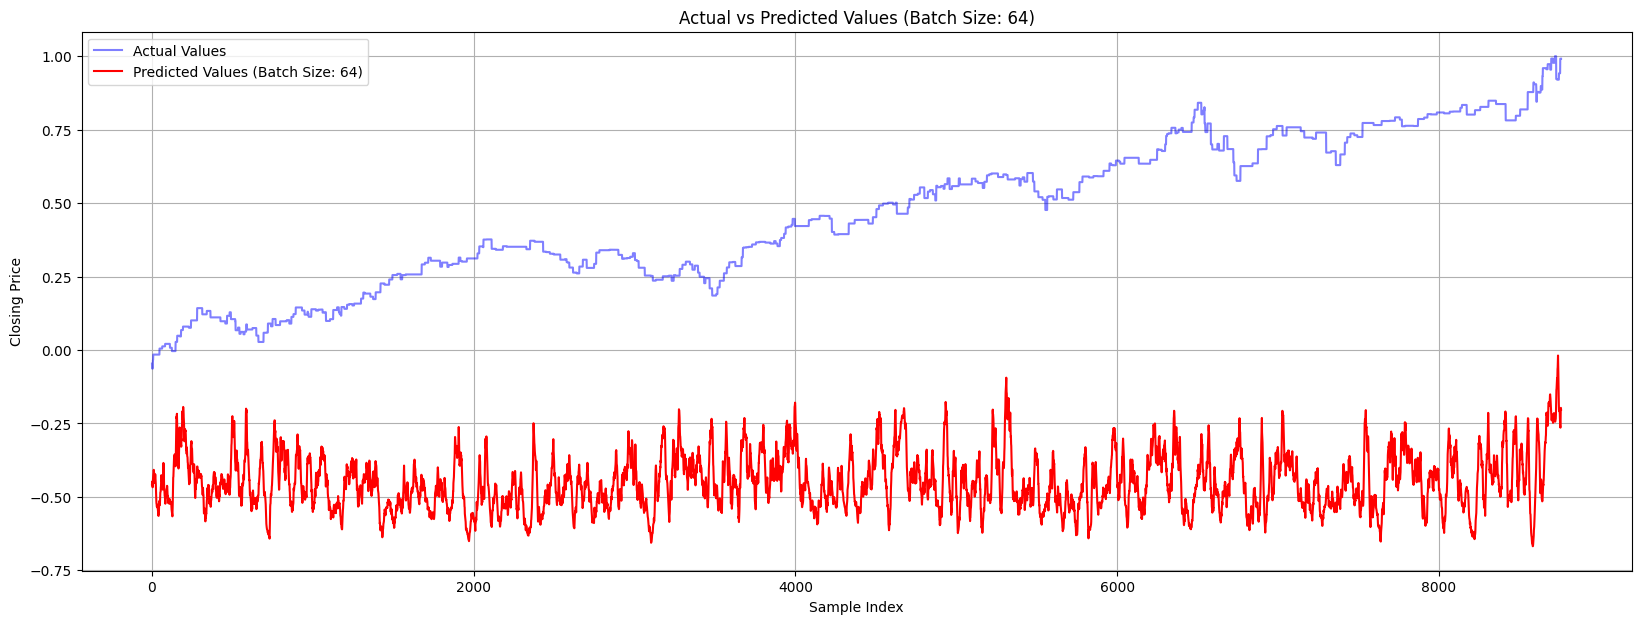

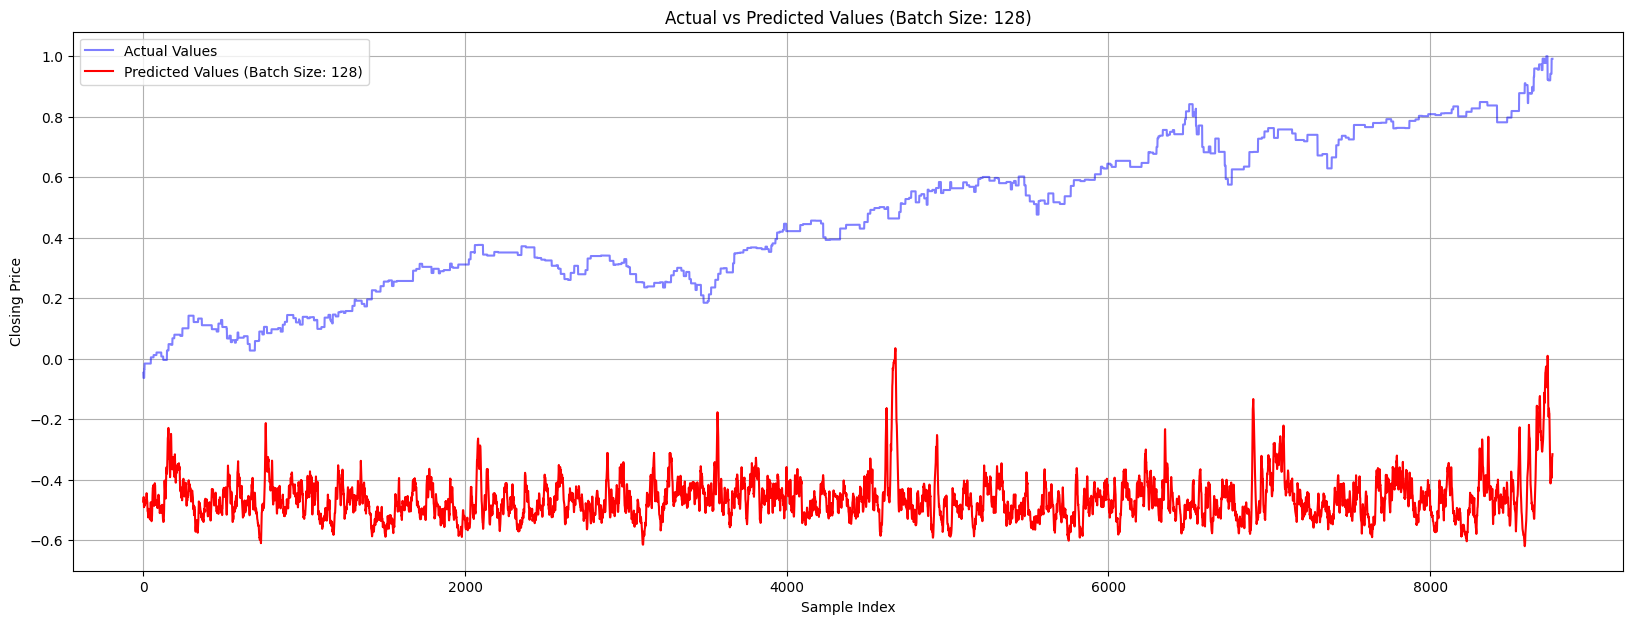

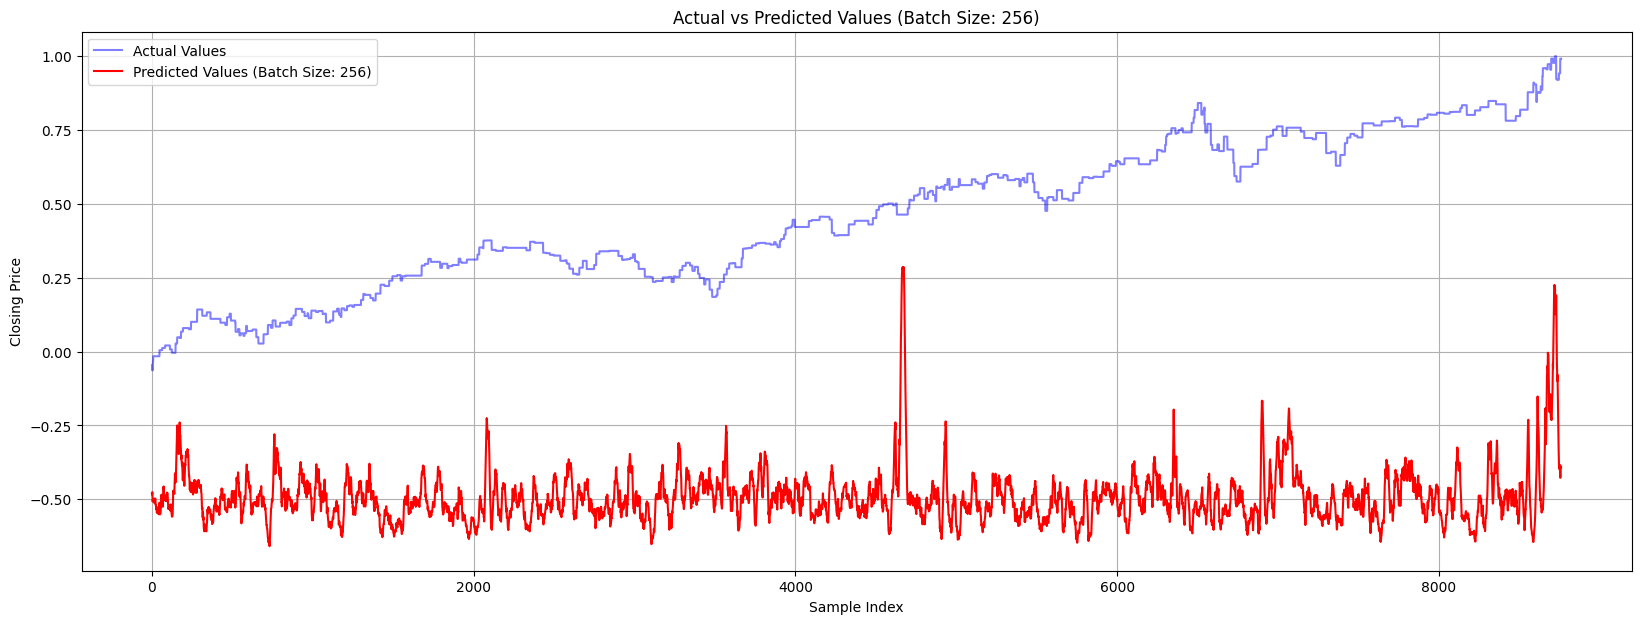

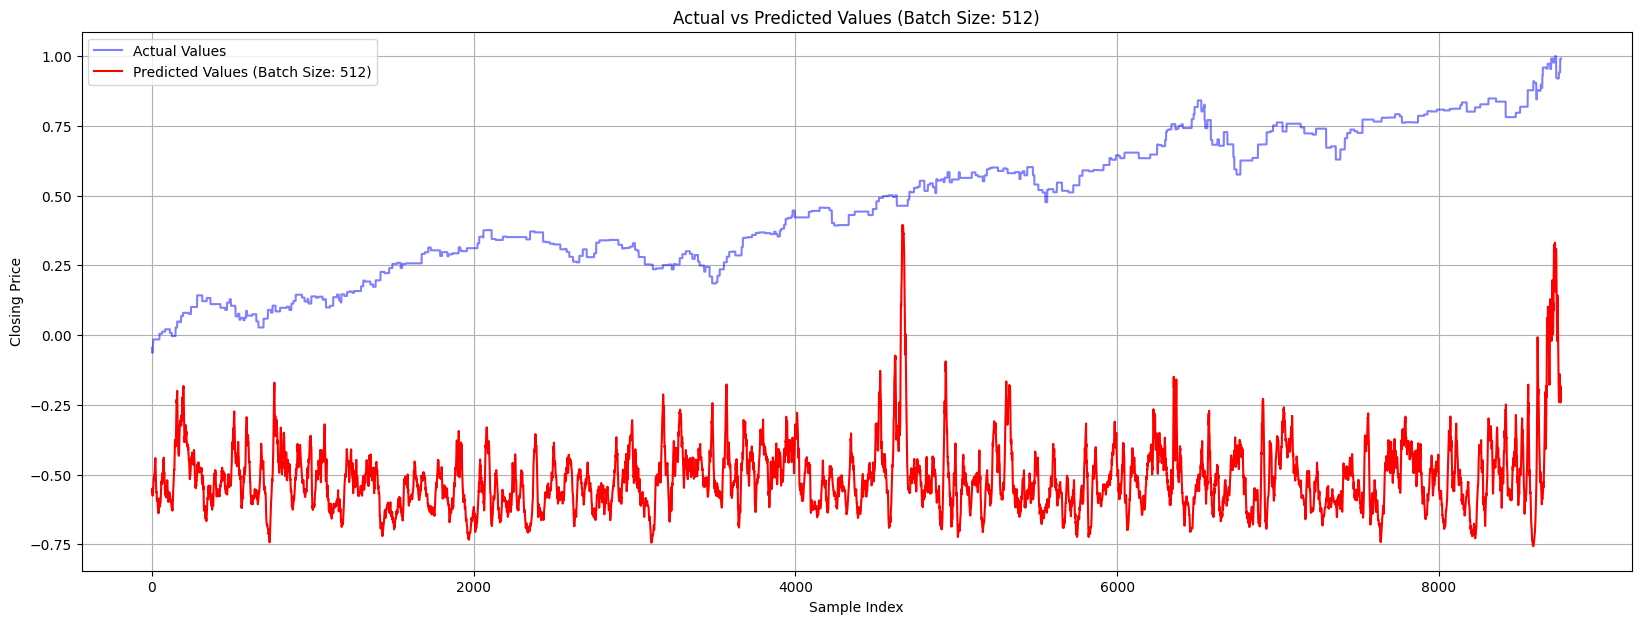

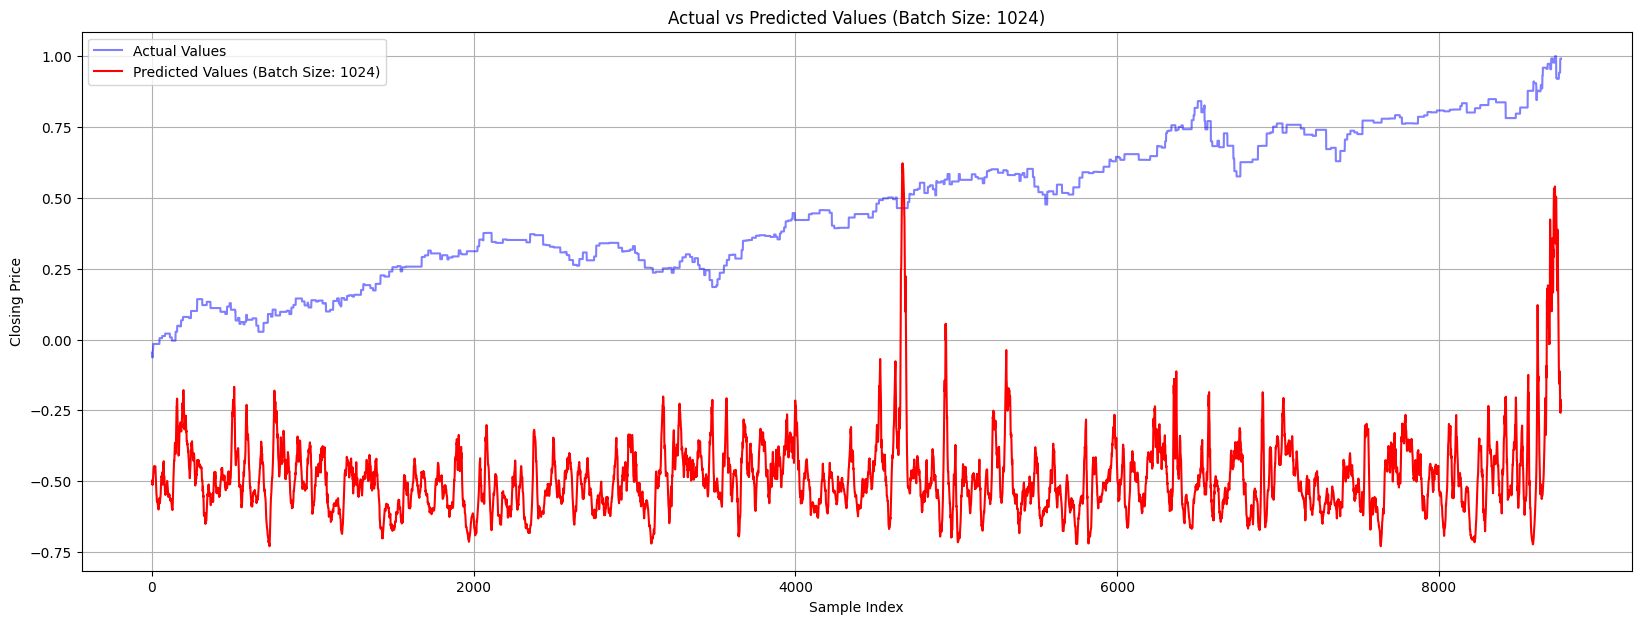

In [10]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

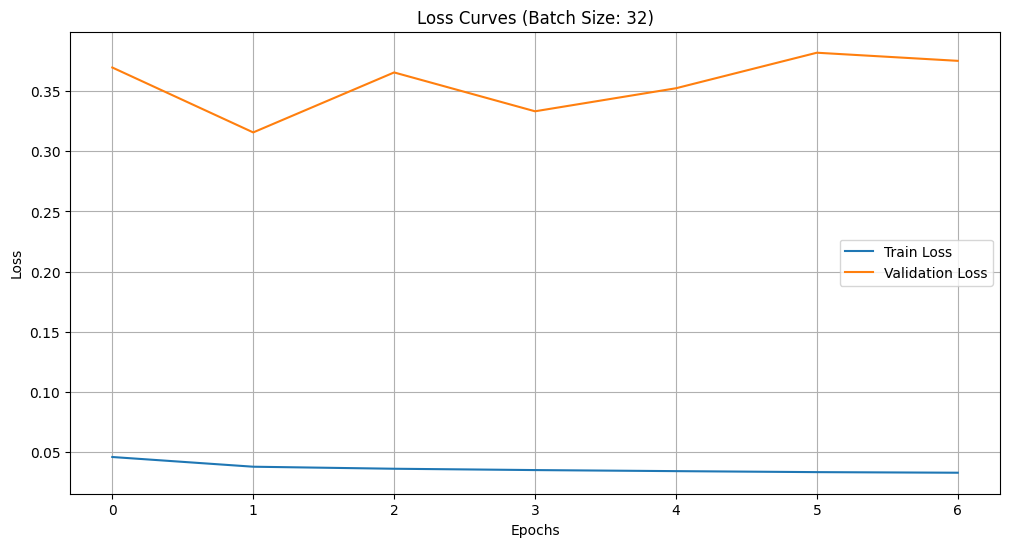

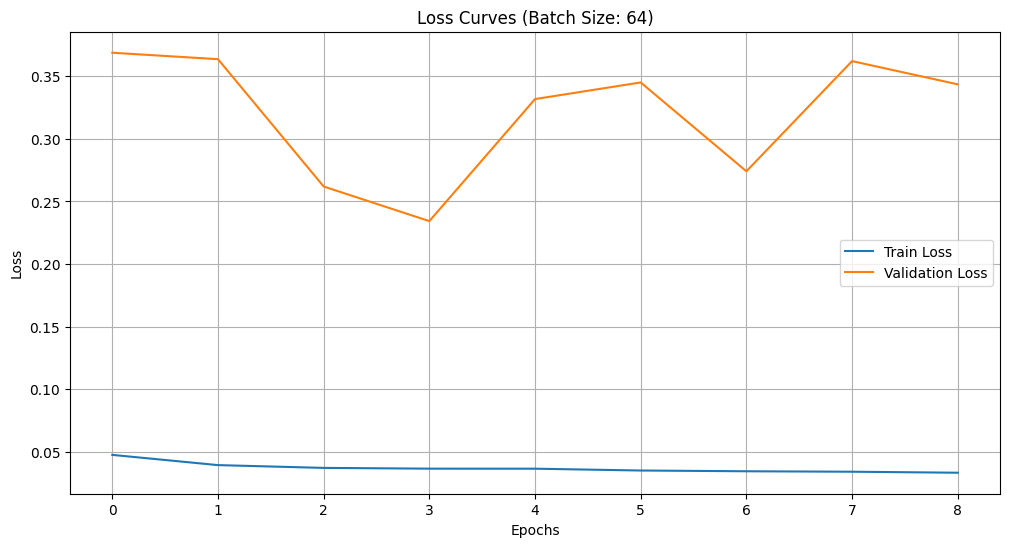

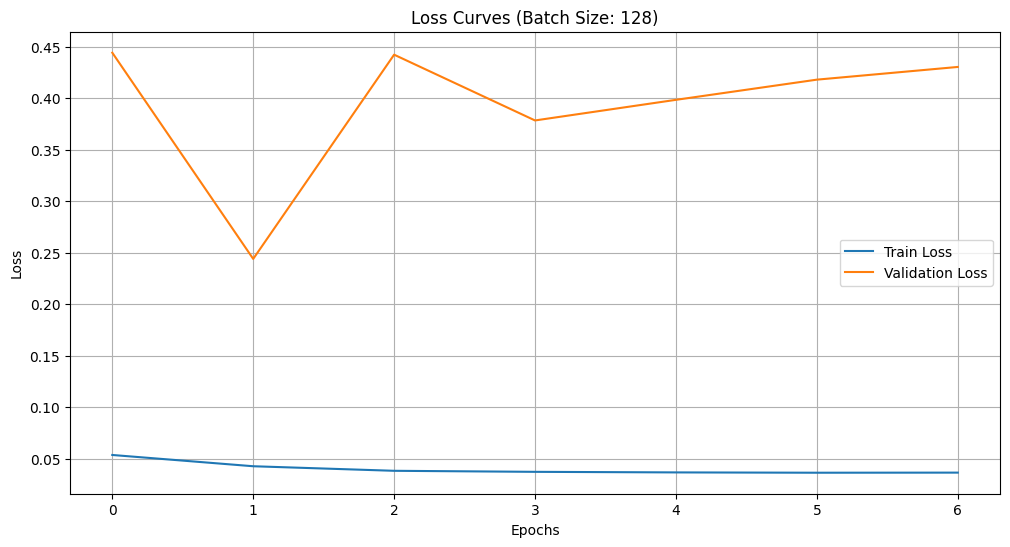

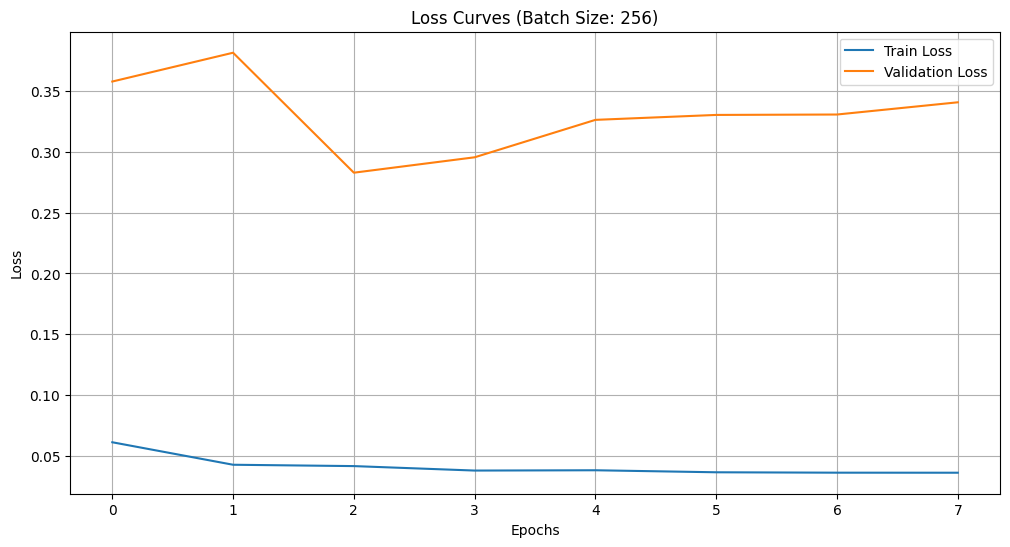

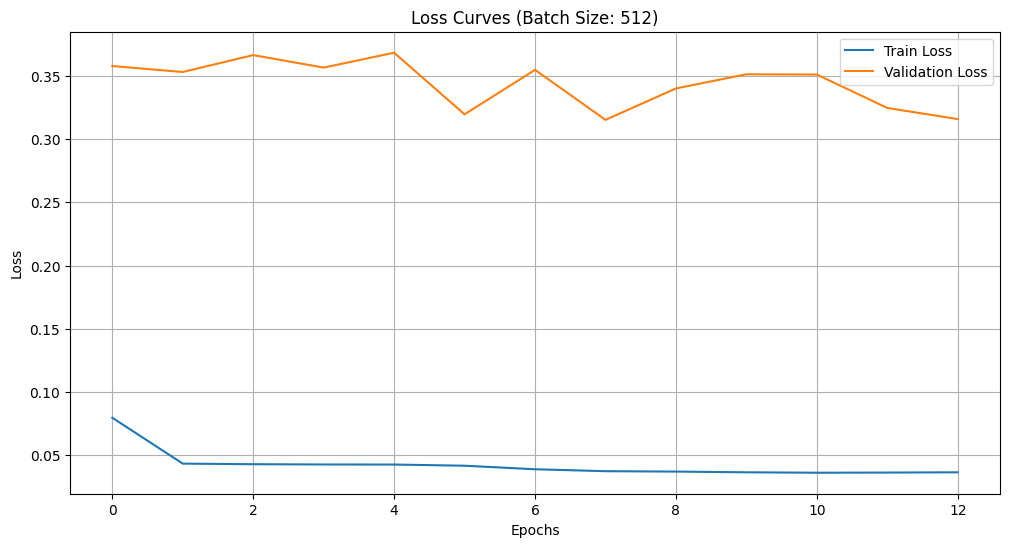

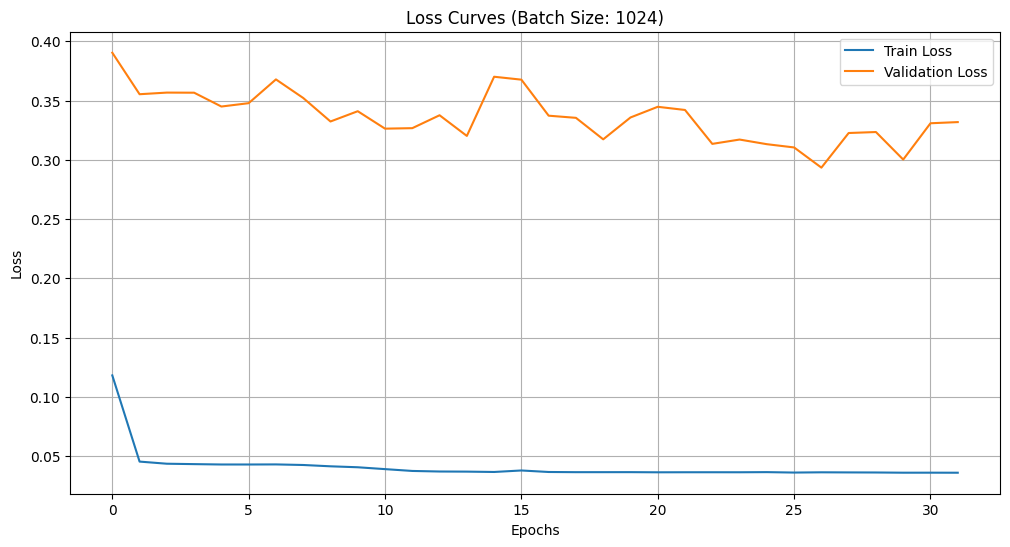

In [11]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : RoBERTa

In [12]:
from sklearn.model_selection import train_test_split

roberta = ['roberta_sentiment']

X, y = create_dataset(df[roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [13]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 32, MSE: 1.124, RMSE: 1.060, R-squared: -17.631
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 64, MSE: 1.118, RMSE: 1.057, R-squared: -17.532
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 128, MSE: 1.110, RMSE: 1.054, R-squared: -17.414
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 256, MSE: 1.091, RMSE: 1.045, R-squared: -17.097
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Batch Size: 512, MSE: 1.135, RMSE: 1.065, R-squared: -17.820
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 1024, MSE: 1.134, RMSE: 1.065, R-squared: -17.796


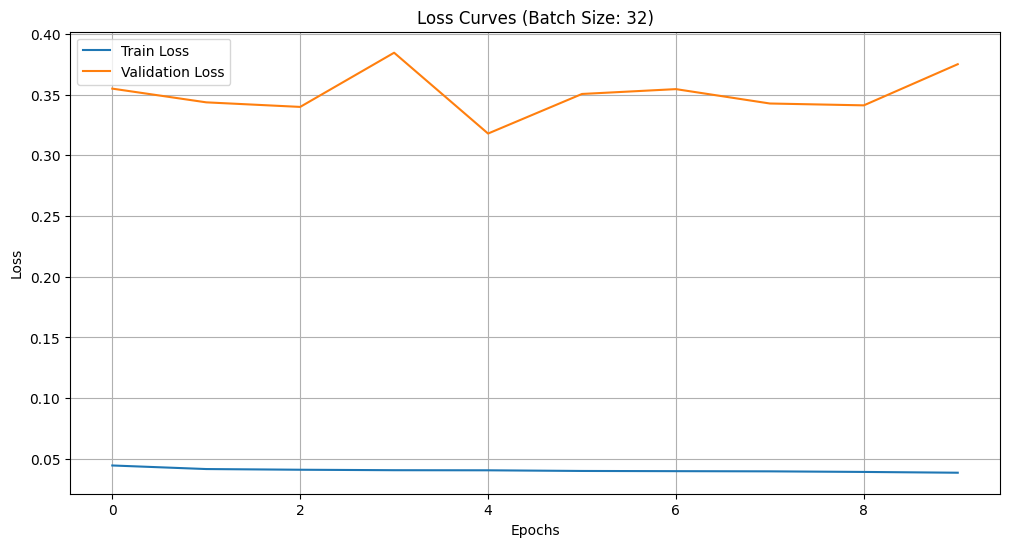

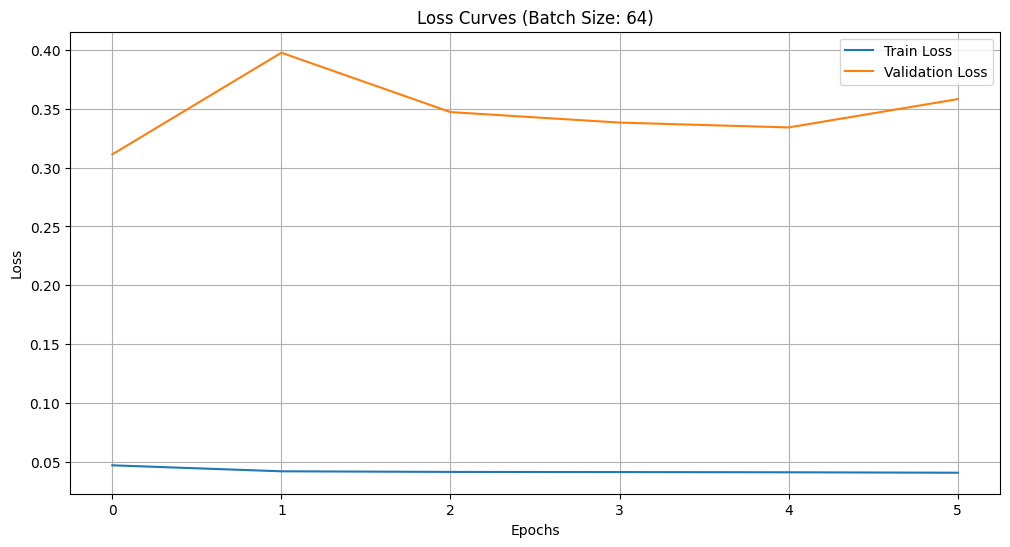

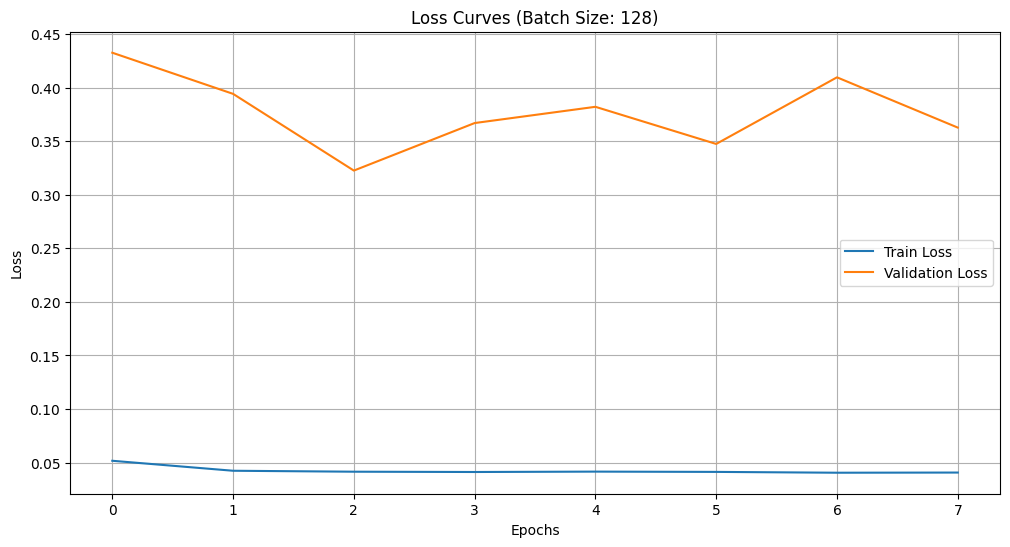

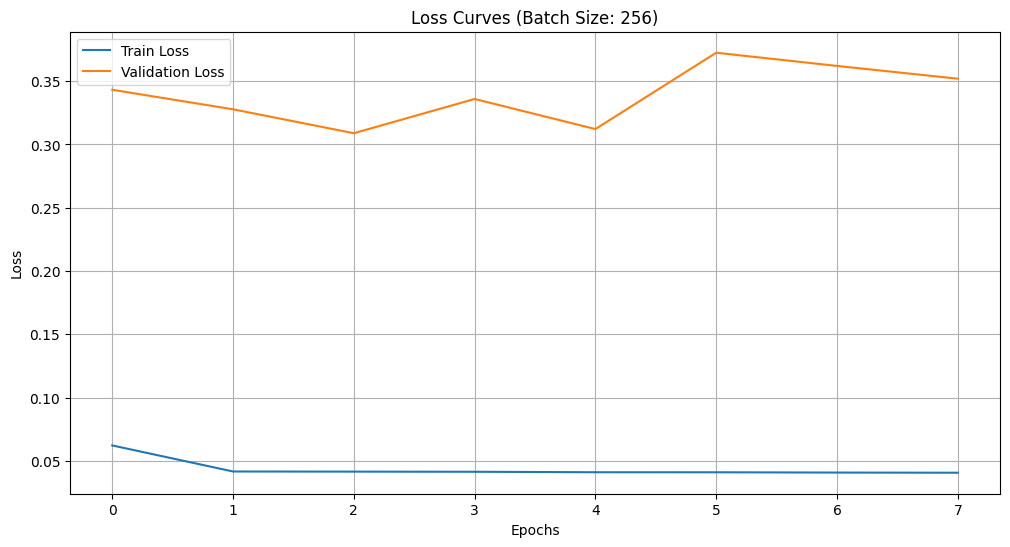

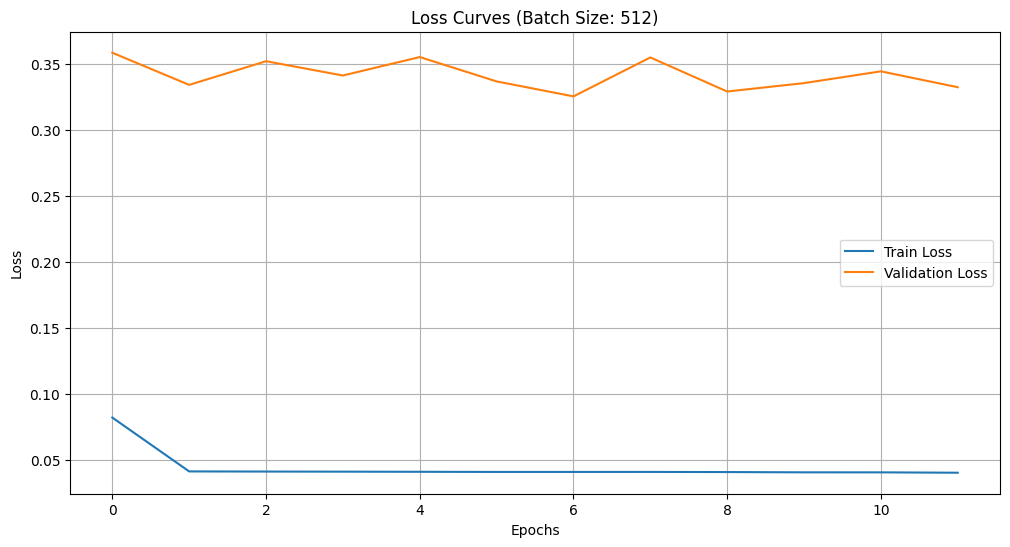

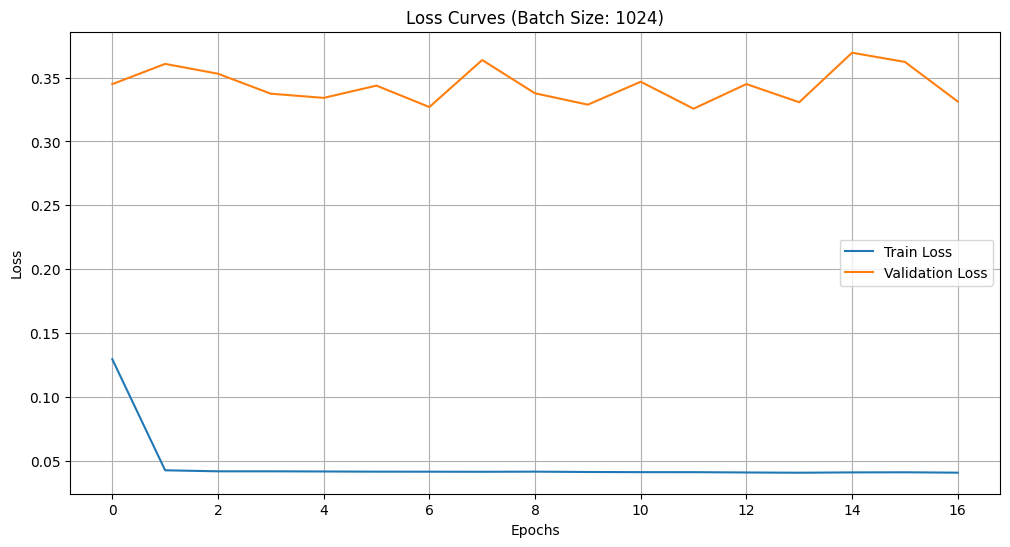

In [15]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : VADER + RoBERTa

In [16]:
from sklearn.model_selection import train_test_split

sentiment = ['vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [17]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 32, MSE: 0.920, RMSE: 0.959, R-squared: -14.255
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 64, MSE: 0.942, RMSE: 0.971, R-squared: -14.624
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 128, MSE: 0.754, RMSE: 0.868, R-squared: -11.495
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 256, MSE: 0.927, RMSE: 0.963, R-squared: -14.363
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 512, MSE: 1.089, RMSE: 1.044, R-squared: -17.062
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 1024, MSE: 0.888, RMSE: 0.942, R-squared: -13.728


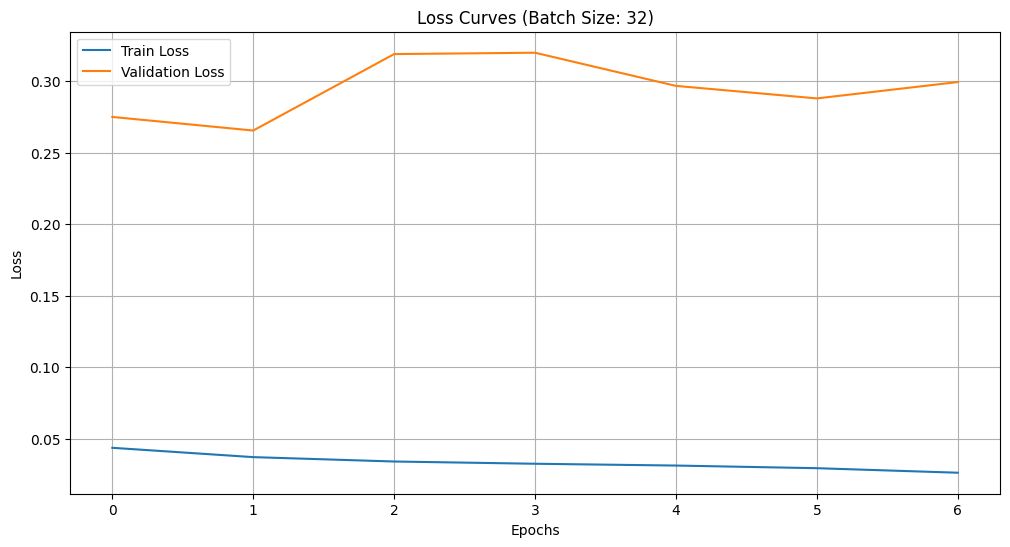

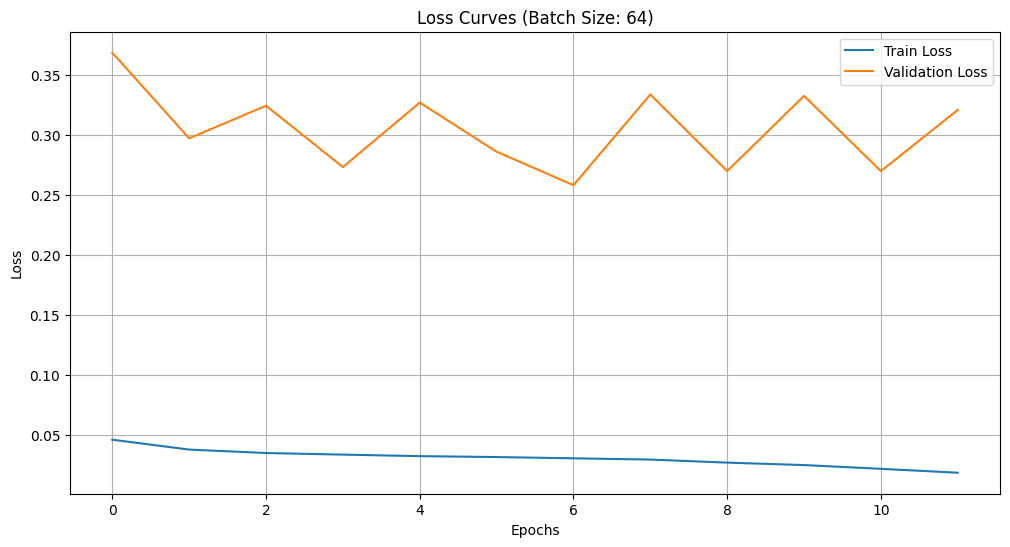

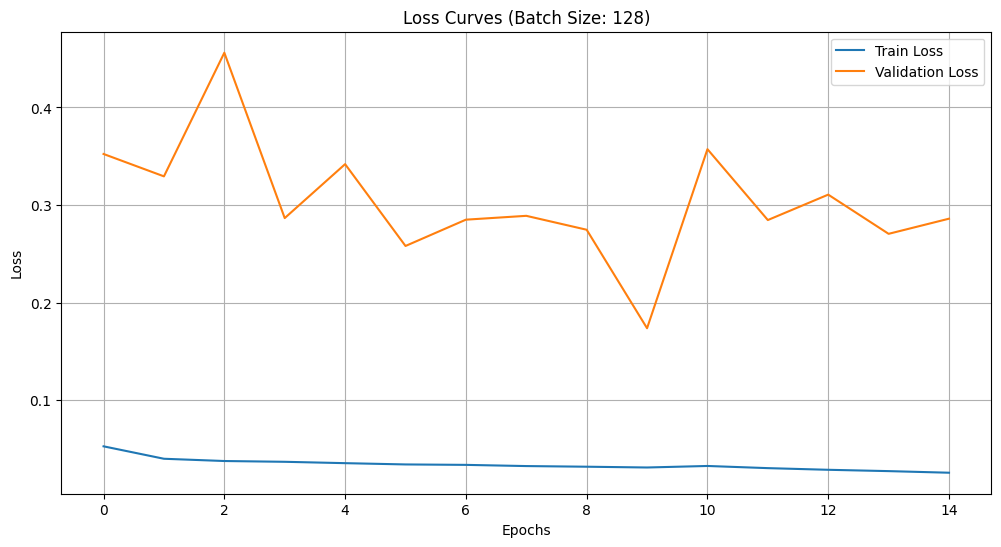

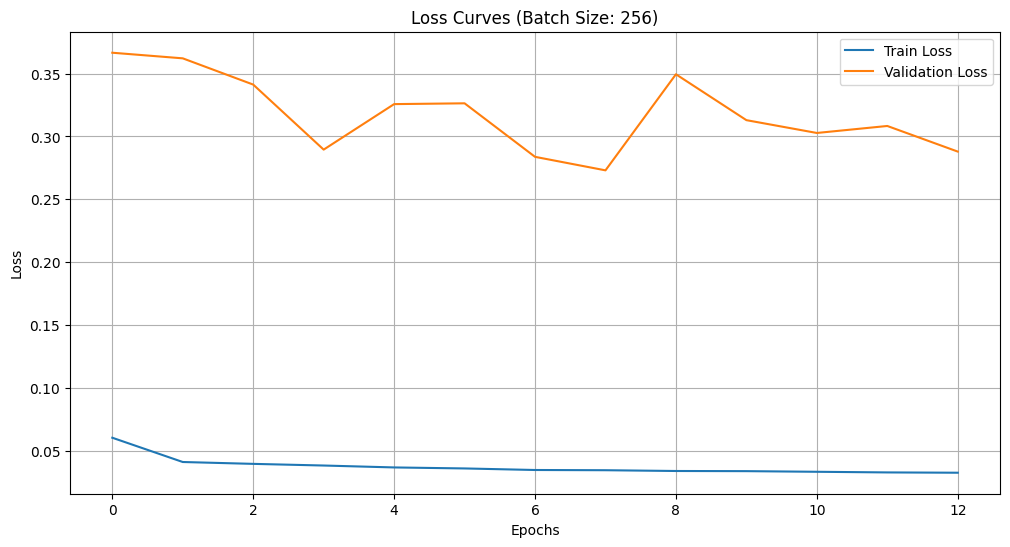

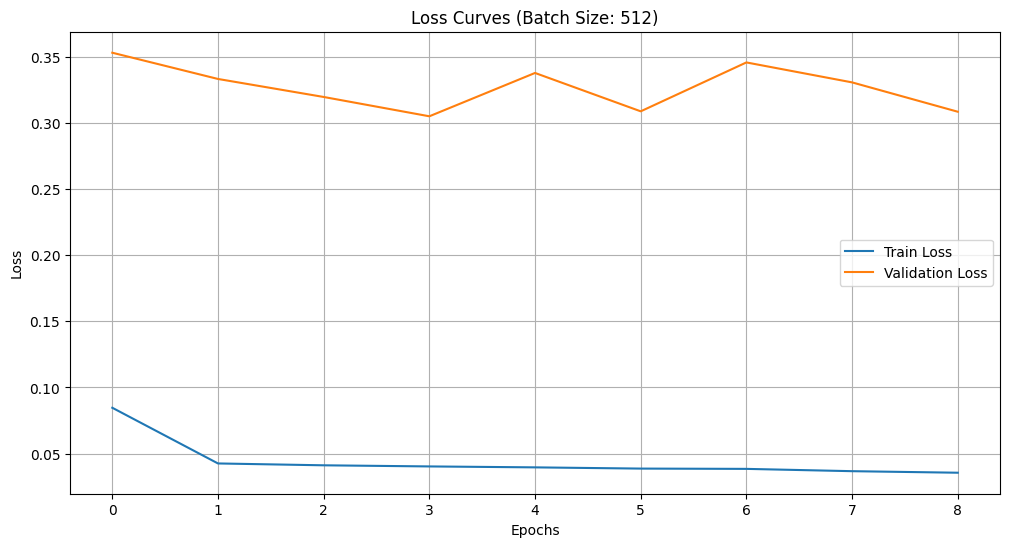

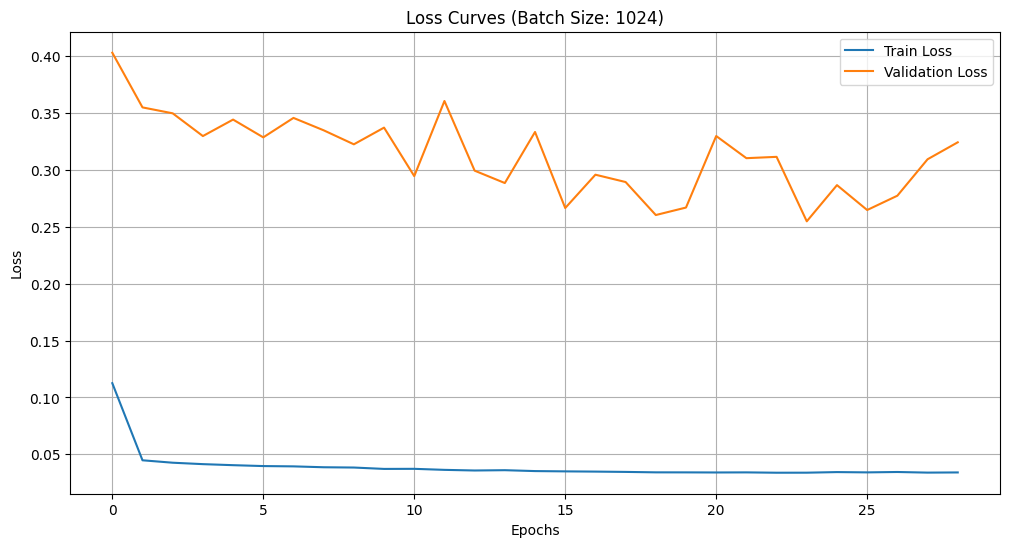

In [19]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close

In [20]:
from sklearn.model_selection import train_test_split

past_day_close = ['past_day_close']

X, y = create_dataset(df[past_day_close].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [21]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 32, MSE: 0.012, RMSE: 0.110, R-squared: 0.798
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 64, MSE: 0.015, RMSE: 0.122, R-squared: 0.752
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 128, MSE: 0.025, RMSE: 0.158, R-squared: 0.587
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 256, MSE: 0.025, RMSE: 0.158, R-squared: 0.584
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 512, MSE: 0.032, RMSE: 0.179, R-squared: 0.469
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 1024, MSE: 0.026, RMSE: 0.162, R-squared: 0.565


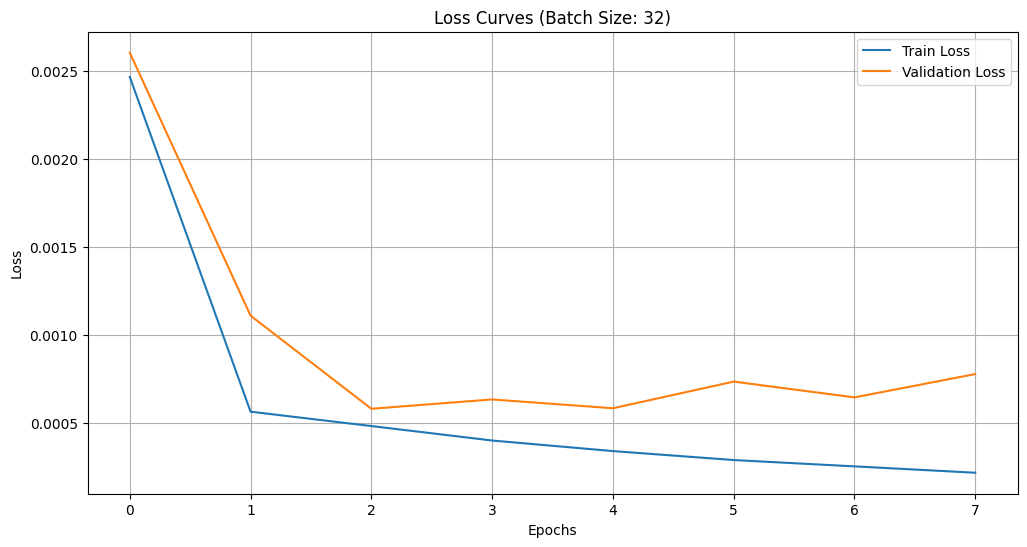

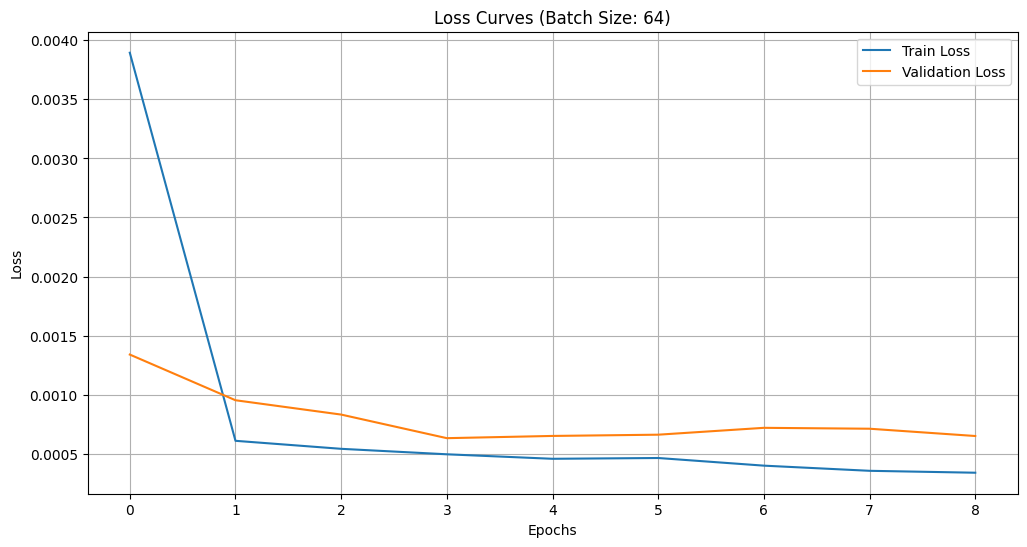

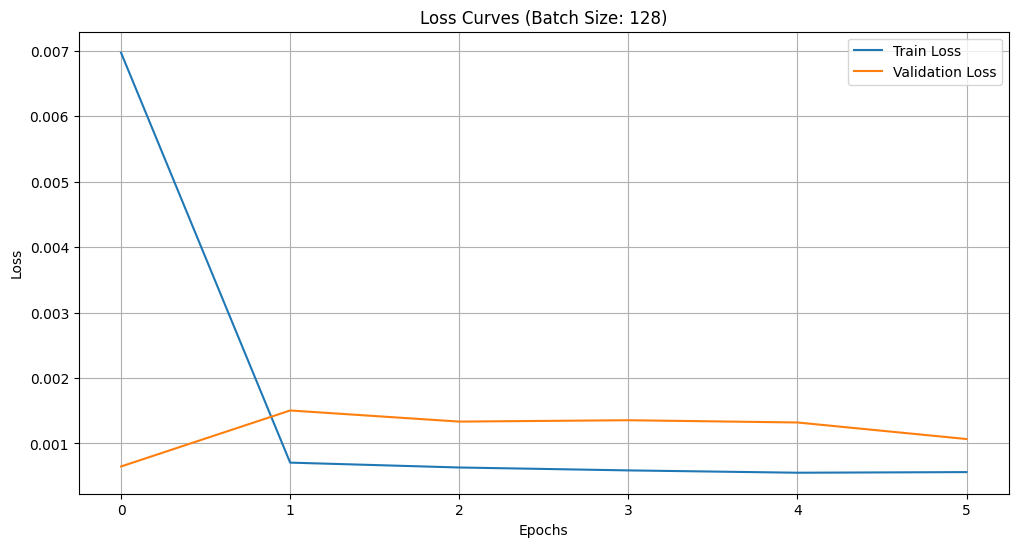

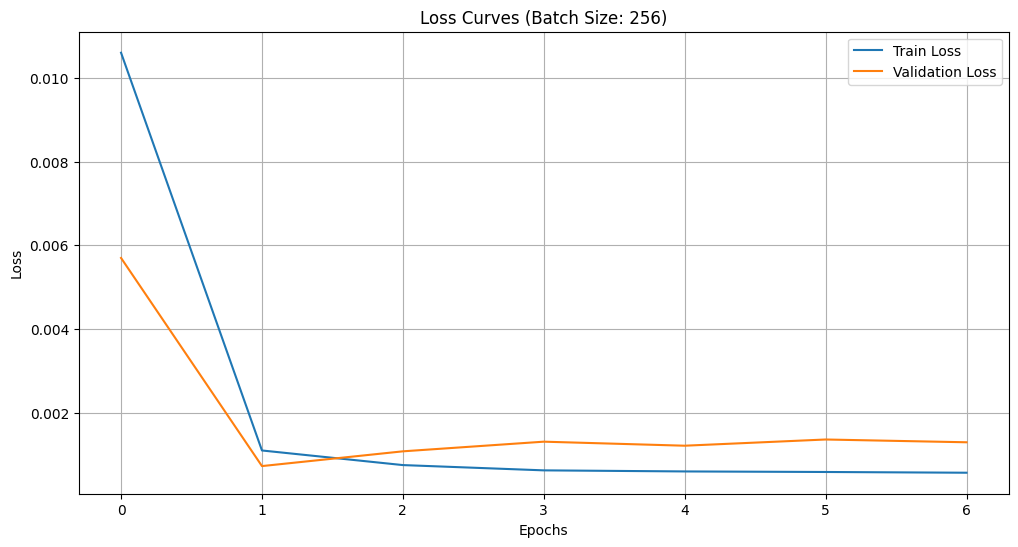

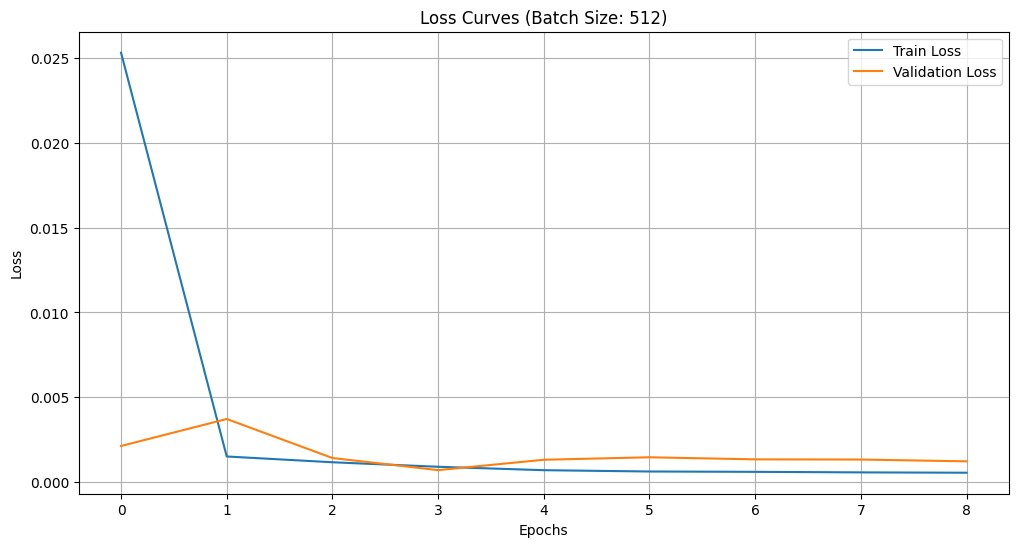

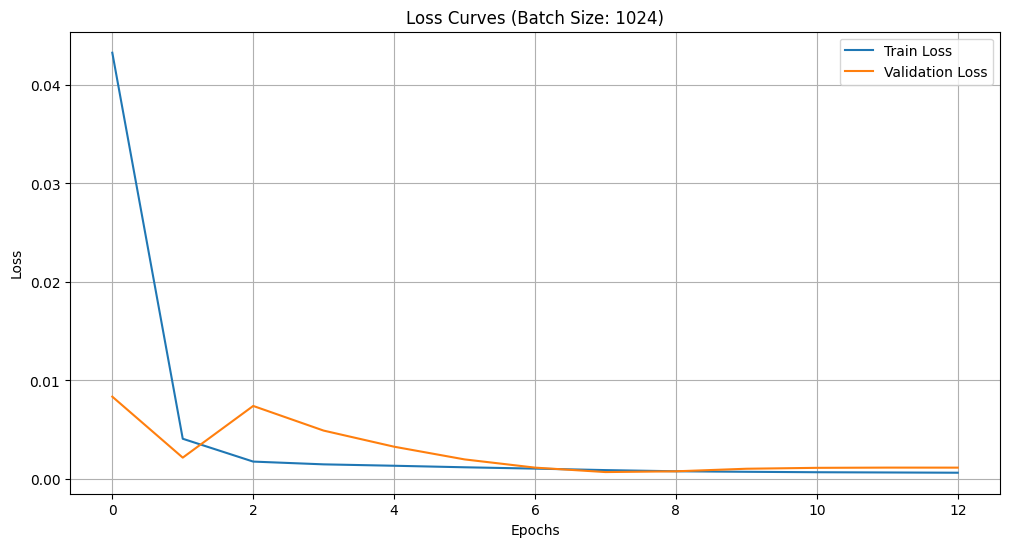

In [23]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + VADER

In [24]:
from sklearn.model_selection import train_test_split

past_vader = ['past_day_close', 'vader_sentiment']

X, y = create_dataset(df[past_vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [25]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 32, MSE: 0.016, RMSE: 0.128, R-squared: 0.728
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 64, MSE: 0.010, RMSE: 0.102, R-squared: 0.827
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 128, MSE: 0.033, RMSE: 0.182, R-squared: 0.450
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 256, MSE: 0.016, RMSE: 0.128, R-squared: 0.727
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 512, MSE: 0.031, RMSE: 0.177, R-squared: 0.480
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 1024, MSE: 0.034, RMSE: 0.185, R-squared: 0.434


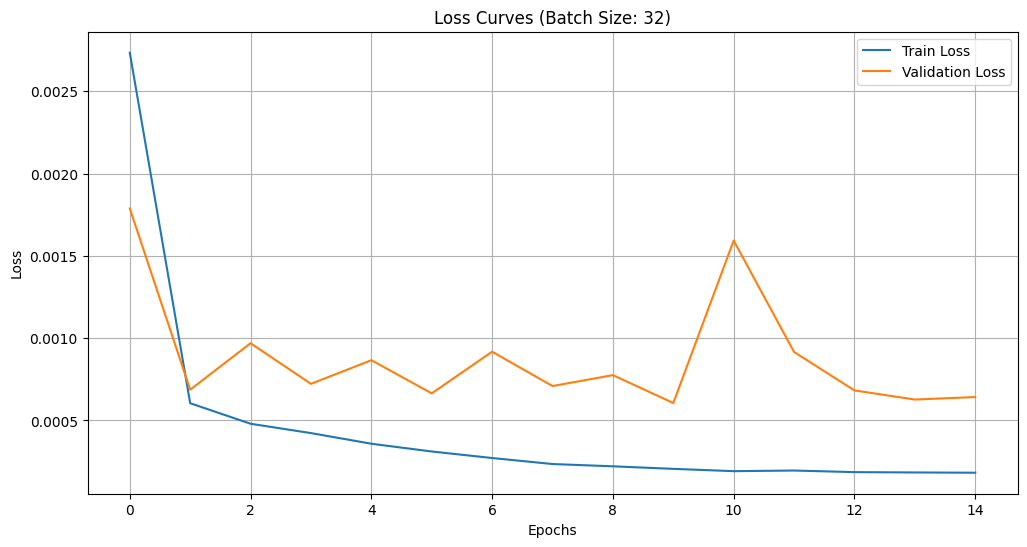

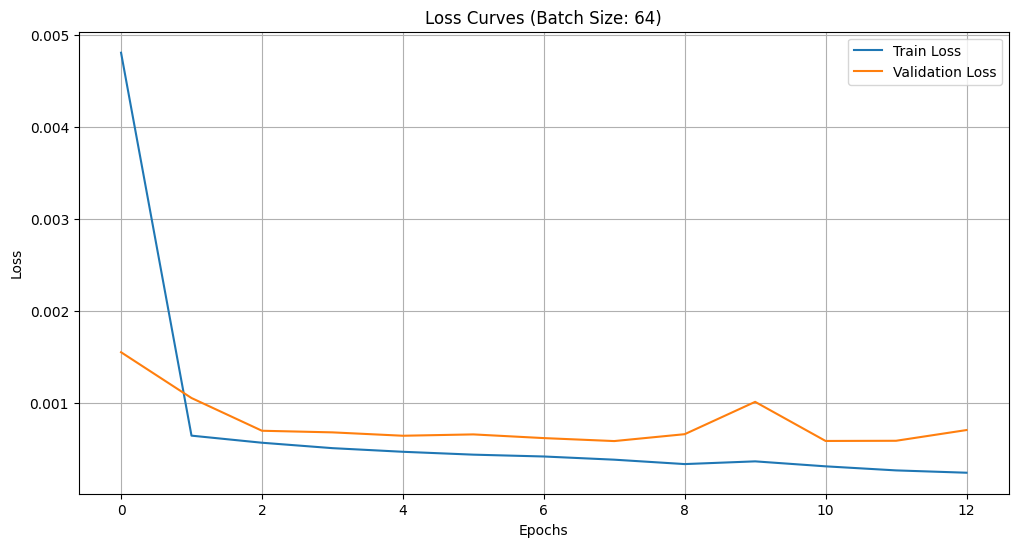

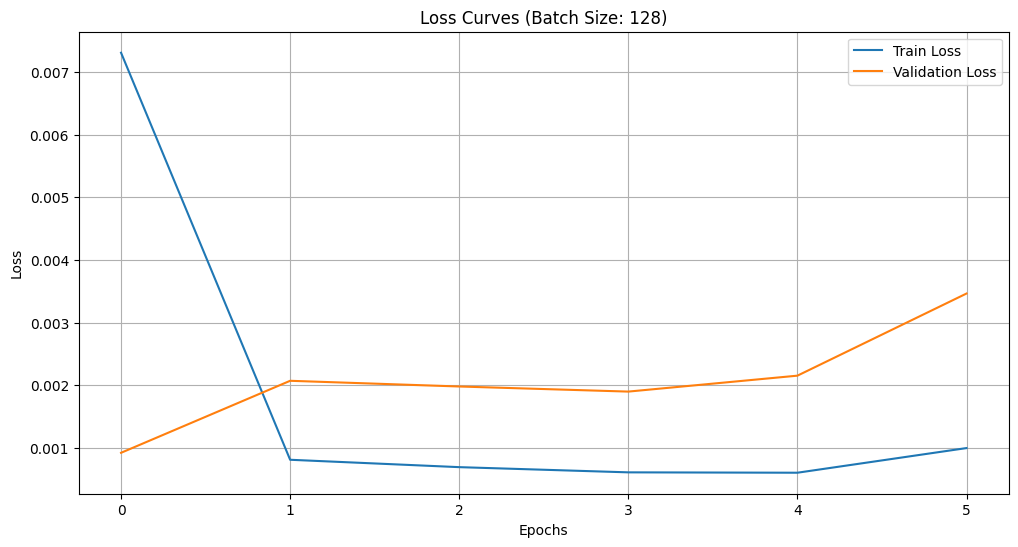

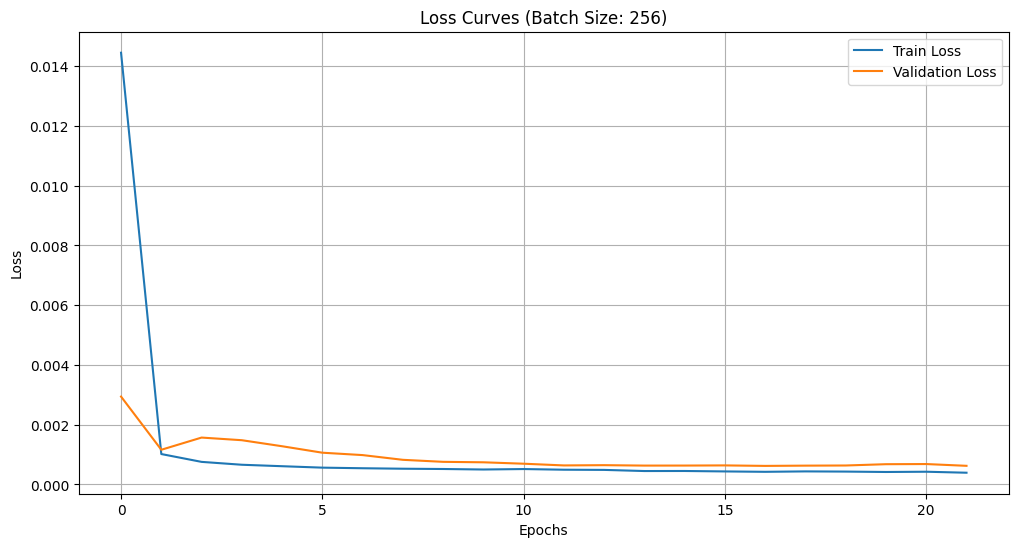

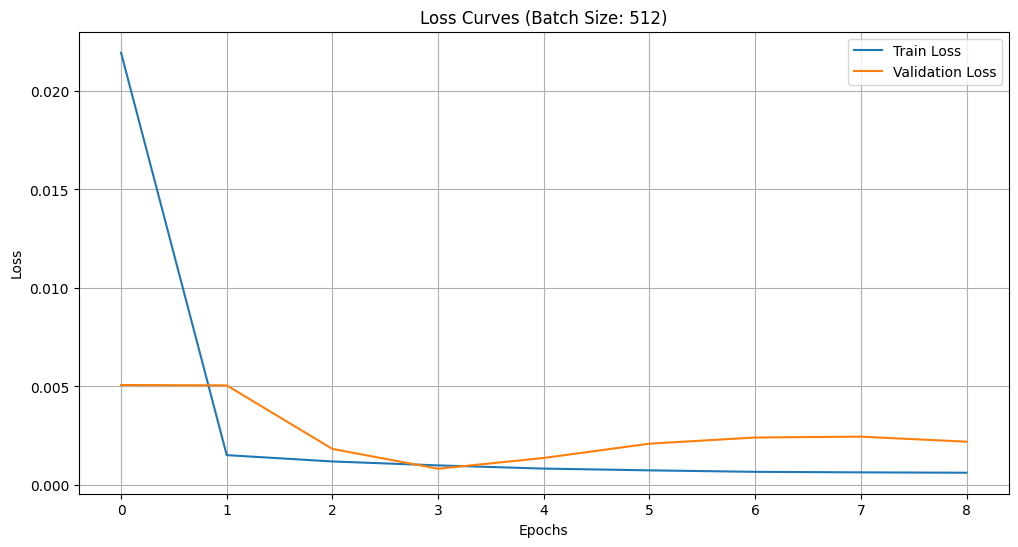

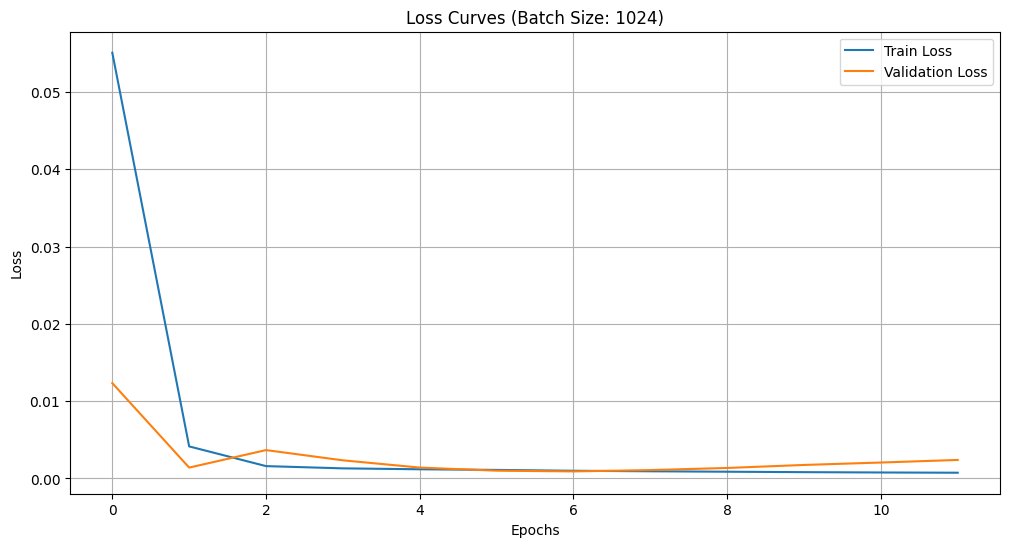

In [27]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + RoBERTa

In [28]:
from sklearn.model_selection import train_test_split

past_roberta = ['past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [29]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 32, MSE: 0.013, RMSE: 0.114, R-squared: 0.783
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 64, MSE: 0.011, RMSE: 0.107, R-squared: 0.811
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 128, MSE: 0.025, RMSE: 0.159, R-squared: 0.583
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 256, MSE: 0.026, RMSE: 0.163, R-squared: 0.562
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 512, MSE: 0.032, RMSE: 0.179, R-squared: 0.468
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 1024, MSE: 0.030, RMSE: 0.173, R-squared: 0.506


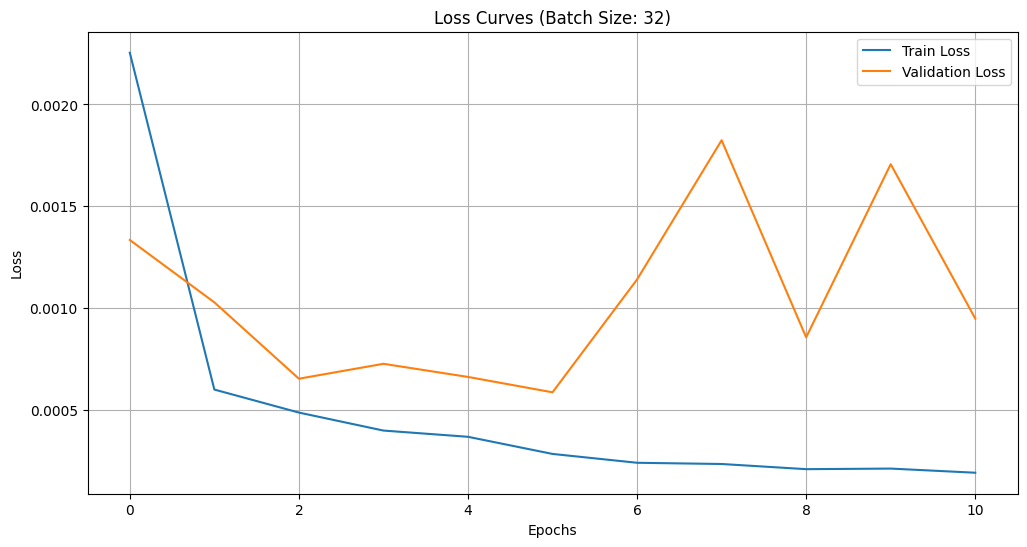

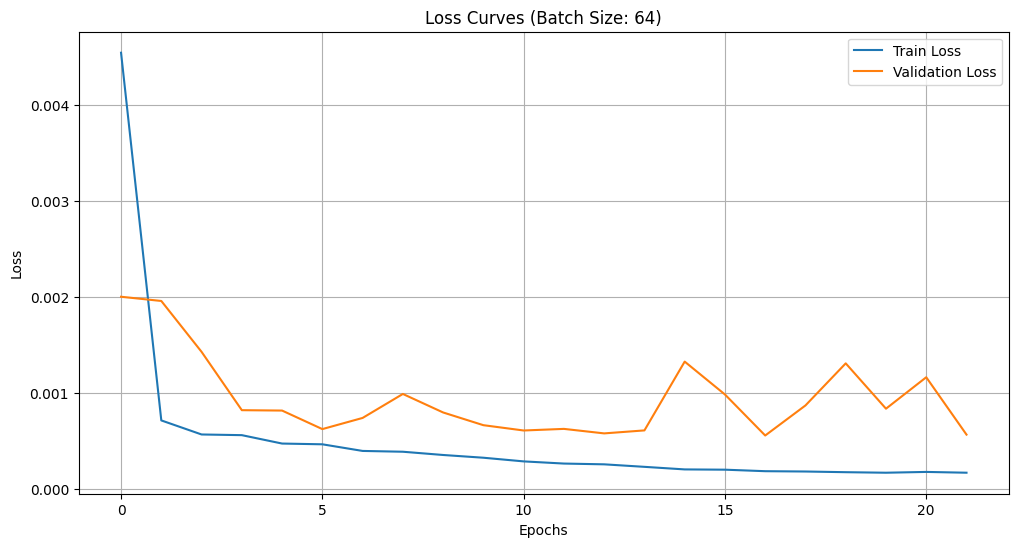

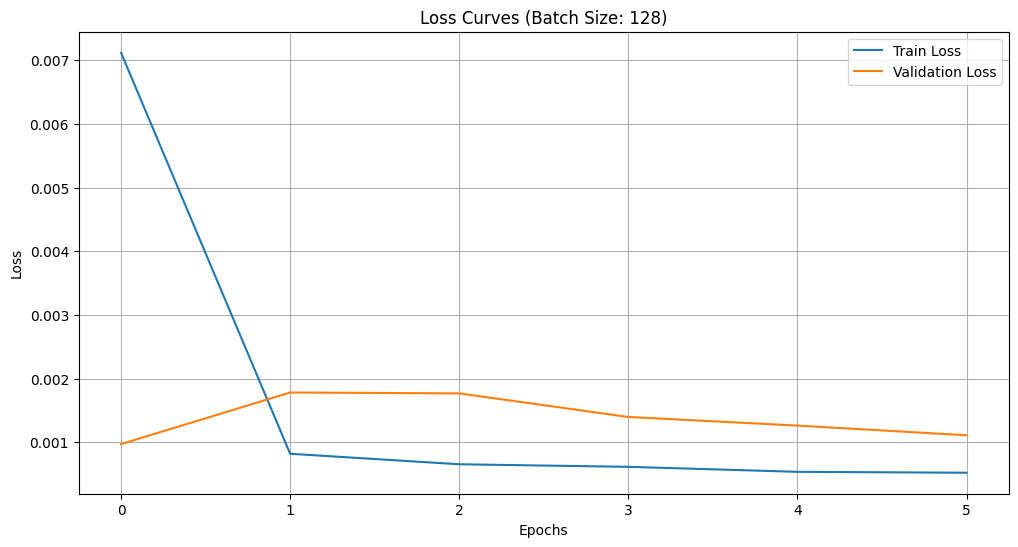

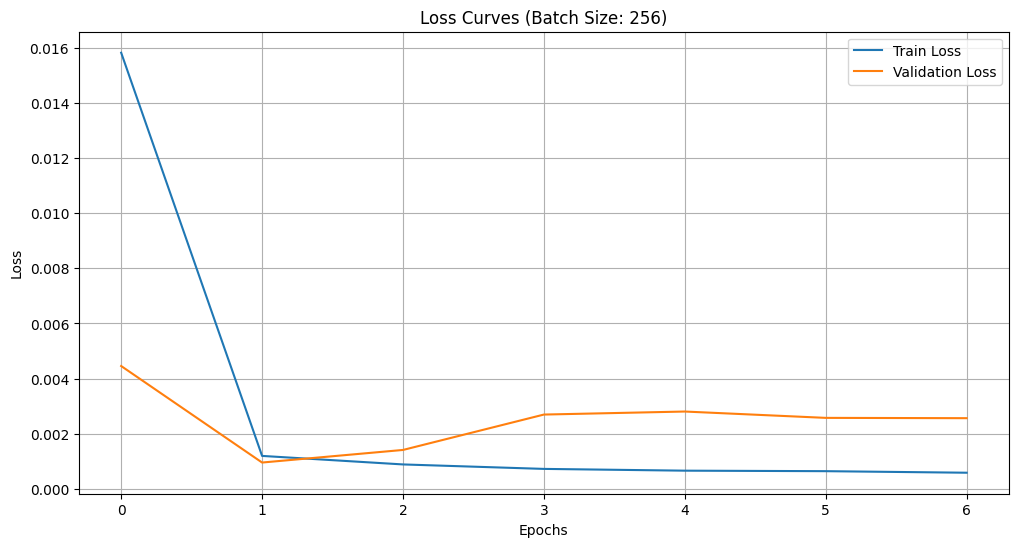

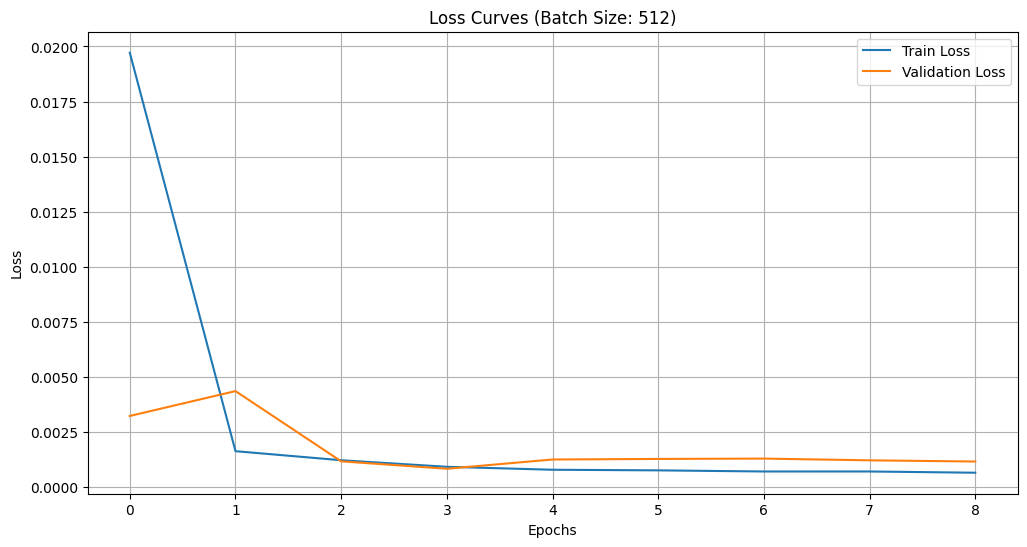

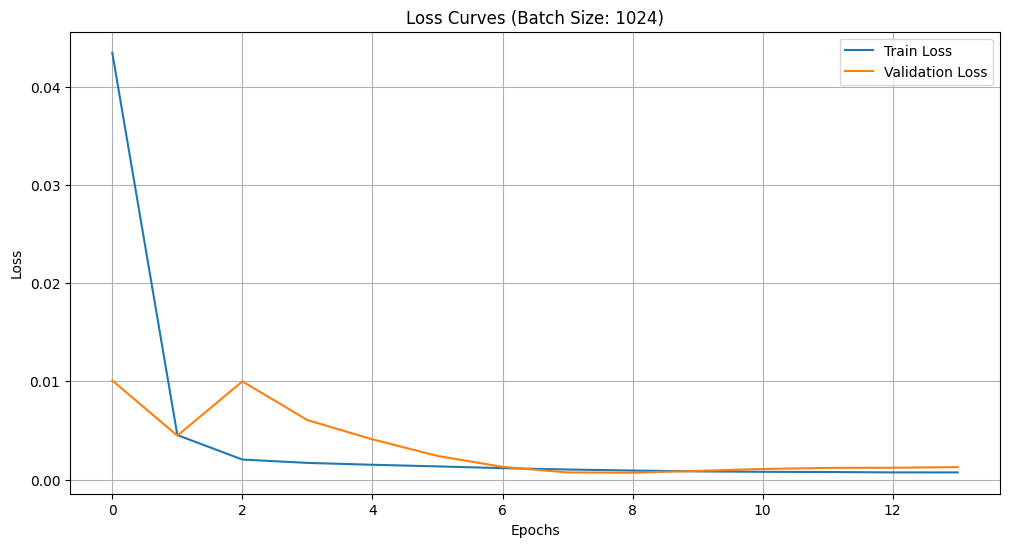

In [31]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : past_day_close + VADER + RoBERTa

In [32]:
from sklearn.model_selection import train_test_split

past_sentiment = ['past_day_close', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[past_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [33]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 32, MSE: 0.017, RMSE: 0.131, R-squared: 0.717
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 64, MSE: 0.013, RMSE: 0.112, R-squared: 0.791
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 128, MSE: 0.034, RMSE: 0.185, R-squared: 0.432
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 256, MSE: 0.038, RMSE: 0.195, R-squared: 0.370
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 512, MSE: 0.031, RMSE: 0.177, R-squared: 0.478
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 1024, MSE: 0.031, RMSE: 0.176, R-squared: 0.485


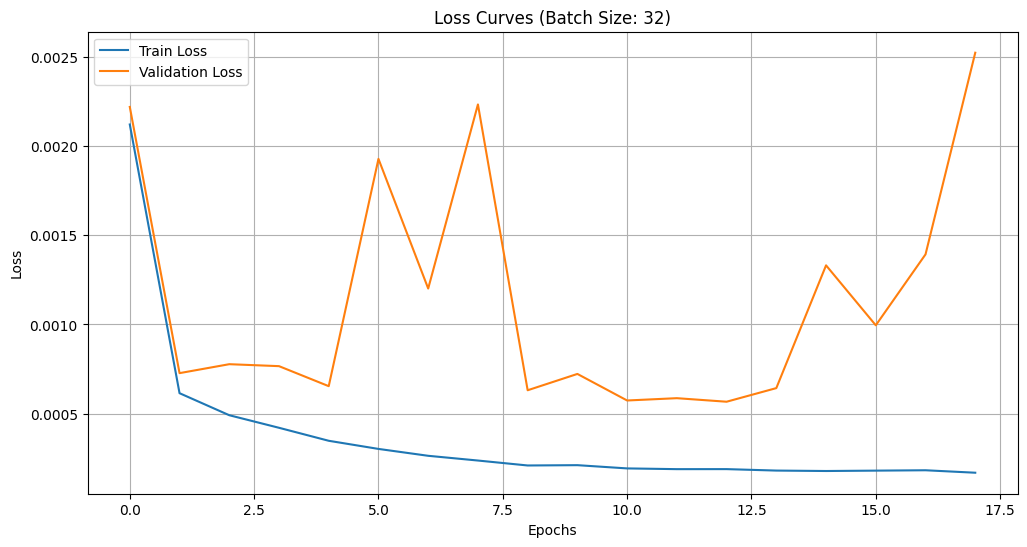

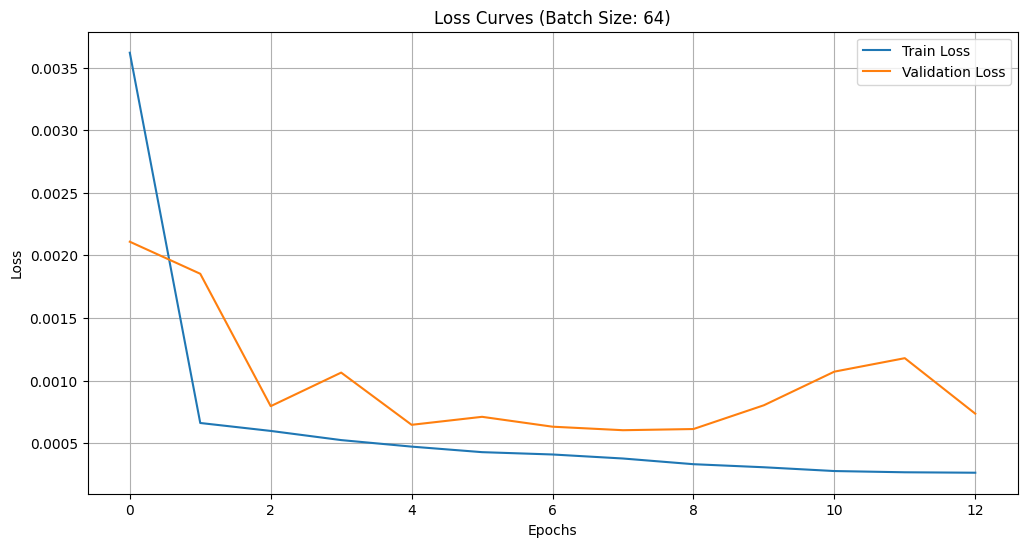

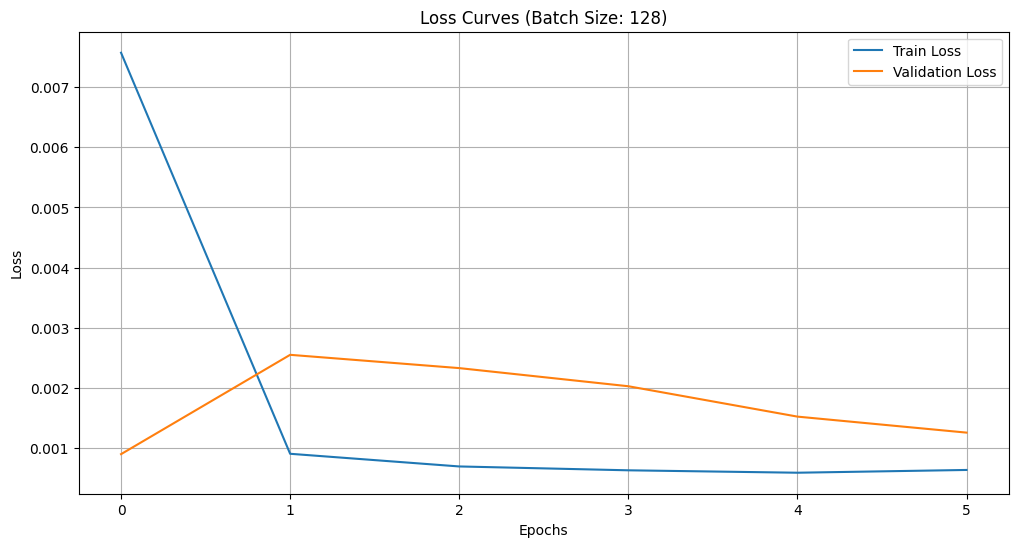

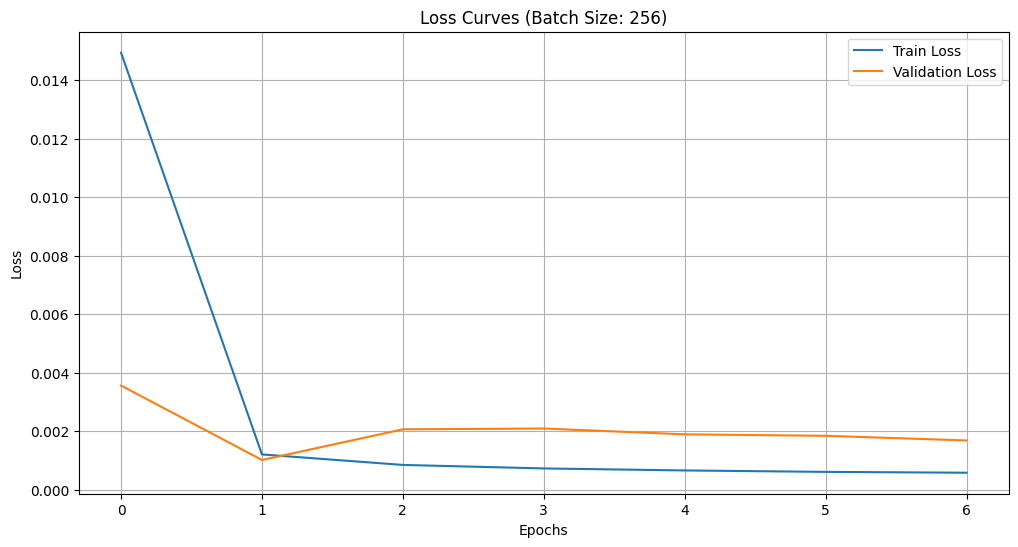

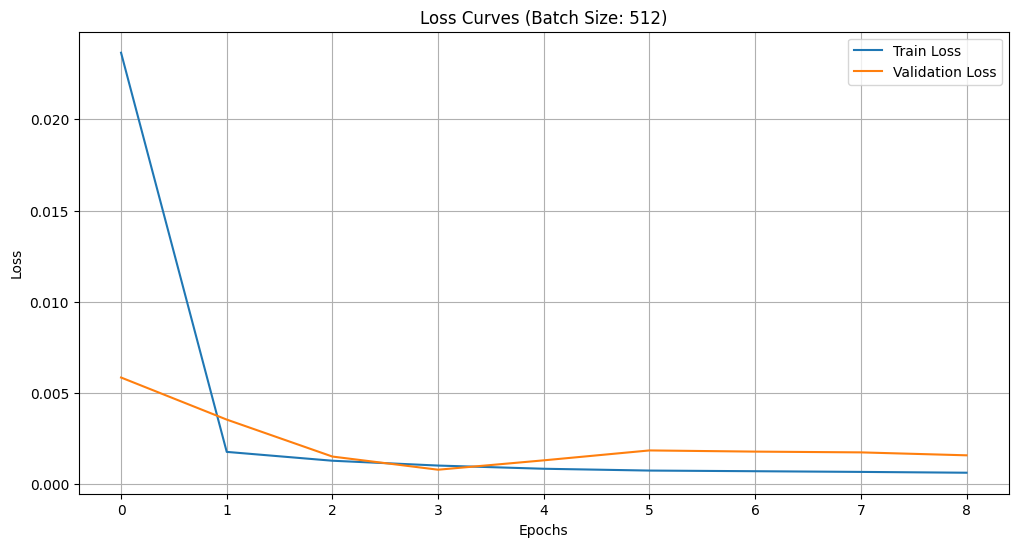

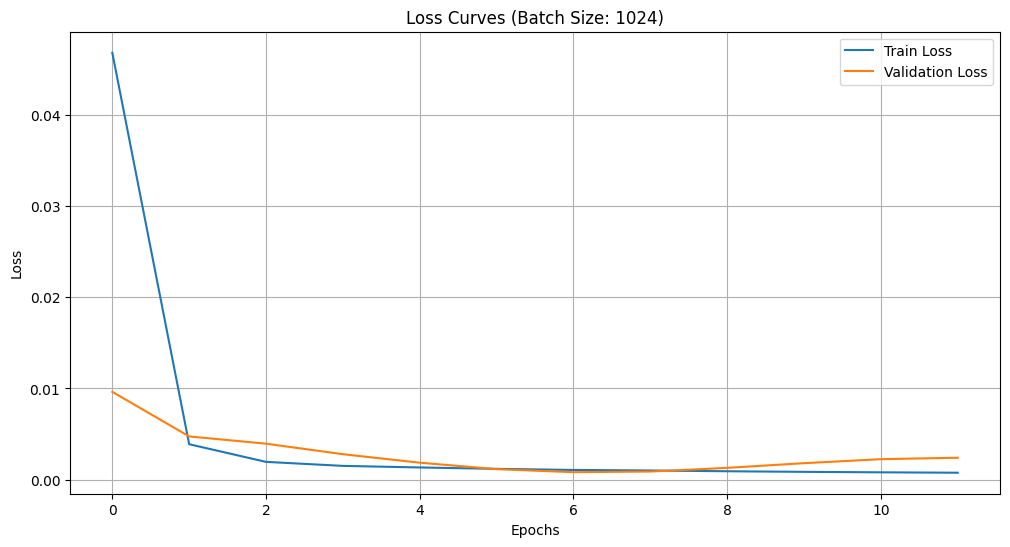

In [35]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume

In [36]:
from sklearn.model_selection import train_test_split

nasdaq = ['Open', 'High', 'Low', 'Volume']

X, y = create_dataset(df[nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [37]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 32, MSE: 0.009, RMSE: 0.094, R-squared: 0.853
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 64, MSE: 0.008, RMSE: 0.091, R-squared: 0.863
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 128, MSE: 0.013, RMSE: 0.115, R-squared: 0.781
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Batch Size: 256, MSE: 0.014, RMSE: 0.118, R-squared: 0.769
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Batch Size: 512, MSE: 0.015, RMSE: 0.122, R-squared: 0.754
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Batch Size: 1024, MSE: 0.016, RMSE: 0.125, R-squared: 0.740


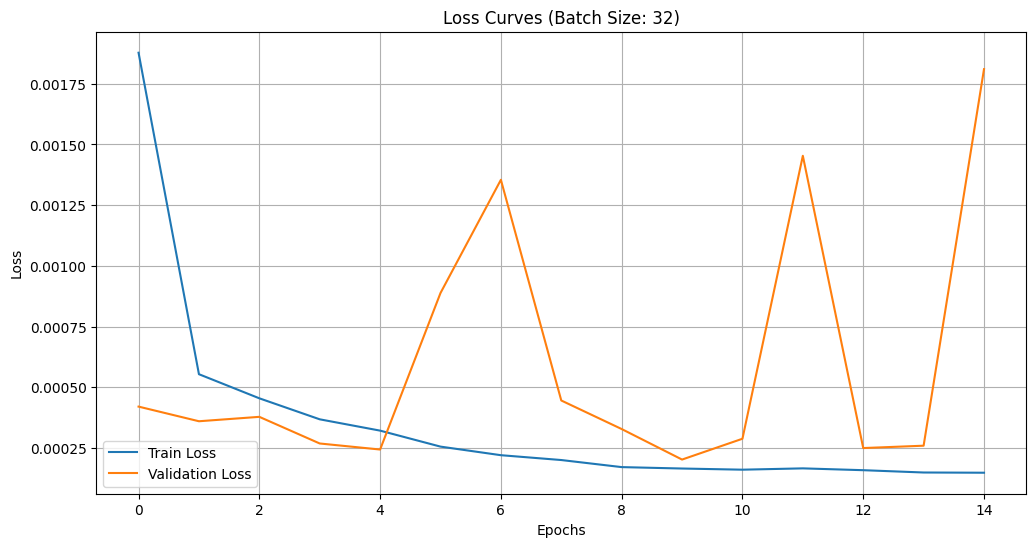

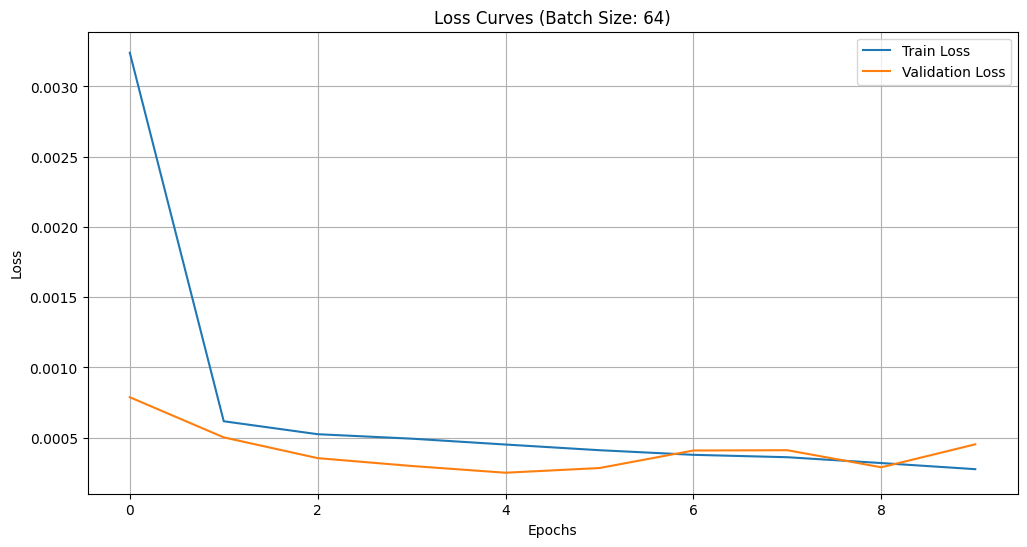

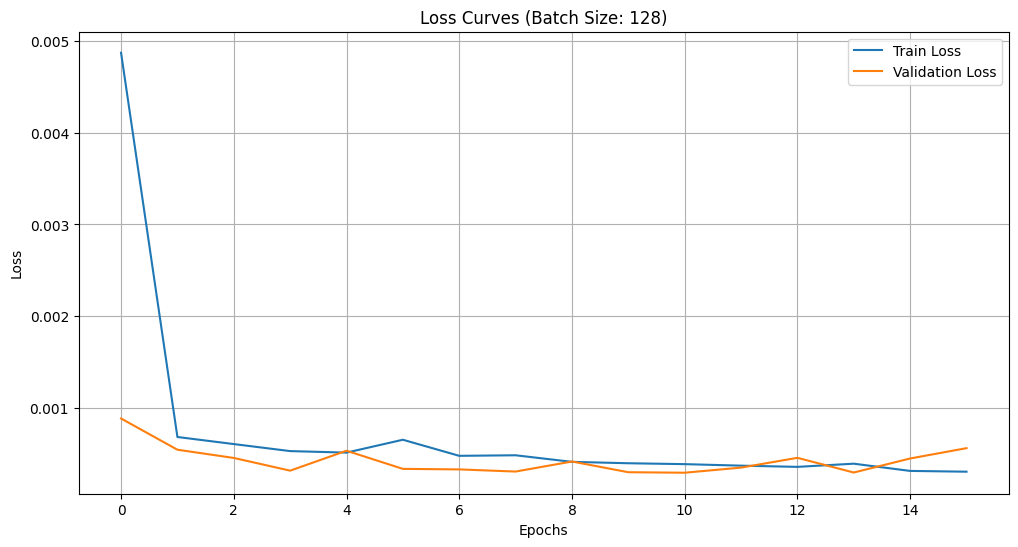

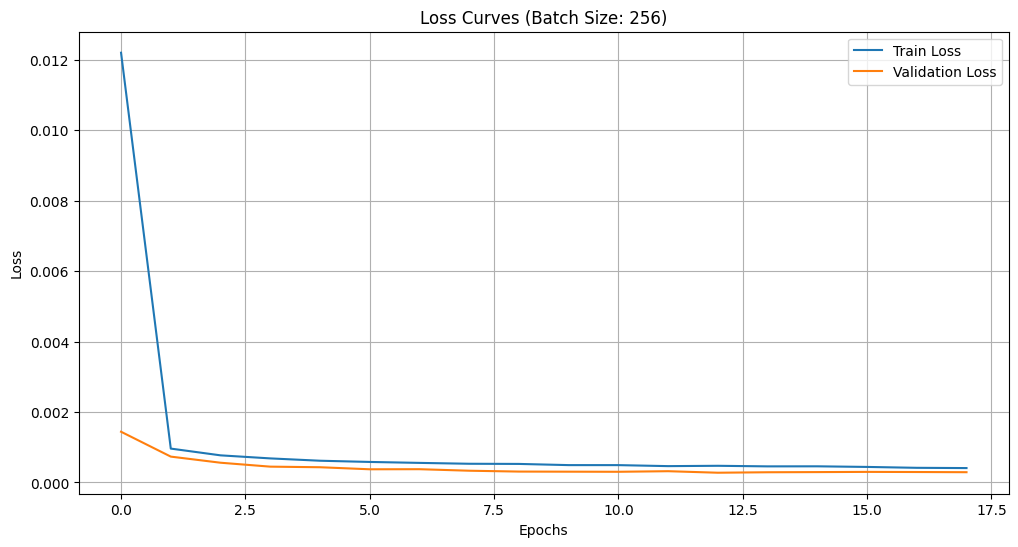

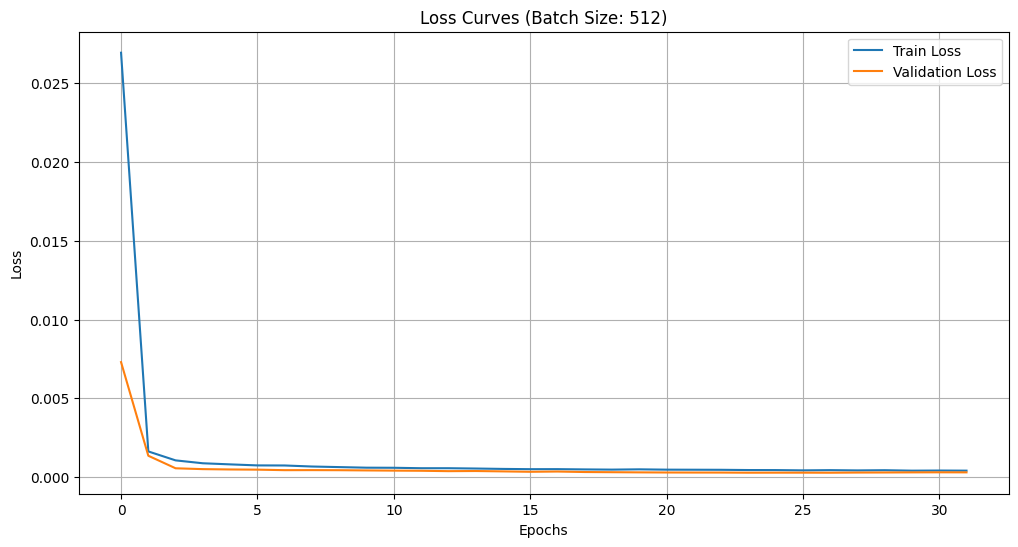

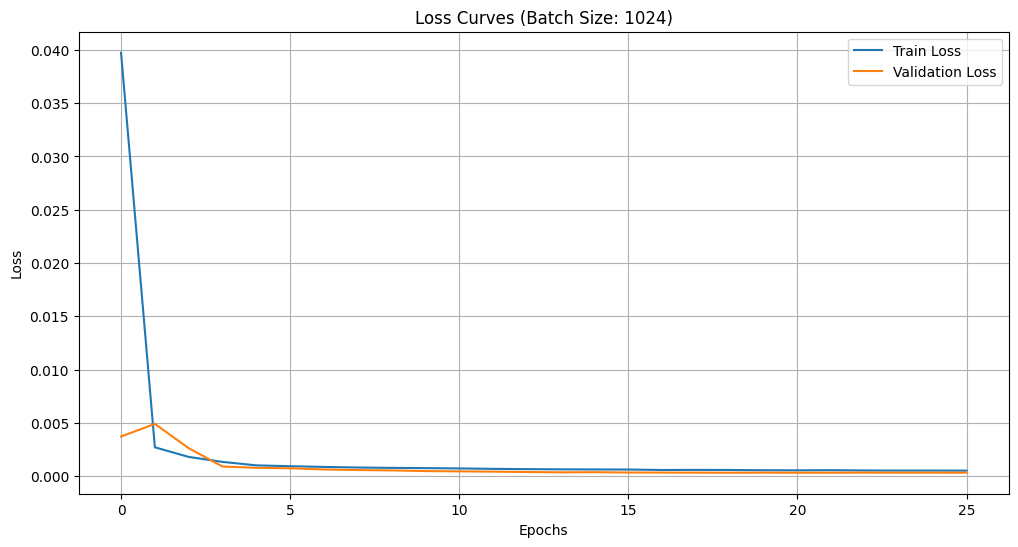

In [39]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close

In [40]:
from sklearn.model_selection import train_test_split

past_nasdaq = ['Open', 'High', 'Low', 'Volume', 'past_day_close']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [41]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 32, MSE: 0.004, RMSE: 0.065, R-squared: 0.929
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 64, MSE: 0.011, RMSE: 0.103, R-squared: 0.824
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 128, MSE: 0.016, RMSE: 0.127, R-squared: 0.734
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 256, MSE: 0.013, RMSE: 0.112, R-squared: 0.792
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 512, MSE: 0.023, RMSE: 0.153, R-squared: 0.612
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 1024, MSE: 0.022, RMSE: 0.148, R-squared: 0.636


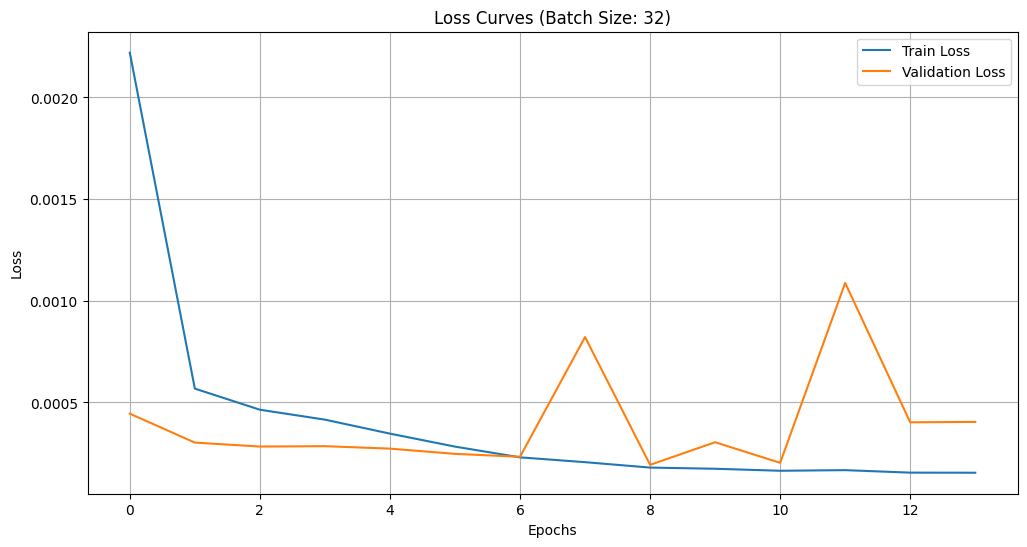

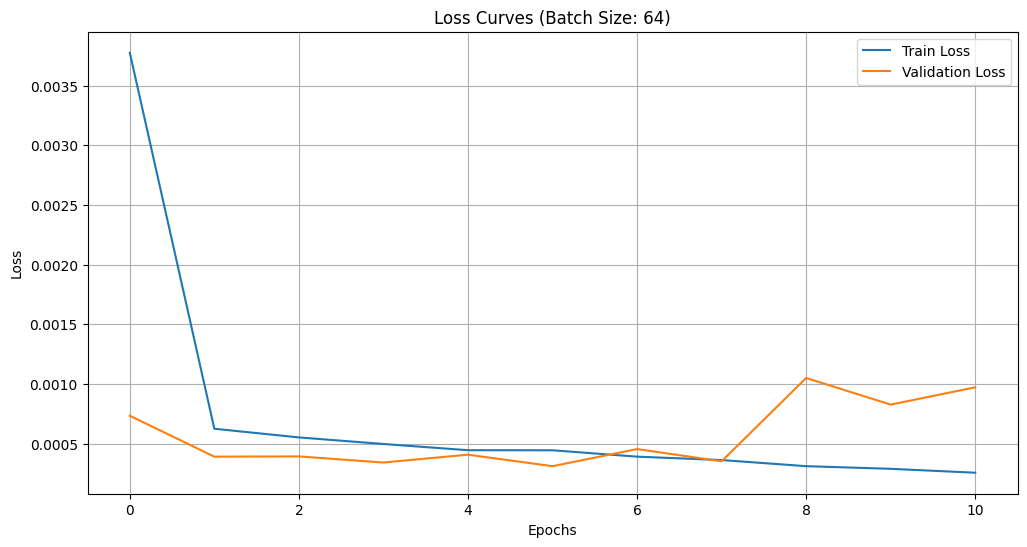

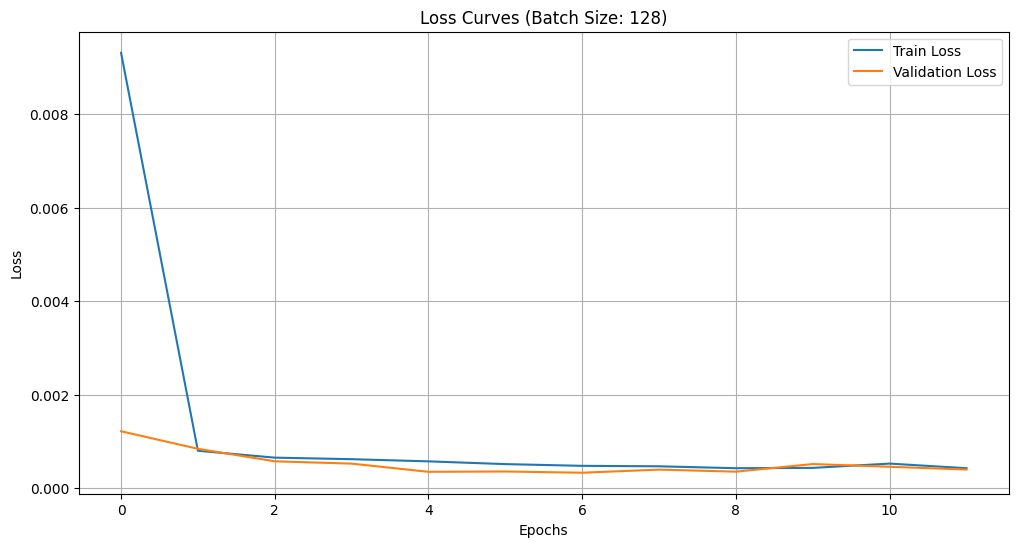

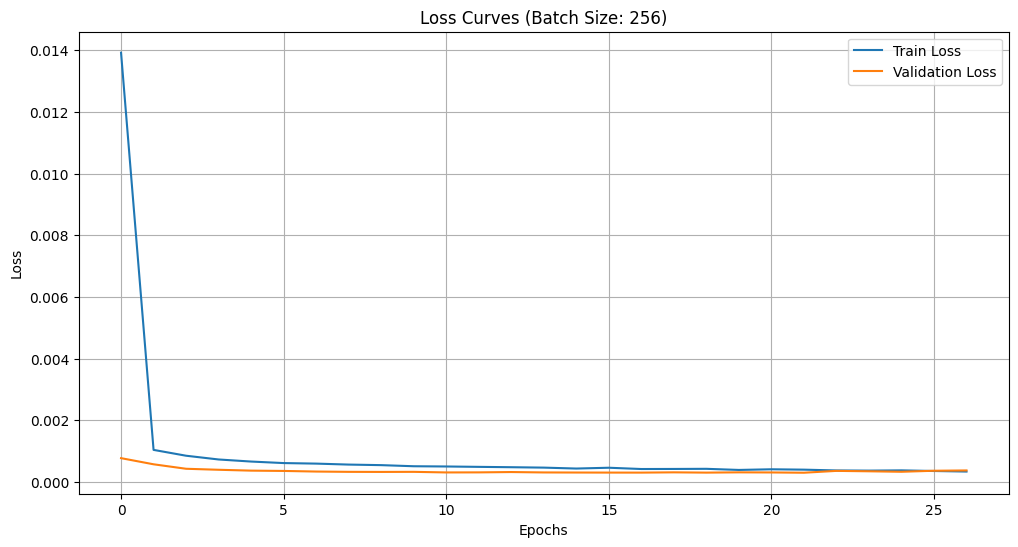

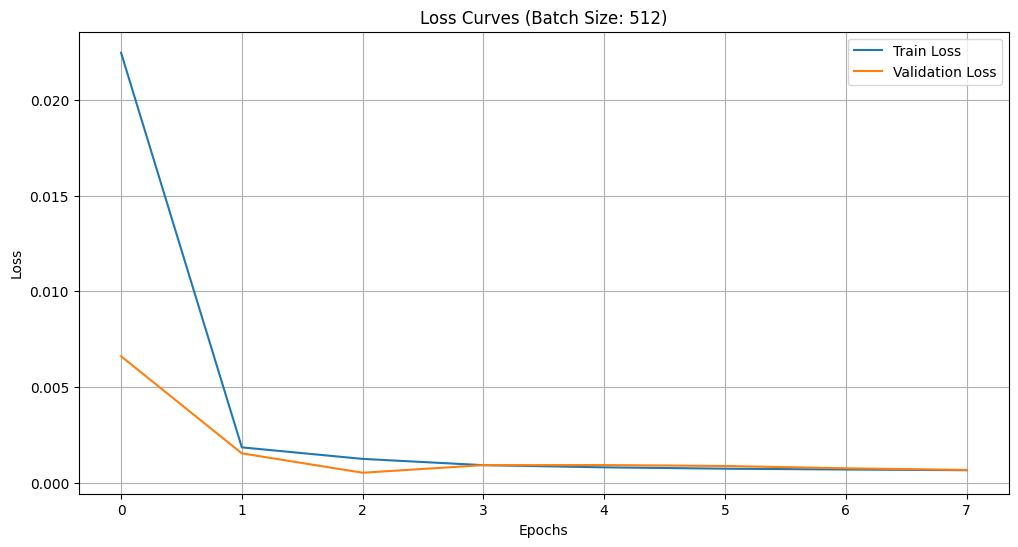

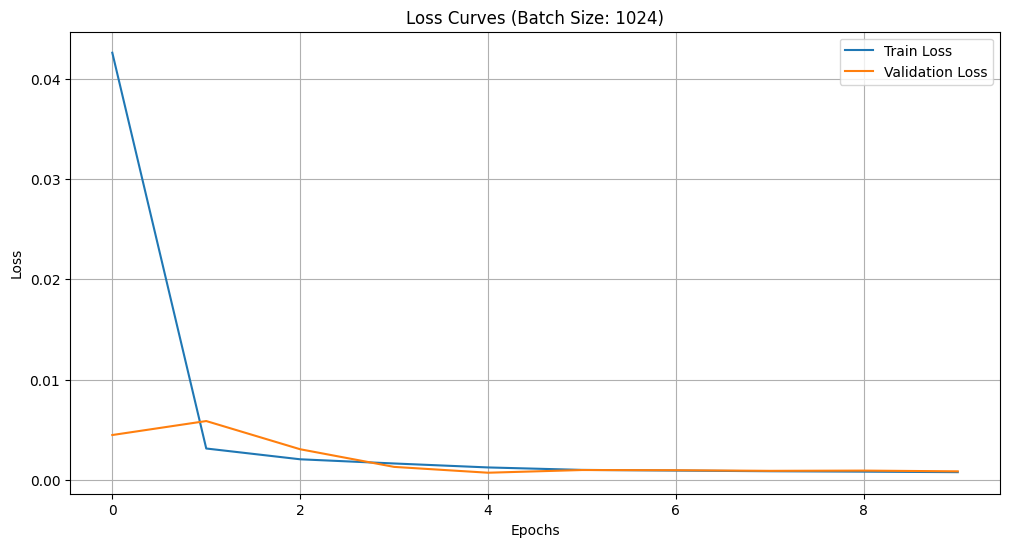

In [43]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + VADER

In [44]:
from sklearn.model_selection import train_test_split

past_nasdaq_vader = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment']

X, y = create_dataset(df[past_nasdaq_vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [45]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 32, MSE: 0.005, RMSE: 0.073, R-squared: 0.912
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 64, MSE: 0.012, RMSE: 0.111, R-squared: 0.795
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Batch Size: 128, MSE: 0.016, RMSE: 0.128, R-squared: 0.730
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Batch Size: 256, MSE: 0.014, RMSE: 0.120, R-squared: 0.760
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 512, MSE: 0.020, RMSE: 0.140, R-squared: 0.673
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 1024, MSE: 0.023, RMSE: 0.153, R-squared: 0.614


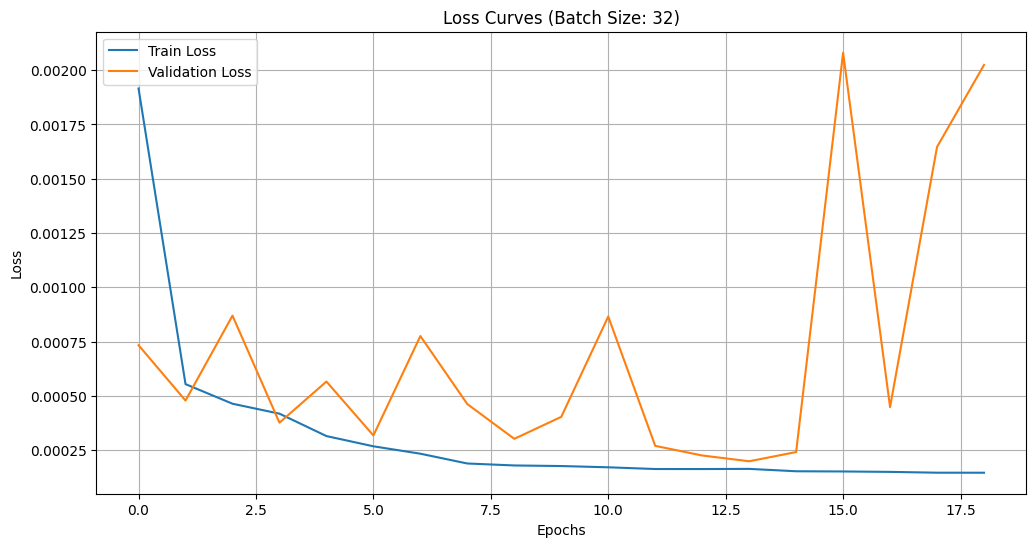

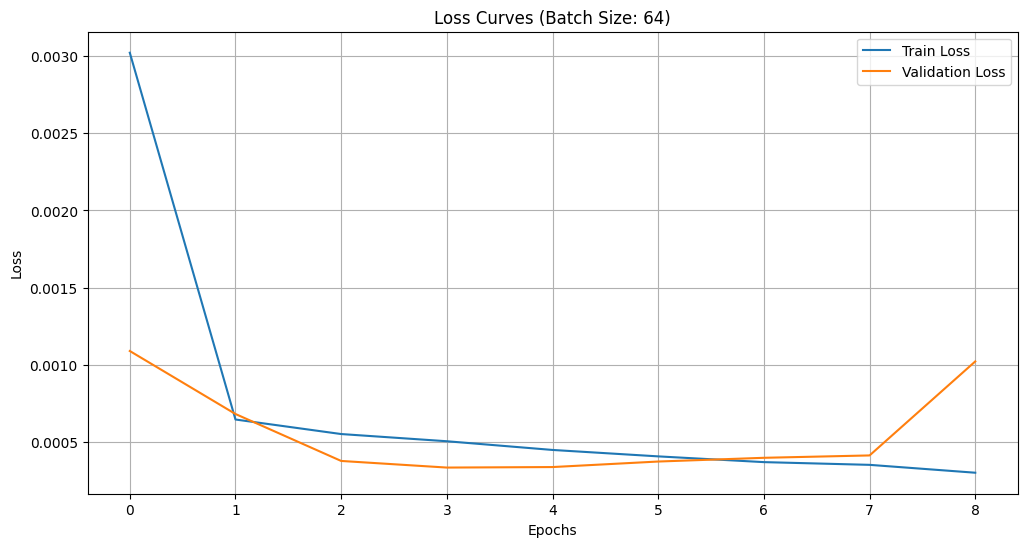

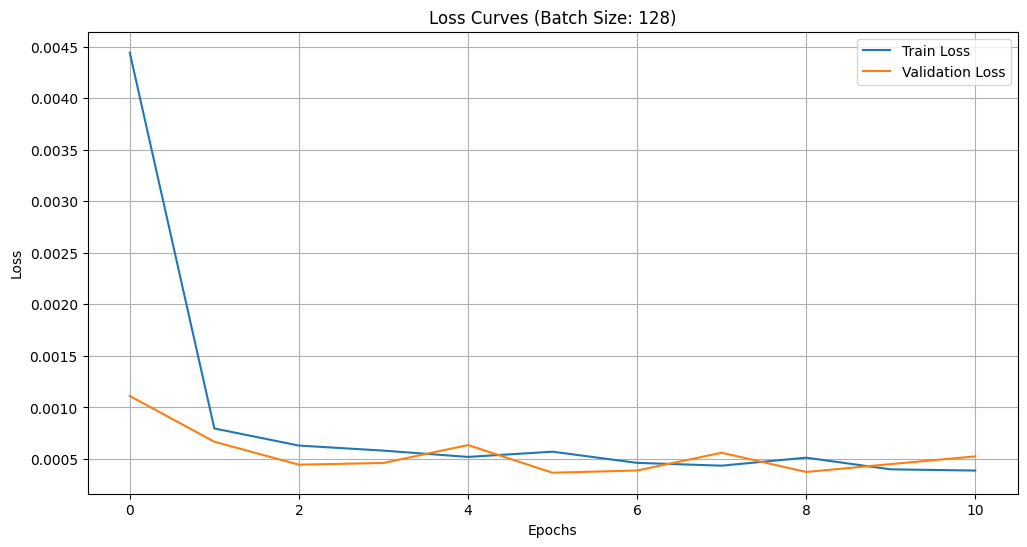

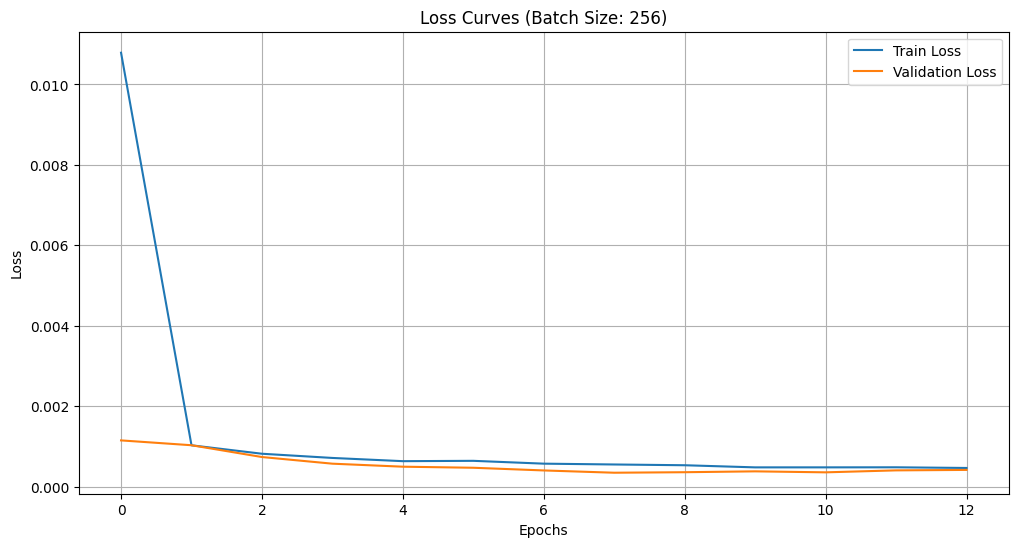

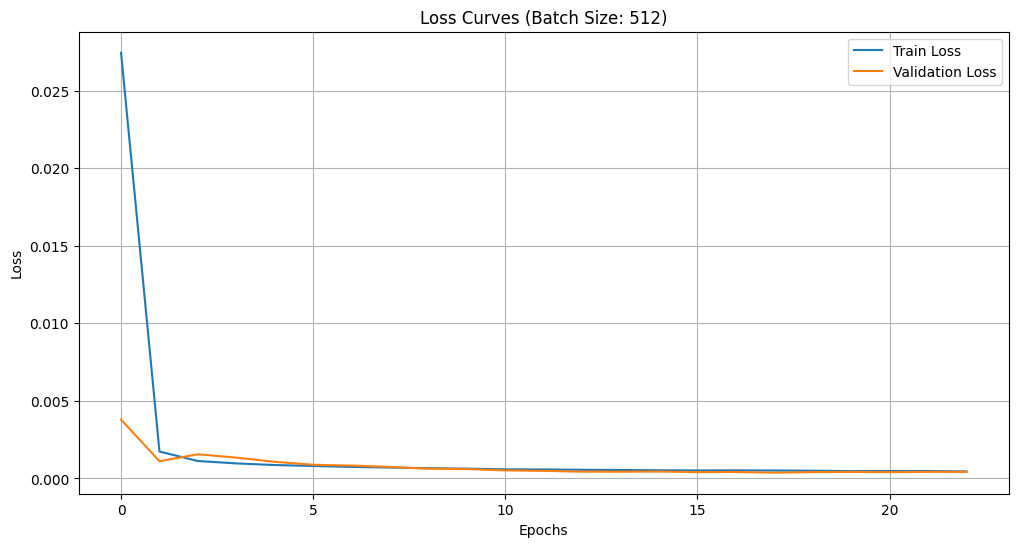

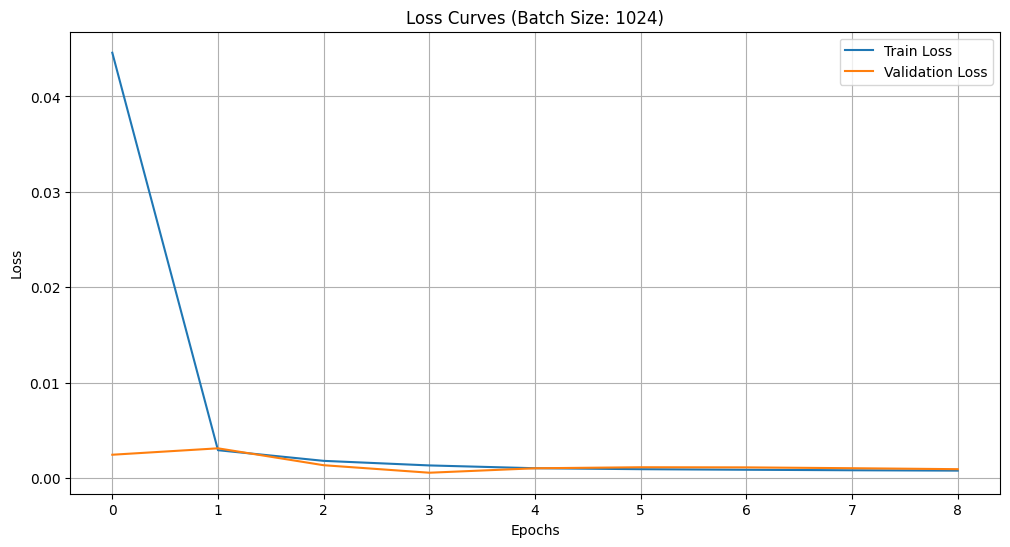

In [47]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + RoBERTa

In [48]:
from sklearn.model_selection import train_test_split

past_nasdaq_roberta = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq_roberta].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [49]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step
Batch Size: 32, MSE: 0.015, RMSE: 0.124, R-squared: 0.745
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Batch Size: 64, MSE: 0.008, RMSE: 0.087, R-squared: 0.875
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 128, MSE: 0.017, RMSE: 0.129, R-squared: 0.725
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 256, MSE: 0.021, RMSE: 0.145, R-squared: 0.651
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Batch Size: 512, MSE: 0.012, RMSE: 0.109, R-squared: 0.802
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Batch Size: 1024, MSE: 0.019, RMSE: 0.139, R-squared: 0.679


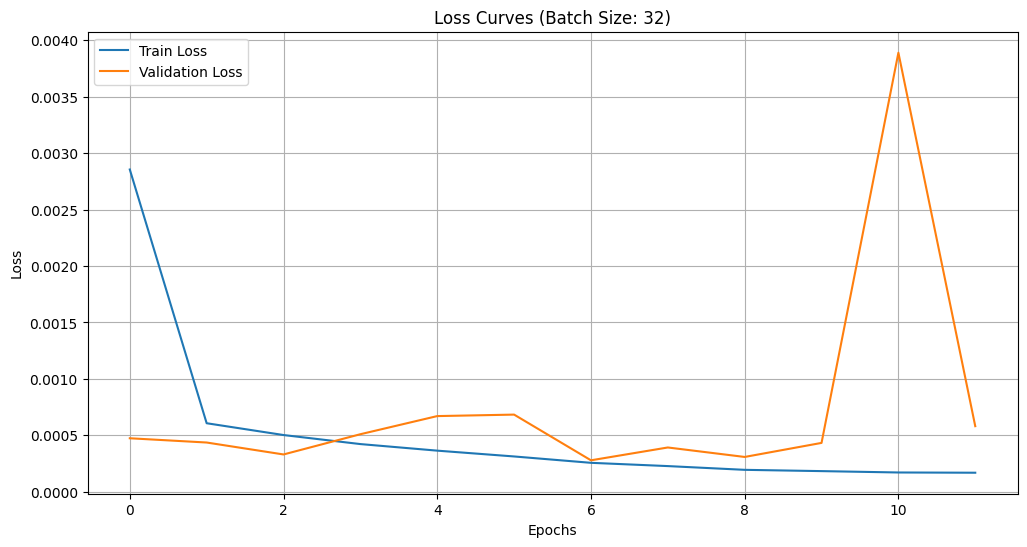

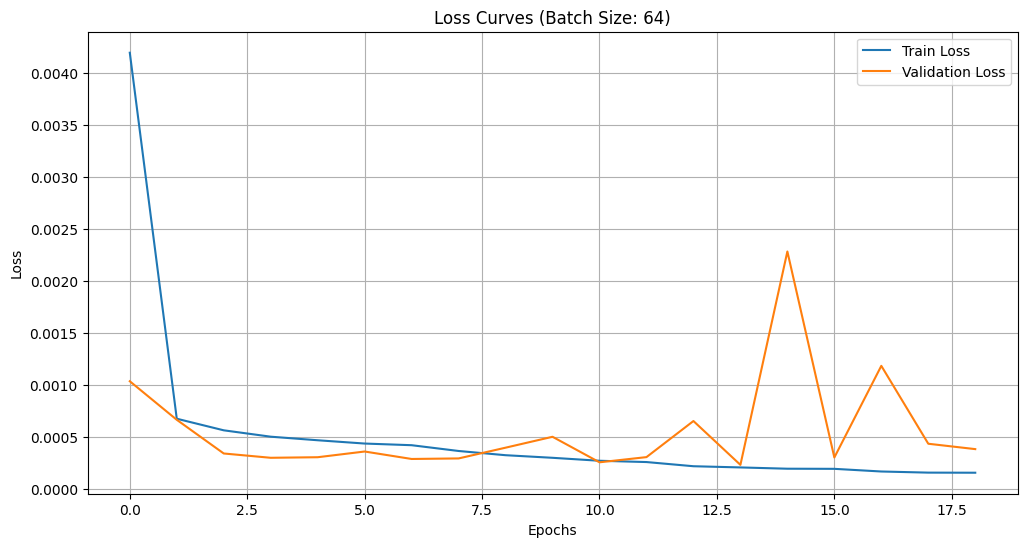

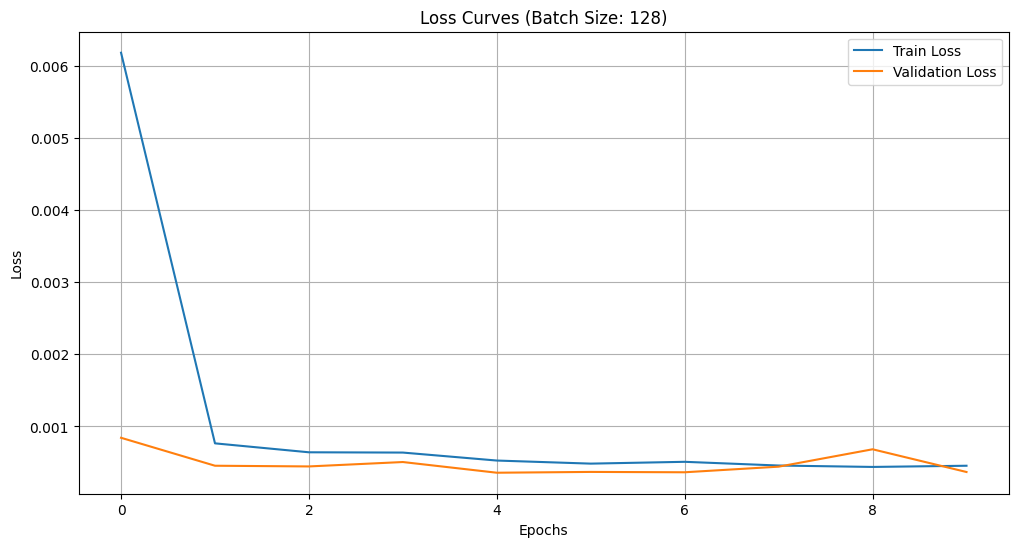

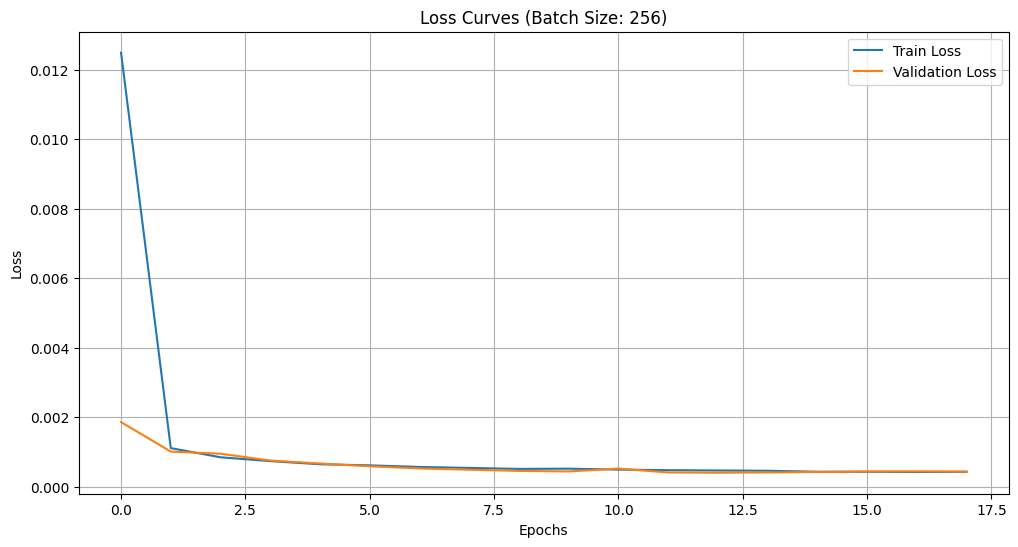

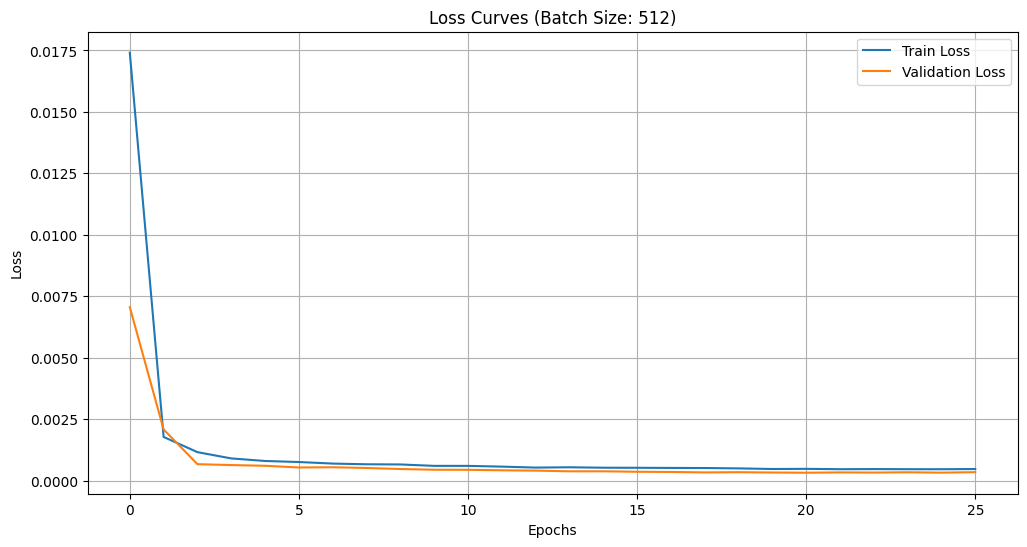

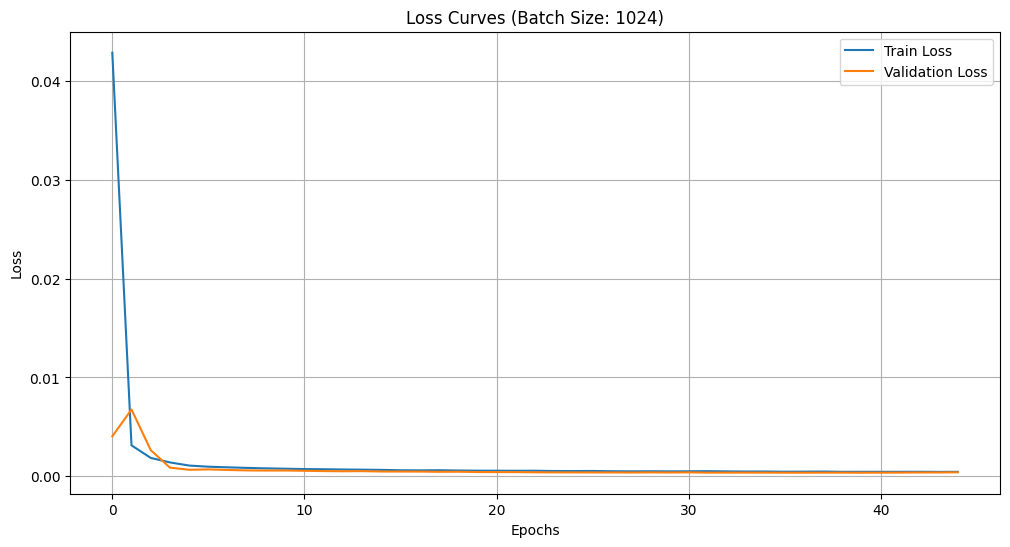

In [51]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : Open + High + Low + Volume + past_day_close + VADER + RoBERTa 

In [52]:
from sklearn.model_selection import train_test_split

past_nasdaq_sentiment = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [53]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Batch Size: 32, MSE: 0.009, RMSE: 0.093, R-squared: 0.858
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Batch Size: 64, MSE: 0.011, RMSE: 0.107, R-squared: 0.809
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Batch Size: 128, MSE: 0.019, RMSE: 0.138, R-squared: 0.683
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 256, MSE: 0.014, RMSE: 0.120, R-squared: 0.760
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Batch Size: 512, MSE: 0.021, RMSE: 0.145, R-squared: 0.653
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 1024, MSE: 0.020, RMSE: 0.141, R-squared: 0.670


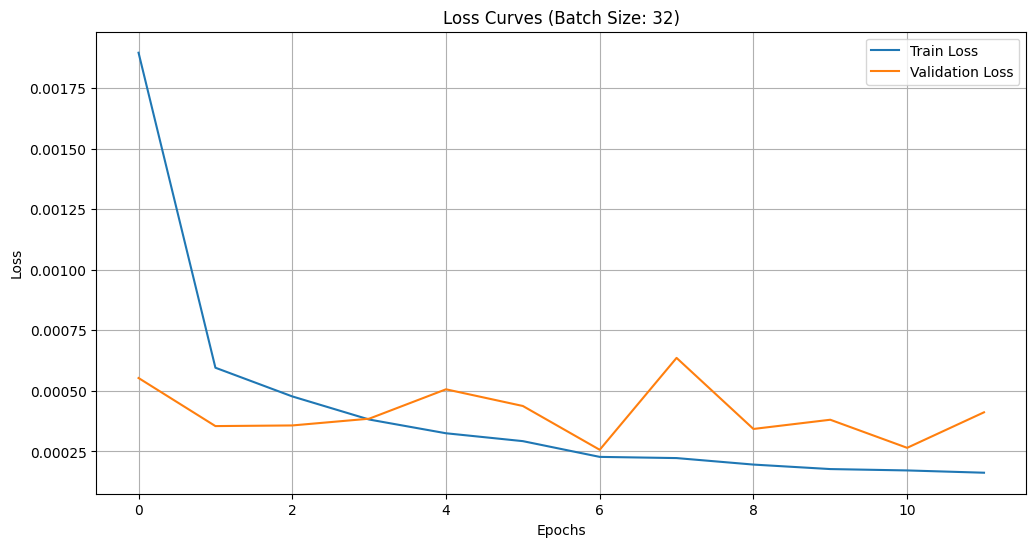

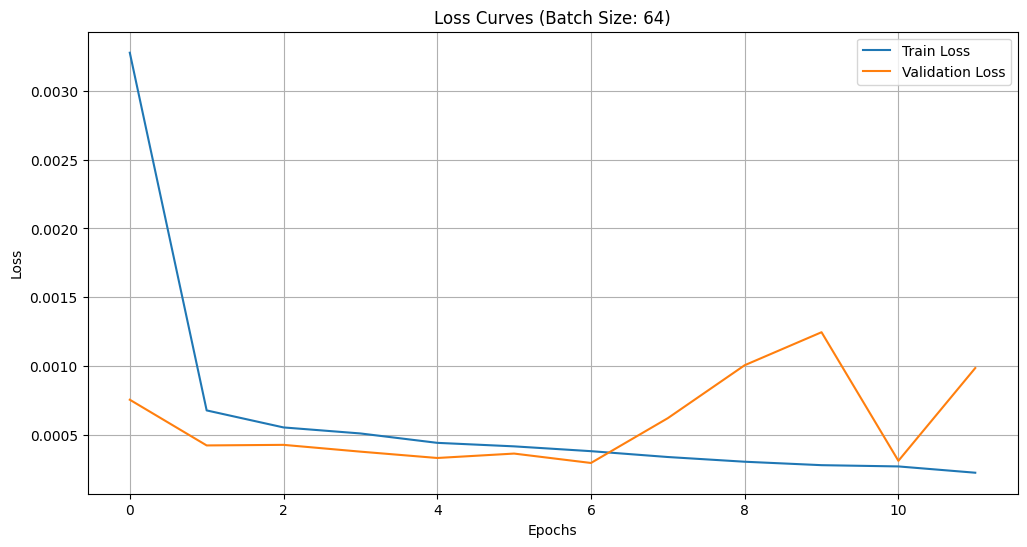

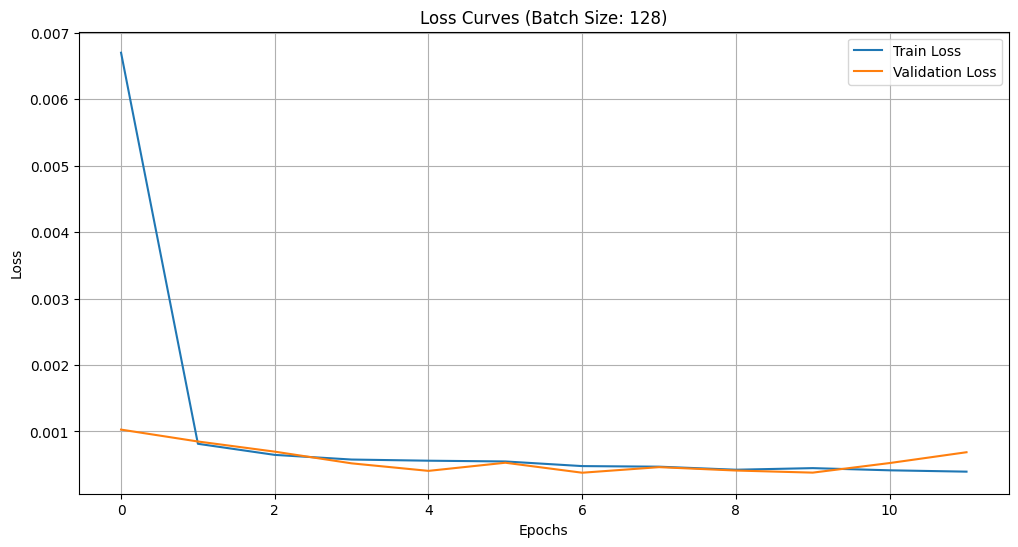

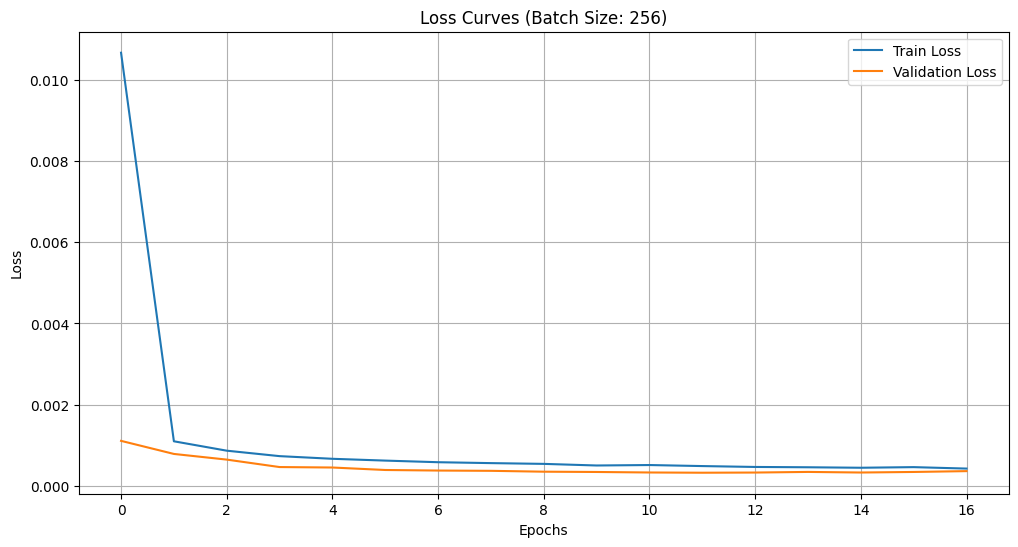

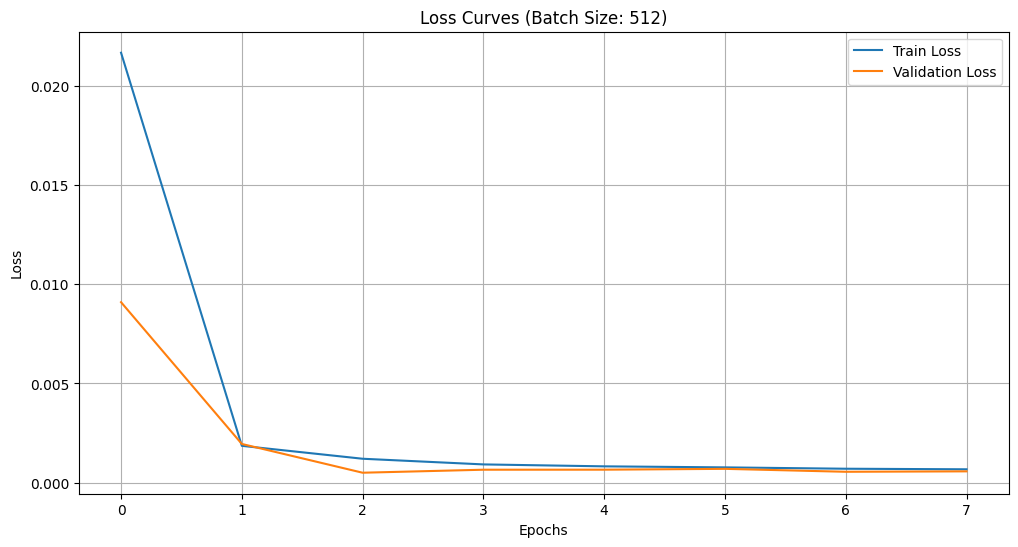

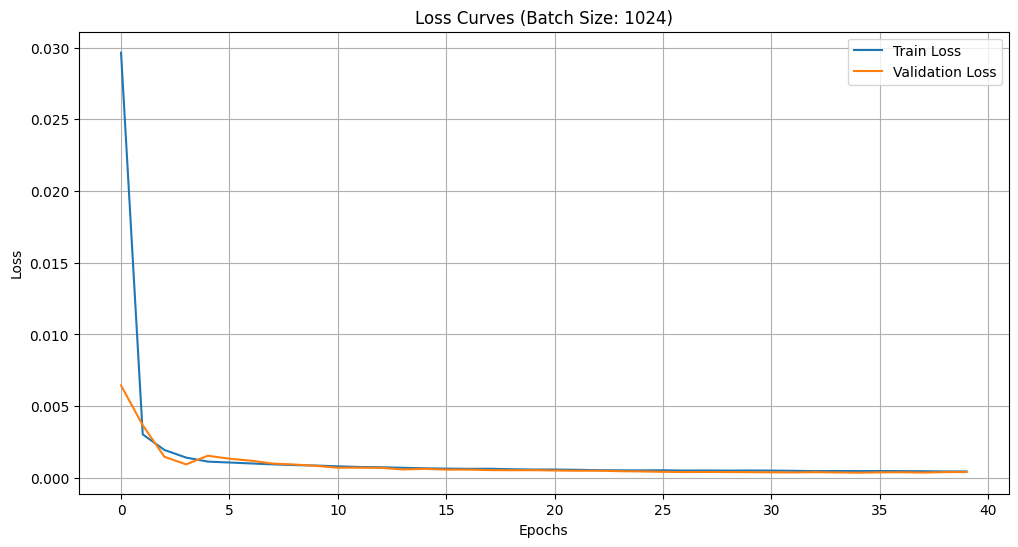

In [55]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

input : open + high + low + volume + vader_sentiment + roberta_sentiment

In [56]:
from sklearn.model_selection import train_test_split

nasdaq_sentiment = ['Open', 'High', 'Low', 'Volume', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[nasdaq_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [57]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [32, 64, 128, 256, 512, 1024]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
Batch Size: 32, MSE: 0.009, RMSE: 0.097, R-squared: 0.844
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 64, MSE: 0.010, RMSE: 0.100, R-squared: 0.834
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Batch Size: 128, MSE: 0.010, RMSE: 0.098, R-squared: 0.839
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 256, MSE: 0.010, RMSE: 0.102, R-squared: 0.829
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step
Batch Size: 512, MSE: 0.015, RMSE: 0.123, R-squared: 0.750
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Batch Size: 1024, MSE: 0.021, RMSE: 0.145, R-squared: 0.651


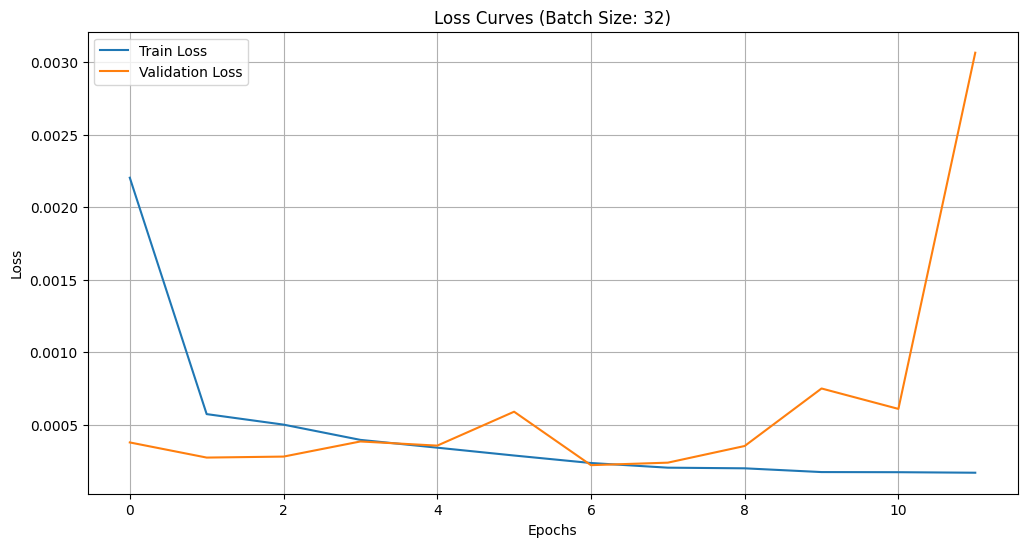

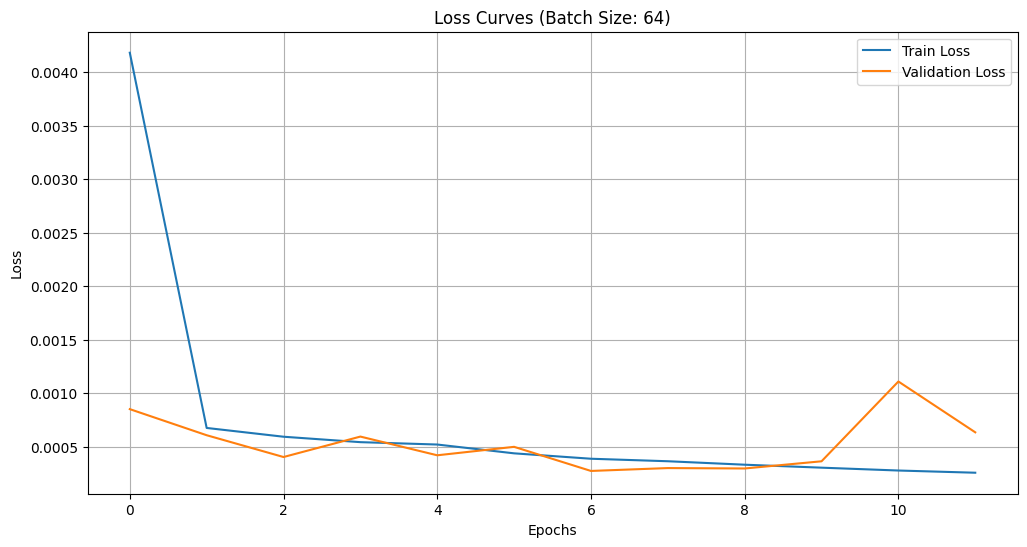

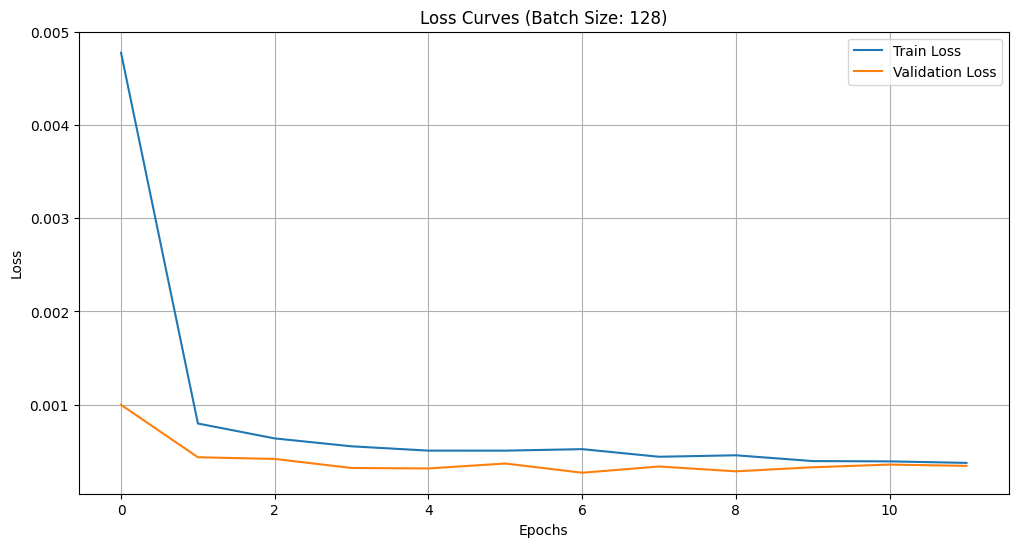

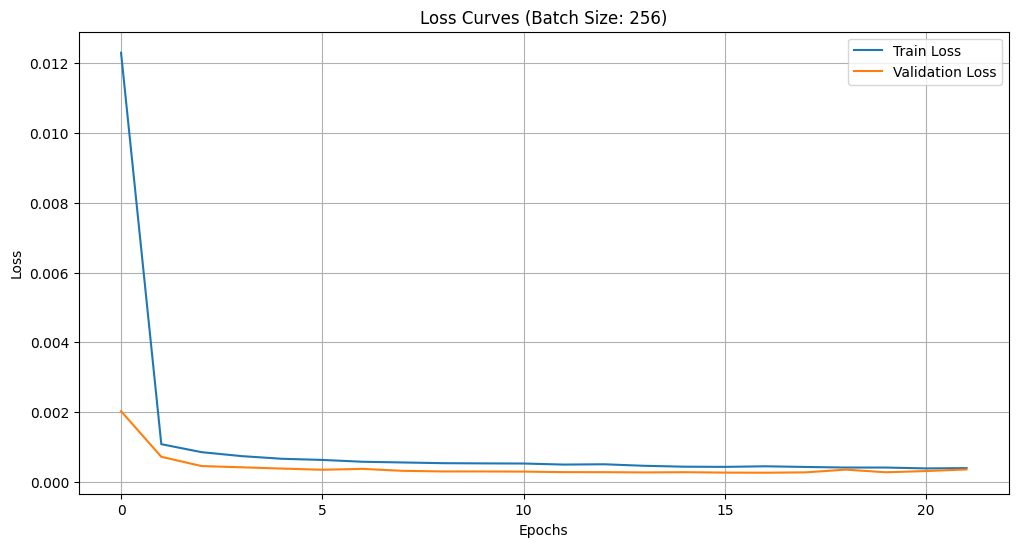

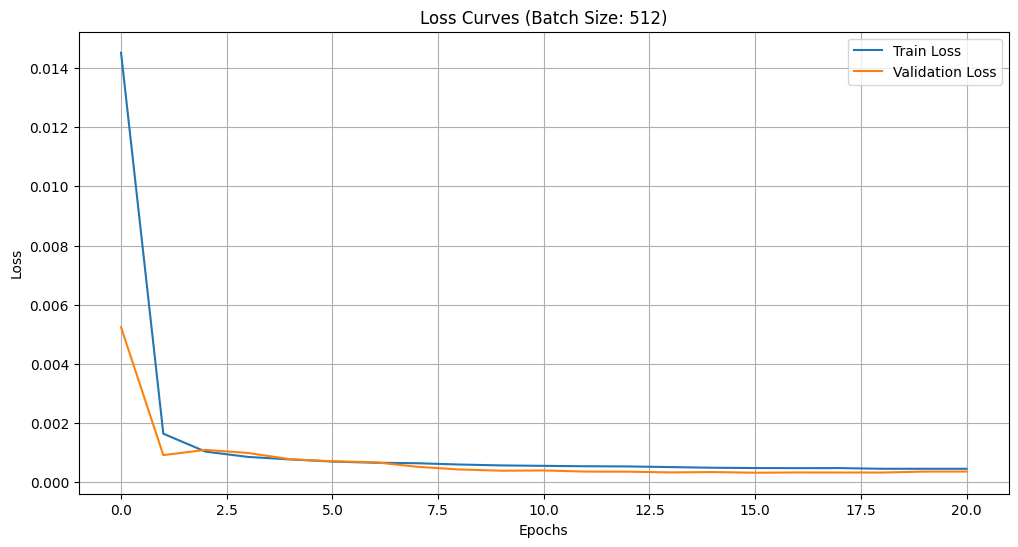

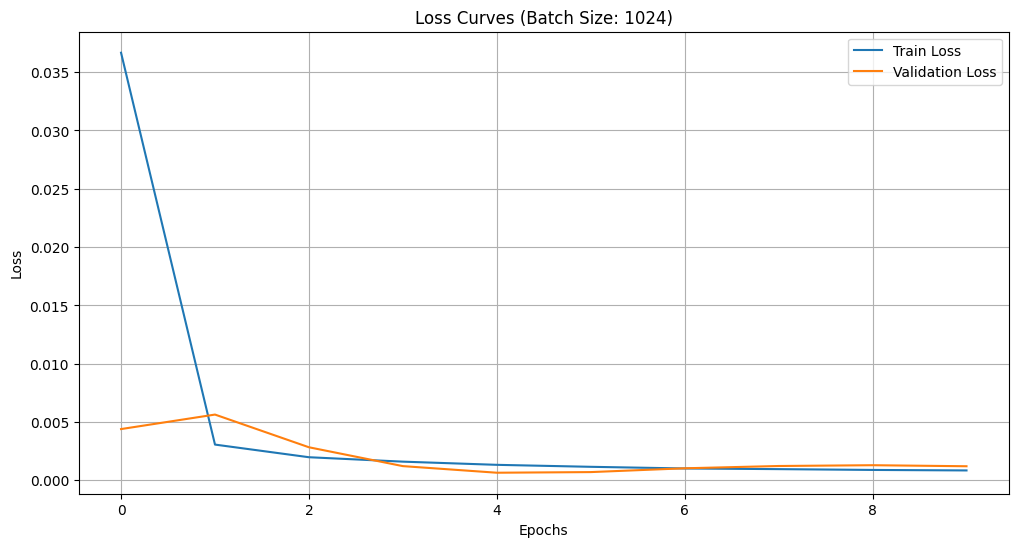

In [59]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

-1~1 정규화

In [3]:
# VADER Sentiment 정규화
min_vader = df['vader_sentiment'].min()
max_vader = df['vader_sentiment'].max()

# 정규화: -1에서 1 사이로 변환
df['vader_sentiment'] = 2 * ((df['vader_sentiment'] - min_vader) / (max_vader - min_vader)) - 1

LSTM (batch size 1024, 2048, 4096)

In [36]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Batch Size: 1024, MSE: 0.993, RMSE: 0.996, R-squared: -15.465
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 2048, MSE: 1.097, RMSE: 1.047, R-squared: -17.182
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 4096, MSE: 0.864, RMSE: 0.930, R-squared: -13.331


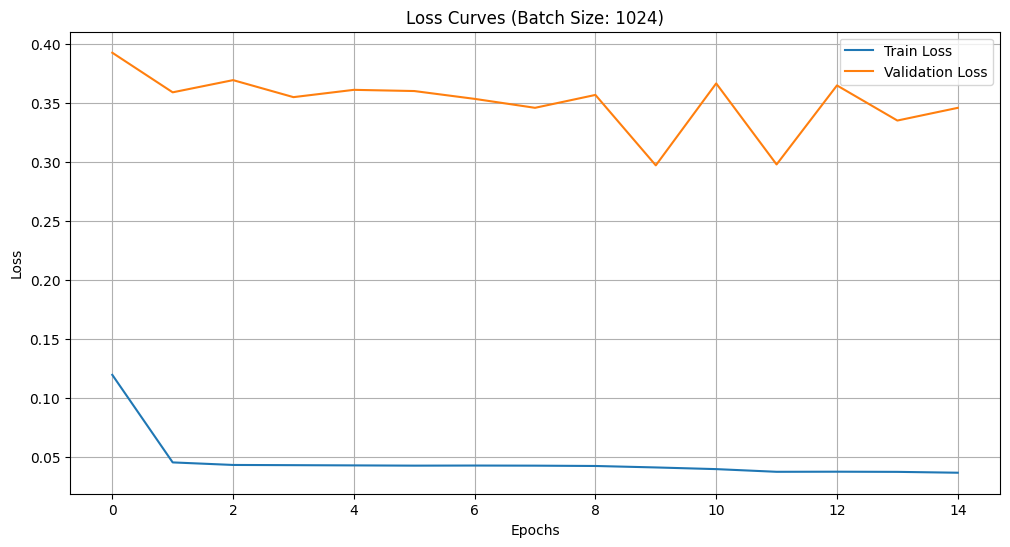

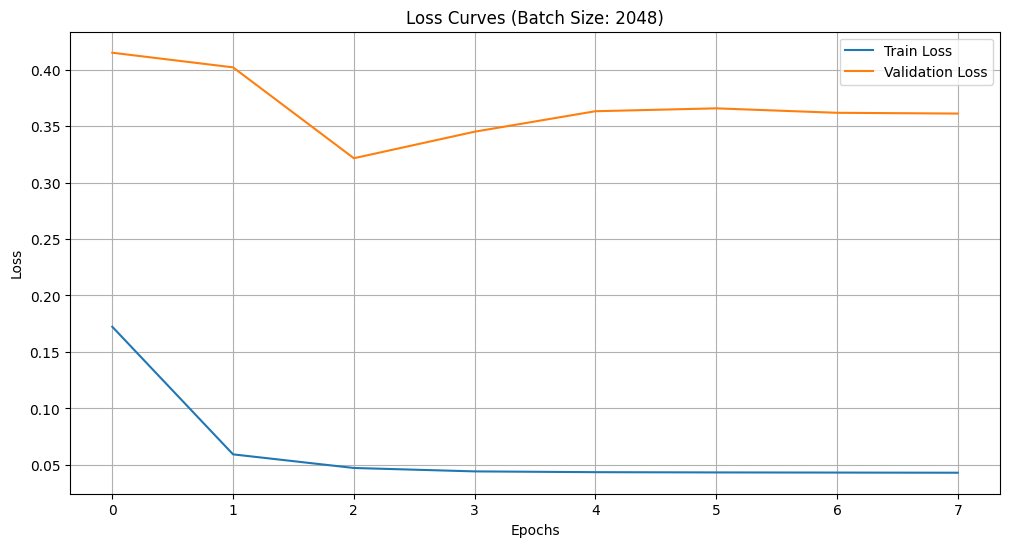

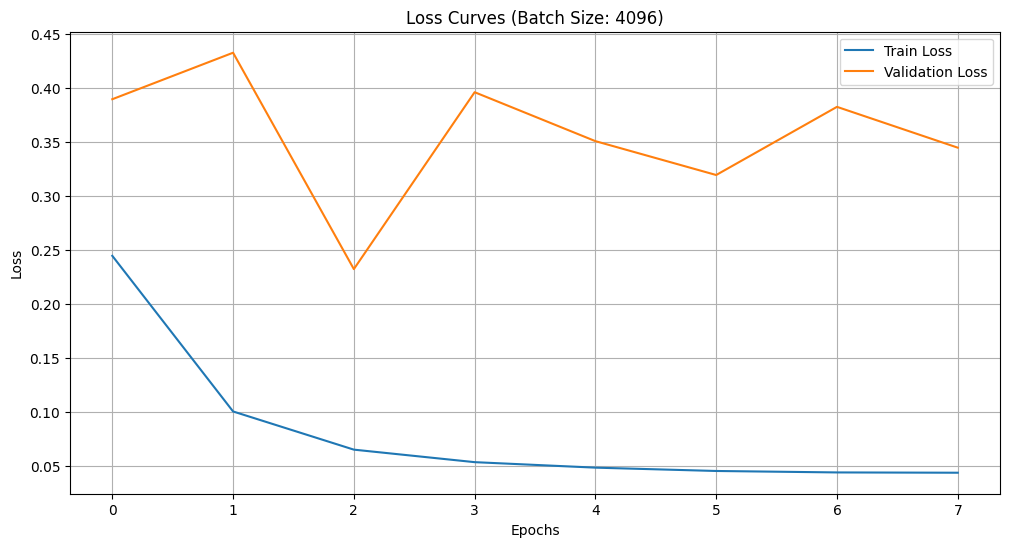

In [38]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [40]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 1024, MSE: 1.108, RMSE: 1.053, R-squared: -17.372
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 2048, MSE: 1.127, RMSE: 1.062, R-squared: -17.692
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 4096, MSE: 0.669, RMSE: 0.818, R-squared: -10.091


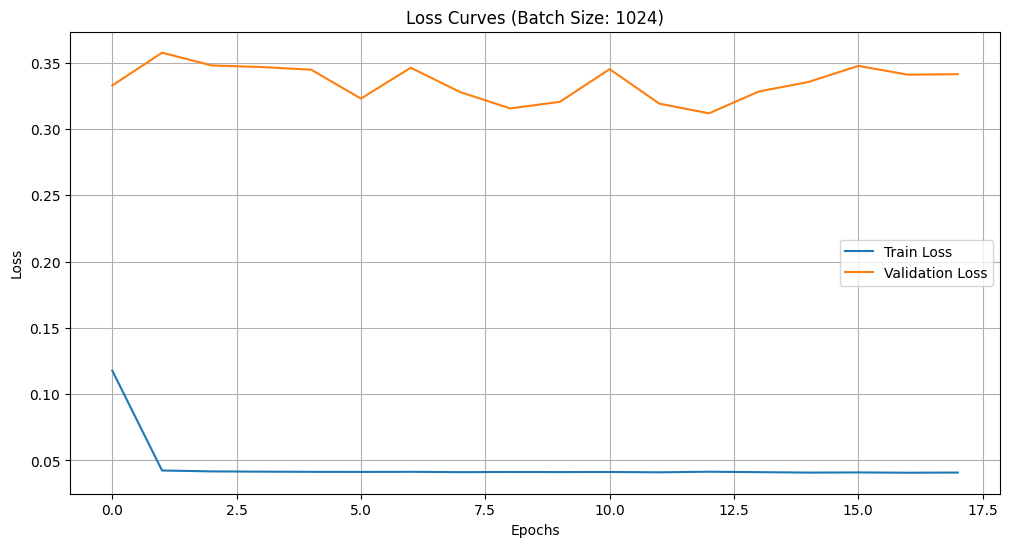

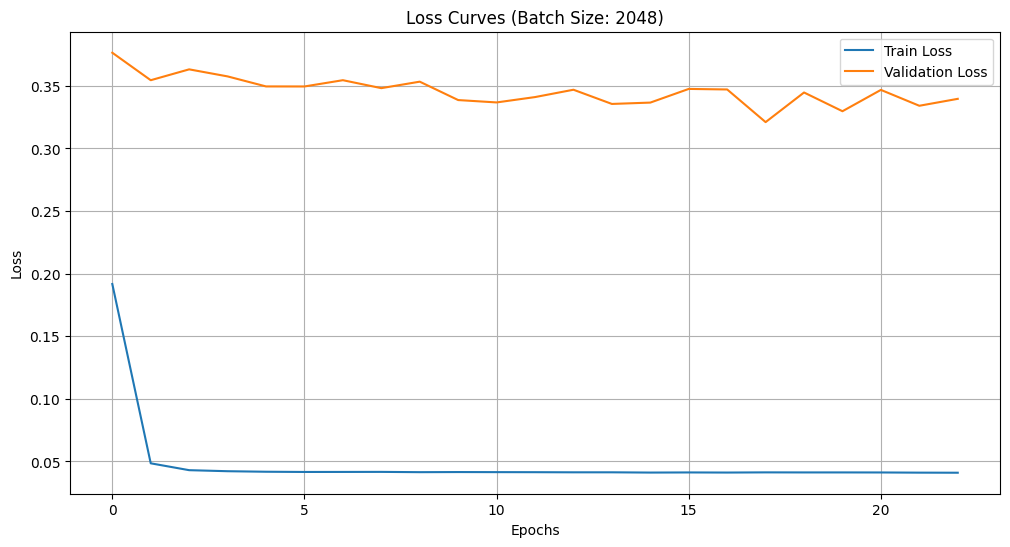

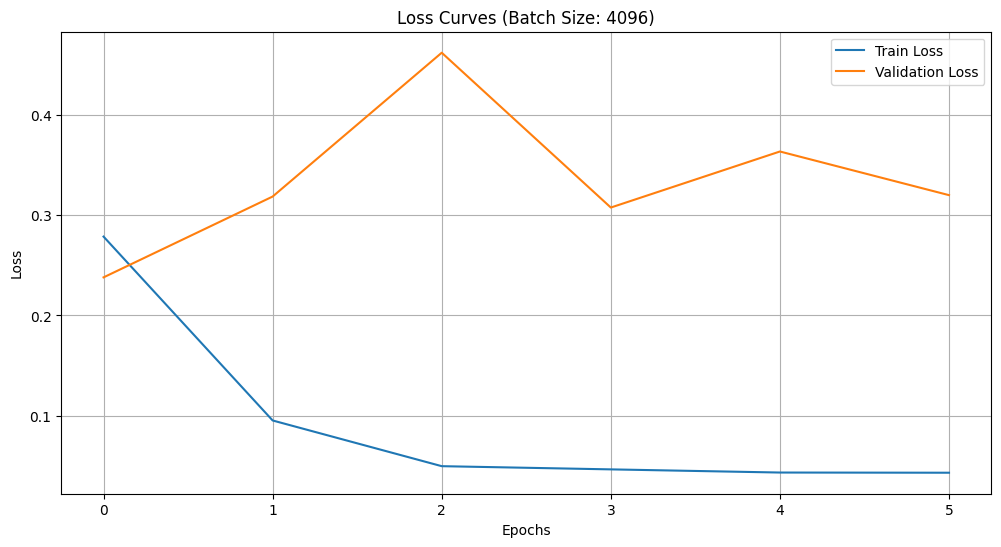

In [42]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [44]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 1024, MSE: 1.041, RMSE: 1.020, R-squared: -16.266
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Batch Size: 2048, MSE: 1.132, RMSE: 1.064, R-squared: -17.778
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Batch Size: 4096, MSE: 1.064, RMSE: 1.032, R-squared: -16.647


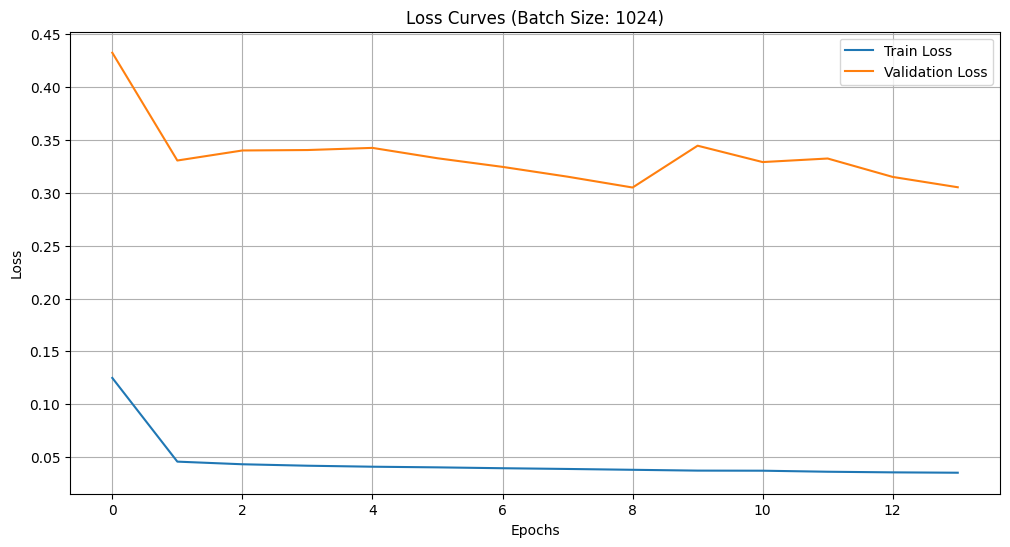

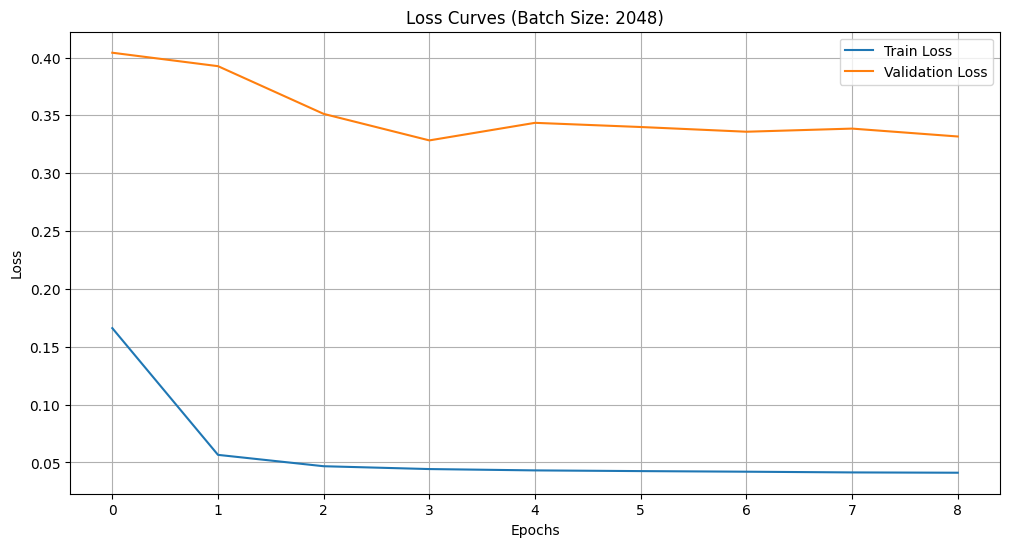

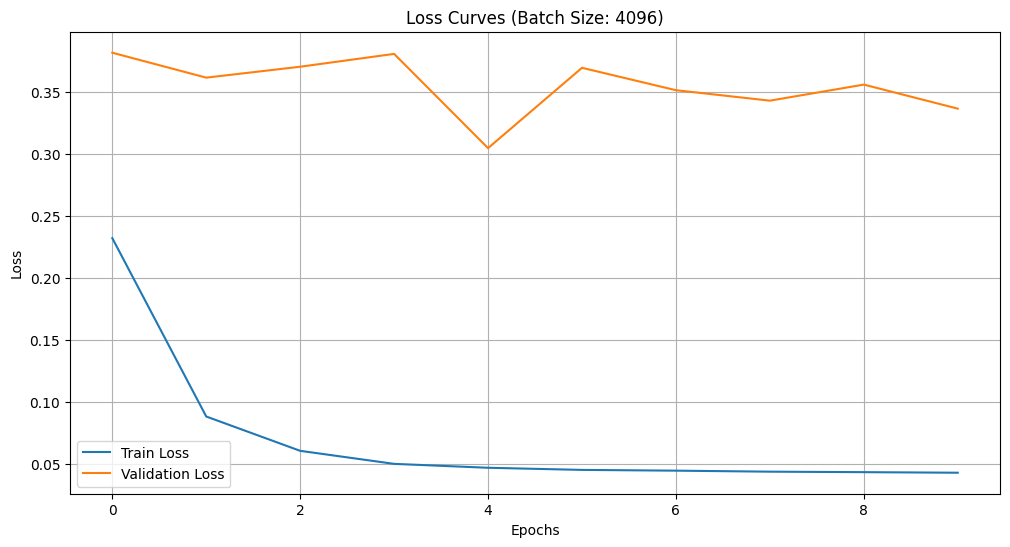

In [46]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [48]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Batch Size: 1024, MSE: 0.023, RMSE: 0.152, R-squared: 0.618
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Batch Size: 2048, MSE: 0.010, RMSE: 0.098, R-squared: 0.840
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
Batch Size: 4096, MSE: 0.008, RMSE: 0.087, R-squared: 0.874


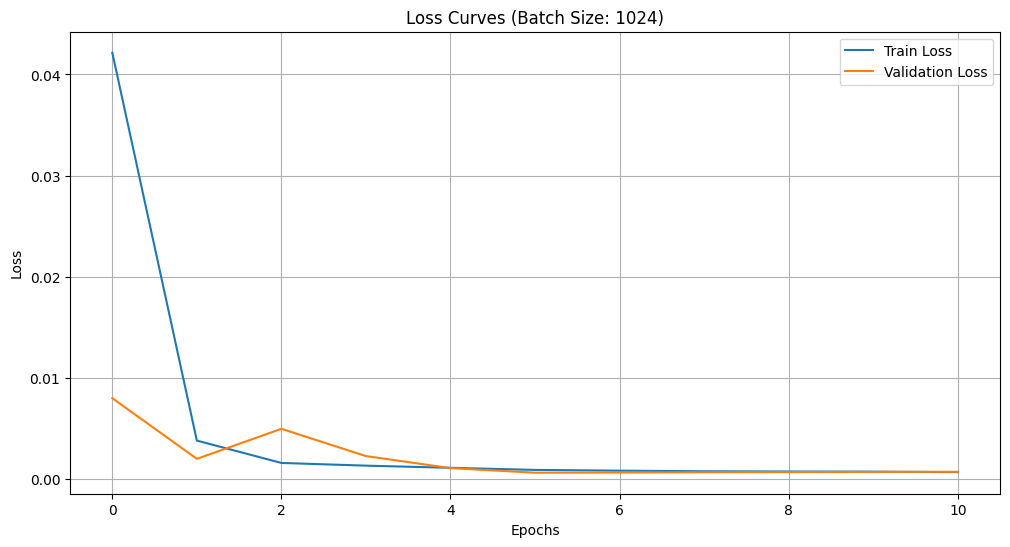

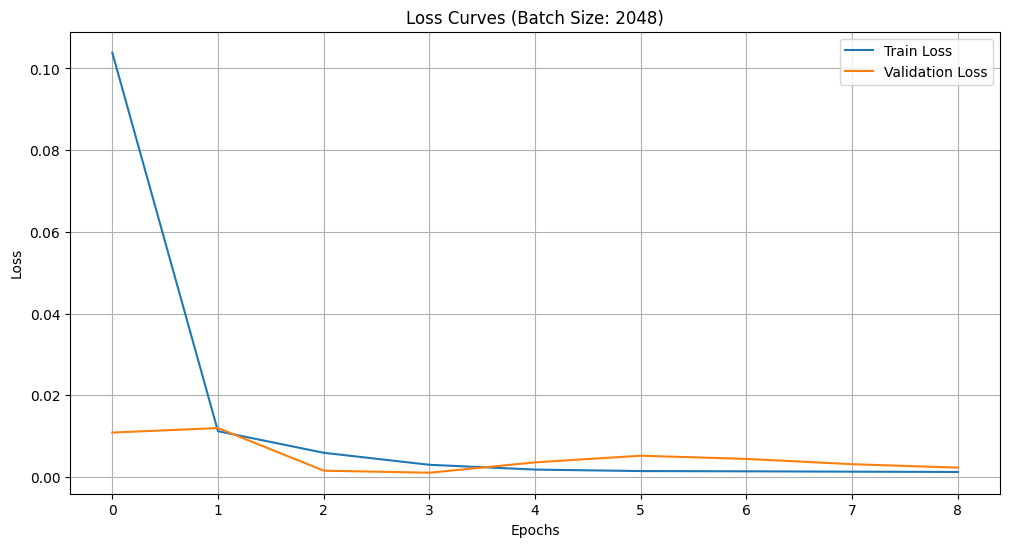

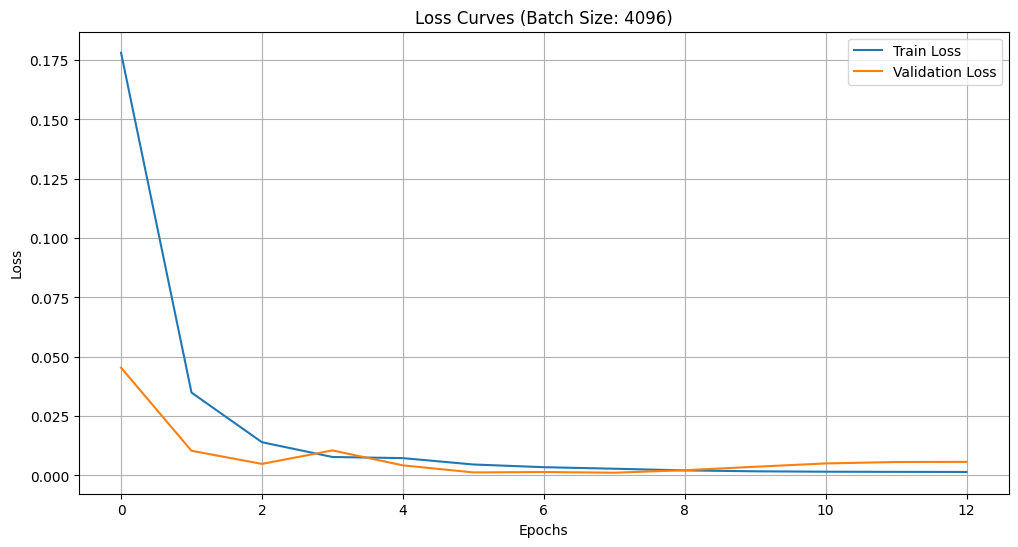

In [50]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [52]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 1024, MSE: 0.033, RMSE: 0.181, R-squared: 0.455
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Batch Size: 2048, MSE: 0.006, RMSE: 0.079, R-squared: 0.896
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Batch Size: 4096, MSE: 0.006, RMSE: 0.077, R-squared: 0.902


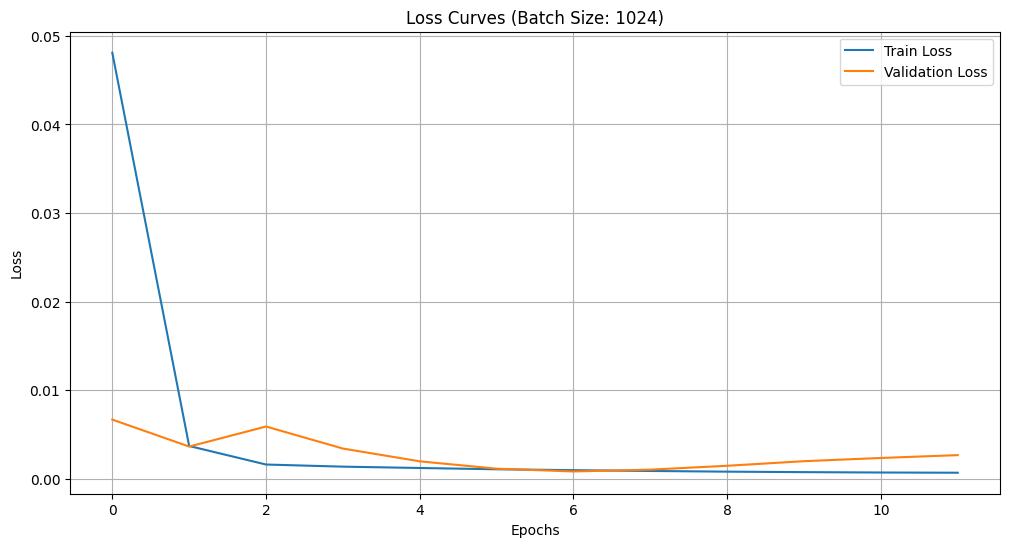

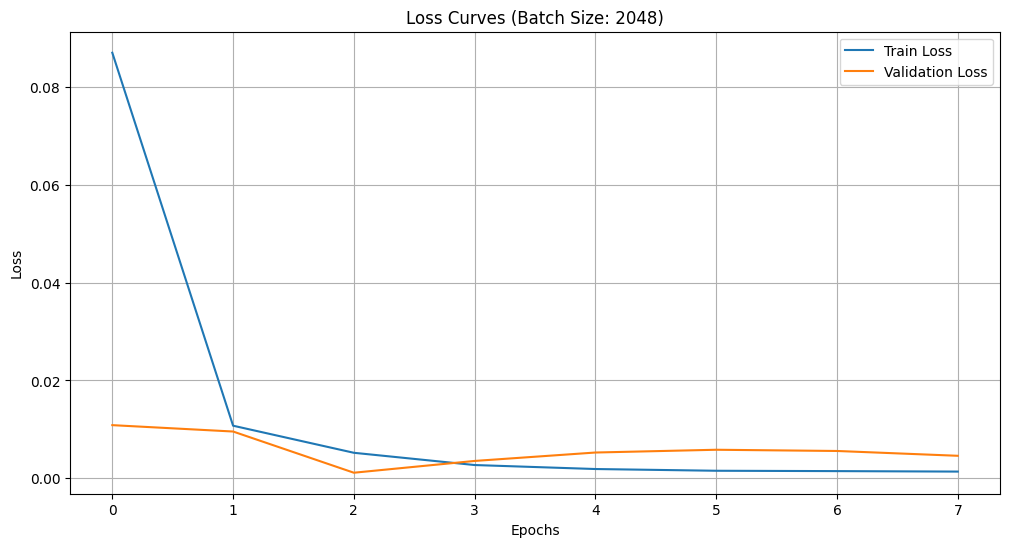

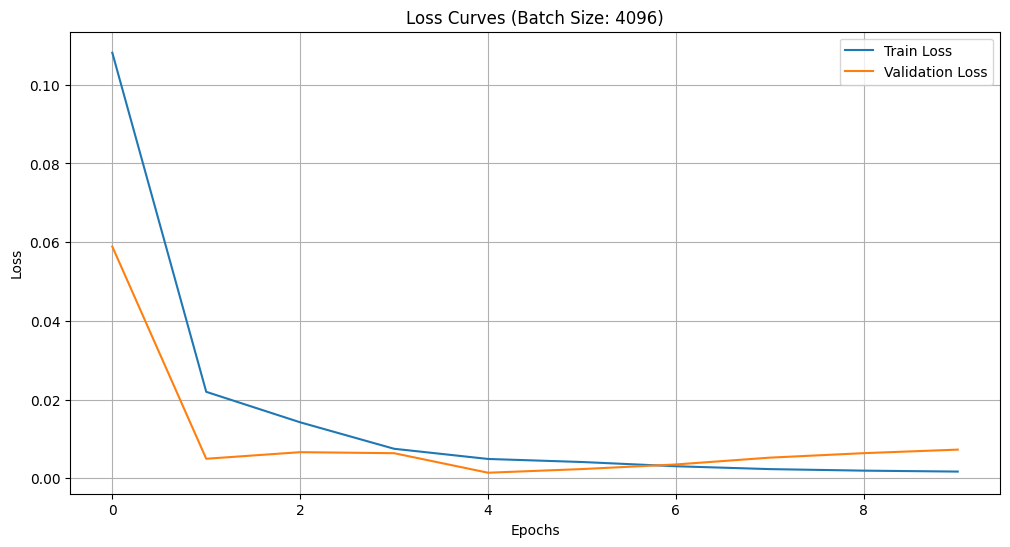

In [54]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [56]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Batch Size: 1024, MSE: 0.035, RMSE: 0.187, R-squared: 0.421
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Batch Size: 2048, MSE: 0.006, RMSE: 0.076, R-squared: 0.904
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Batch Size: 4096, MSE: 0.007, RMSE: 0.084, R-squared: 0.883


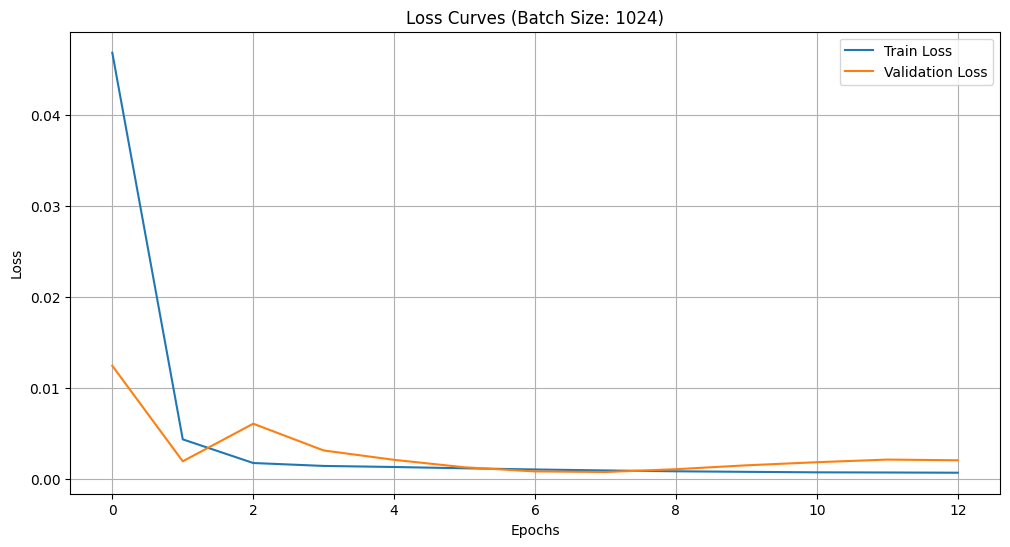

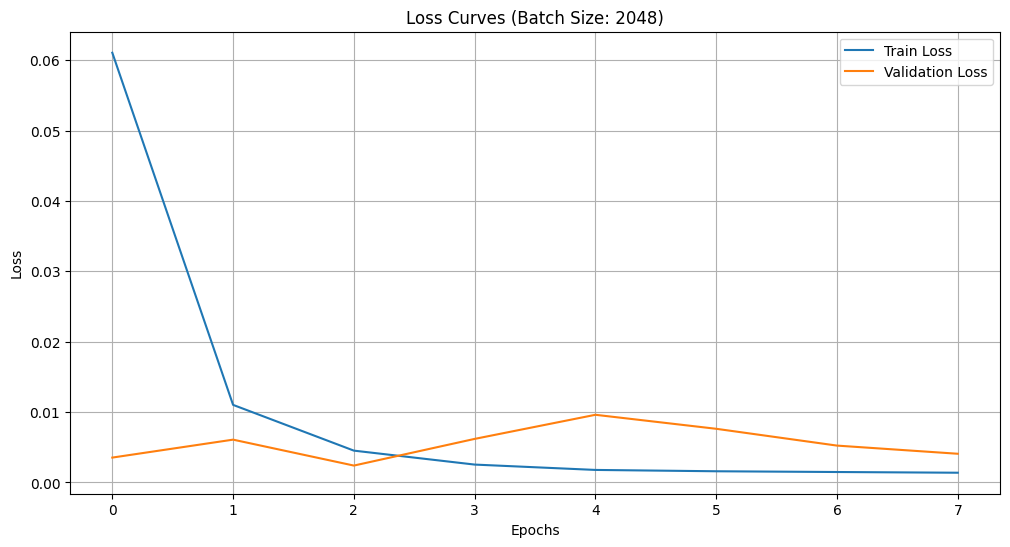

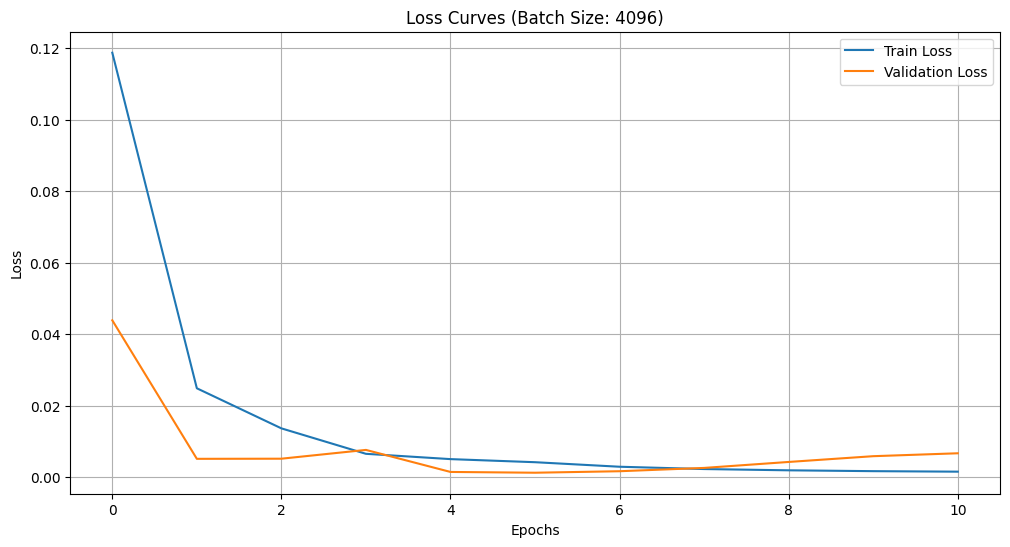

In [58]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [60]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 1024, MSE: 0.031, RMSE: 0.176, R-squared: 0.488
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Batch Size: 2048, MSE: 0.007, RMSE: 0.084, R-squared: 0.882
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Batch Size: 4096, MSE: 0.009, RMSE: 0.094, R-squared: 0.852


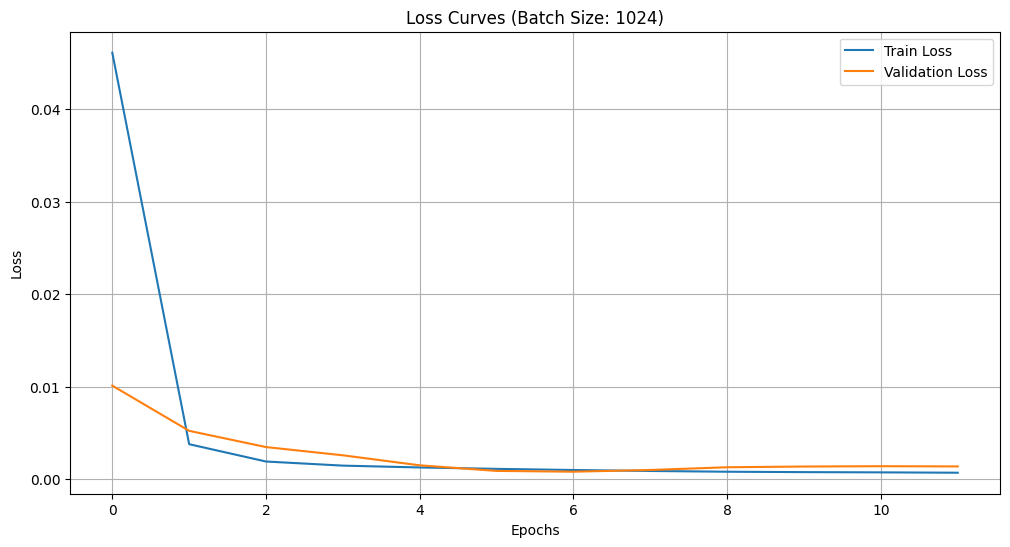

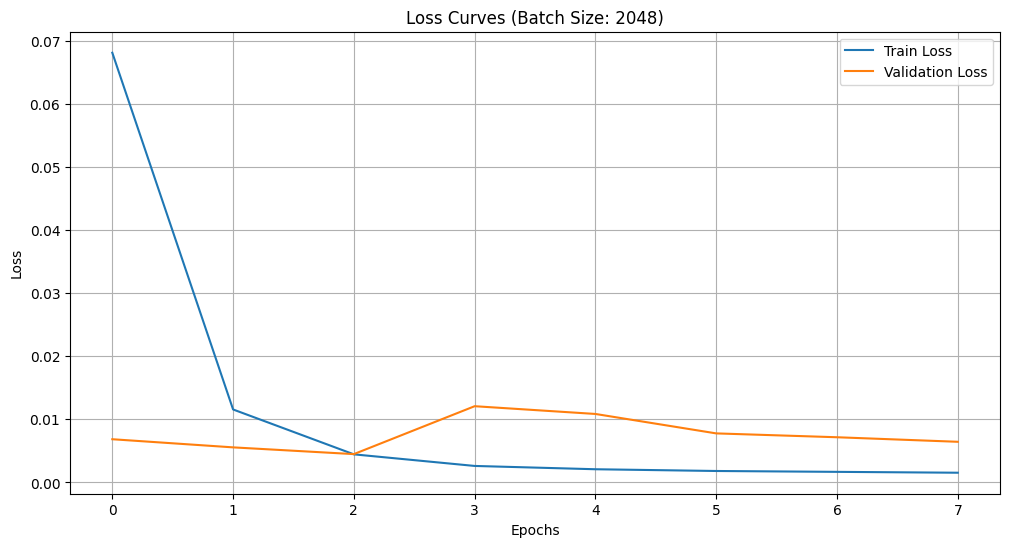

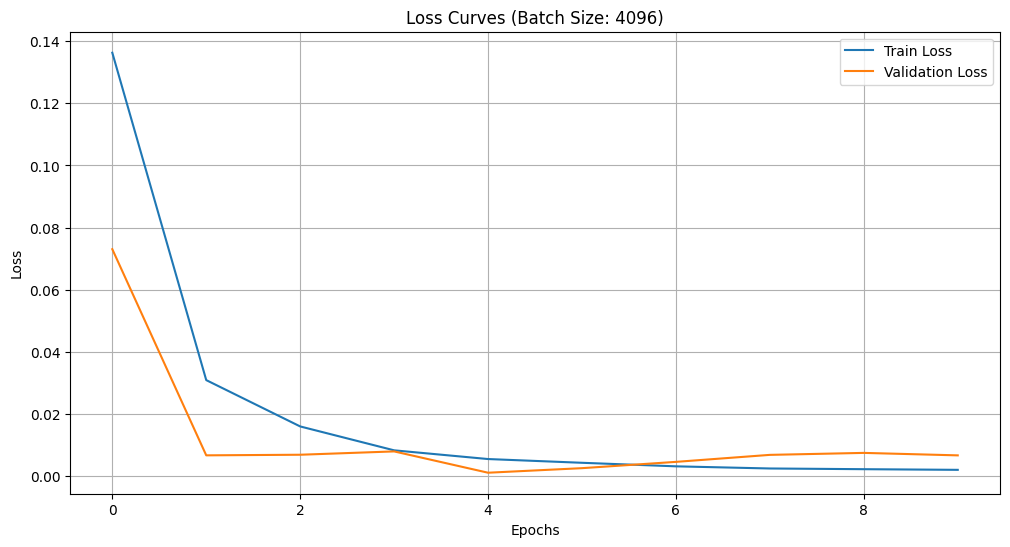

In [62]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

+ nasdaq

In [8]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 1024, MSE: 0.014, RMSE: 0.119, R-squared: 0.766
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 2048, MSE: 0.022, RMSE: 0.148, R-squared: 0.635
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 4096, MSE: 0.007, RMSE: 0.082, R-squared: 0.888


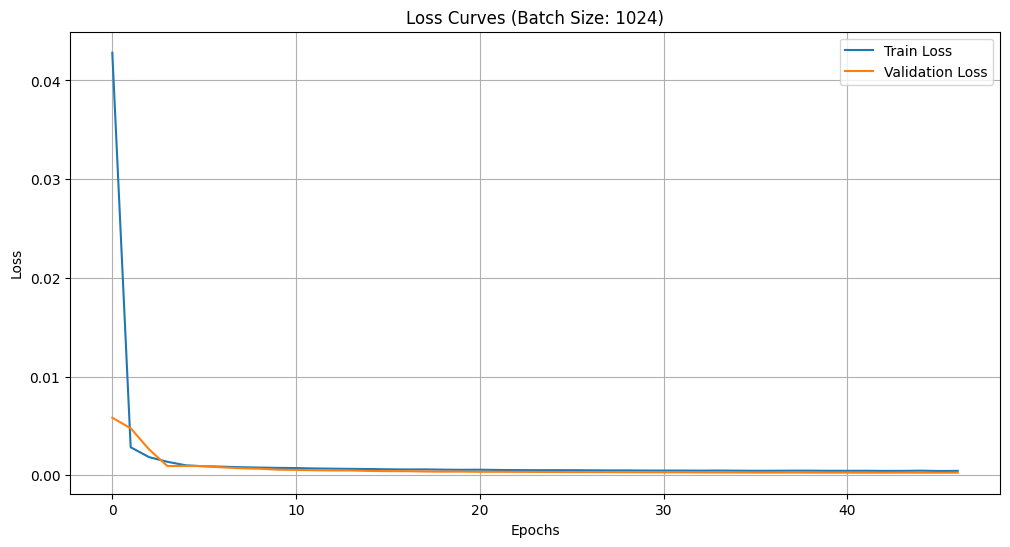

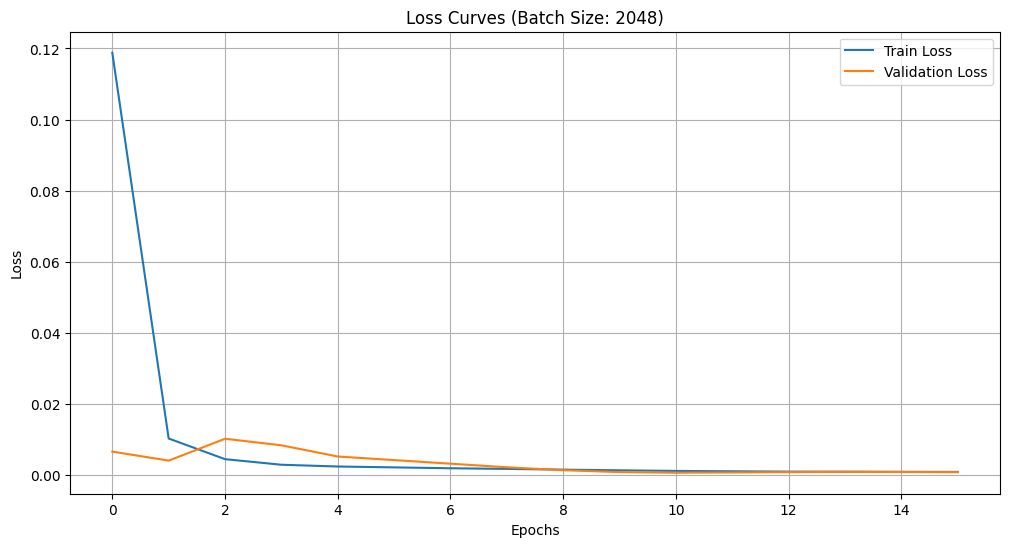

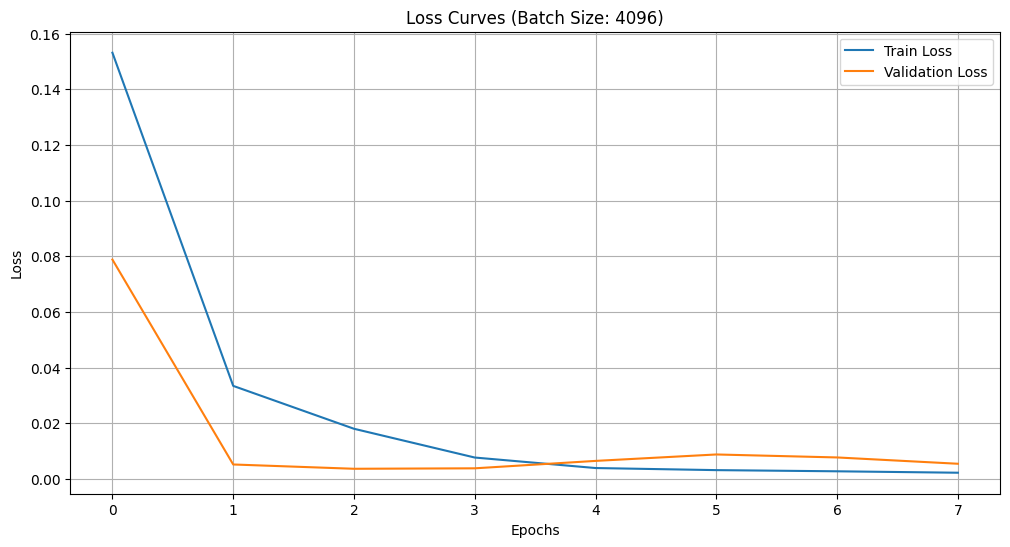

In [10]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Batch Size: 1024, MSE: 0.017, RMSE: 0.129, R-squared: 0.723
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 2048, MSE: 0.020, RMSE: 0.141, R-squared: 0.668
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 4096, MSE: 0.026, RMSE: 0.162, R-squared: 0.567


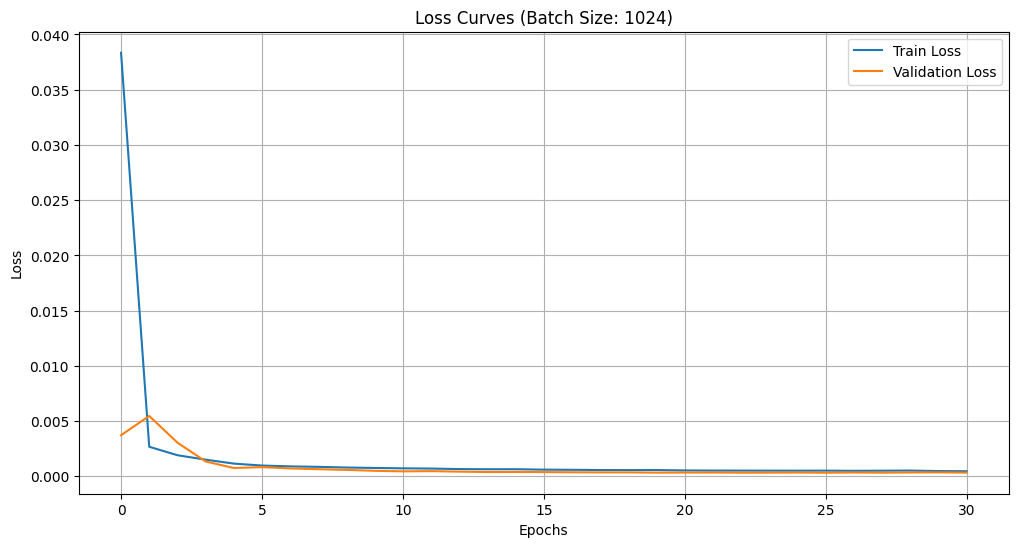

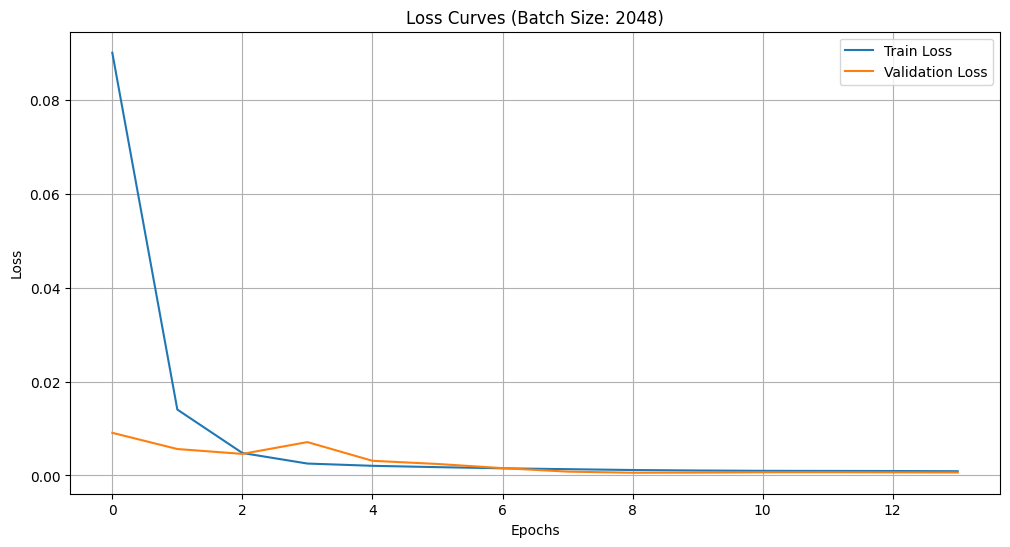

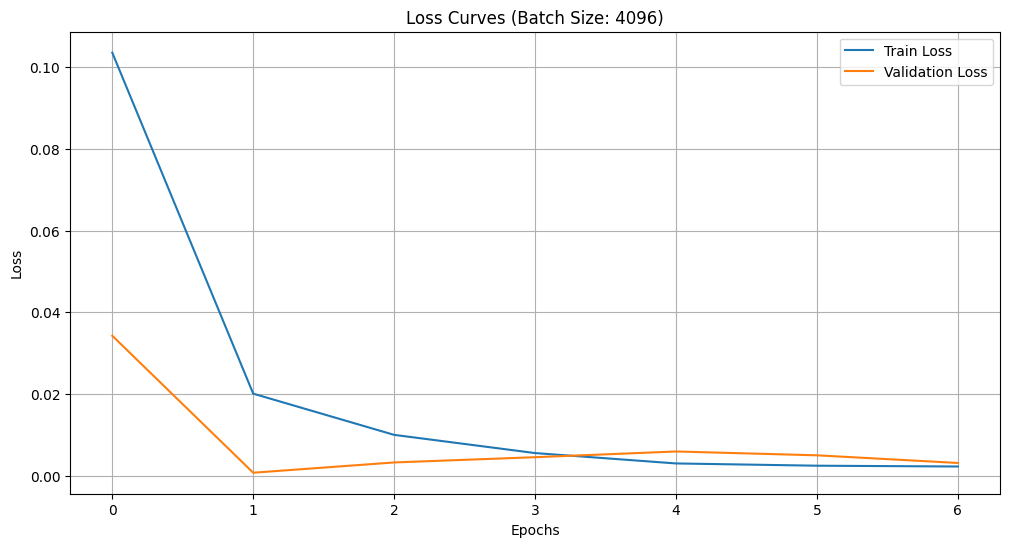

In [14]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Batch Size: 1024, MSE: 0.012, RMSE: 0.108, R-squared: 0.806
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 2048, MSE: 0.020, RMSE: 0.141, R-squared: 0.671
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 4096, MSE: 0.010, RMSE: 0.101, R-squared: 0.832


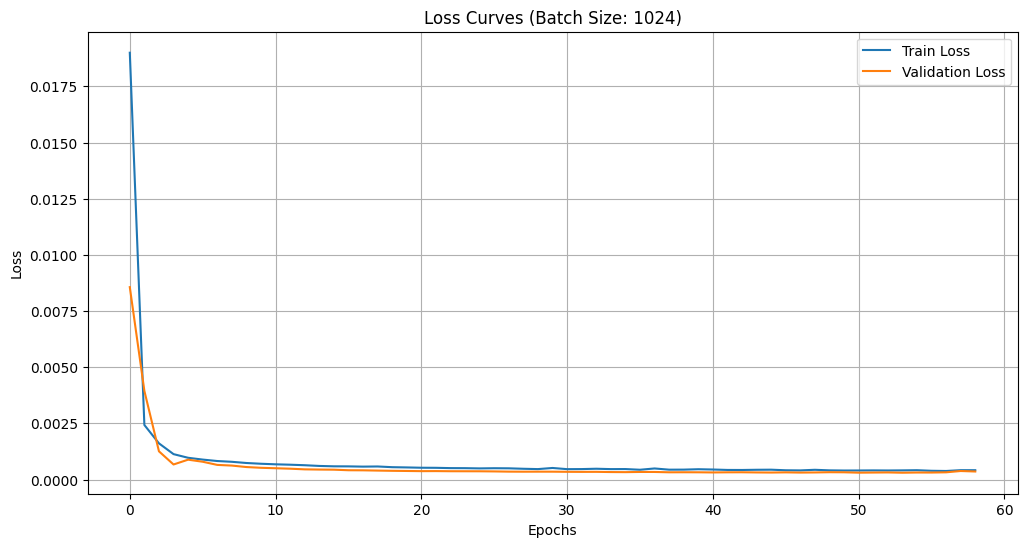

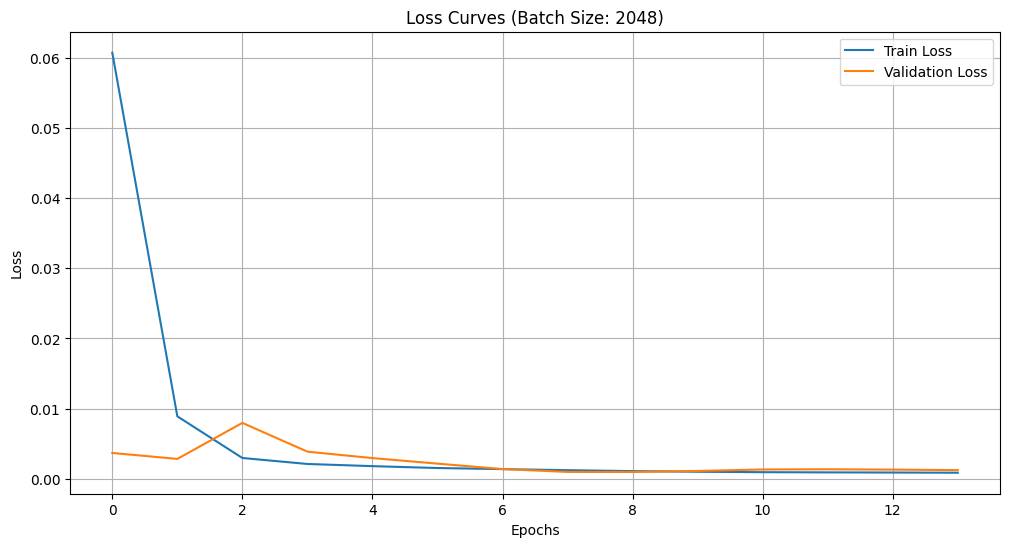

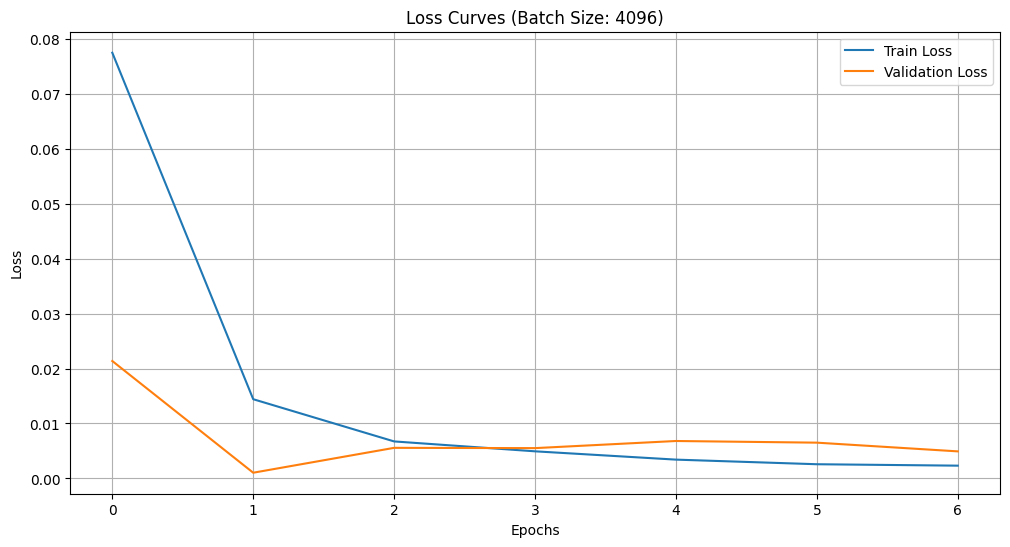

In [18]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
from sklearn.model_selection import train_test_split

past_nasdaq_roberta = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [20]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 1024, MSE: 0.029, RMSE: 0.171, R-squared: 0.518
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Batch Size: 2048, MSE: 0.010, RMSE: 0.099, R-squared: 0.838
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 4096, MSE: 0.004, RMSE: 0.060, R-squared: 0.940


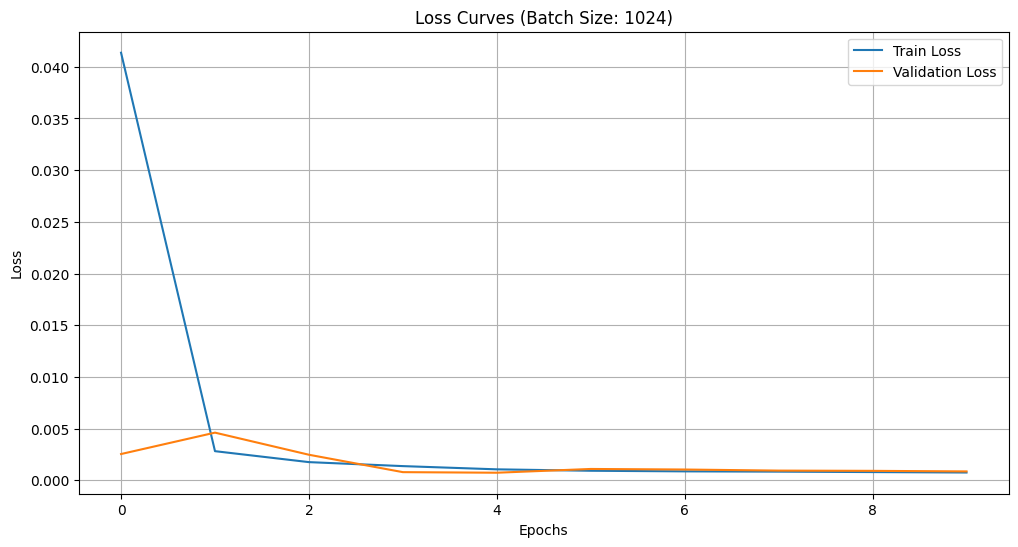

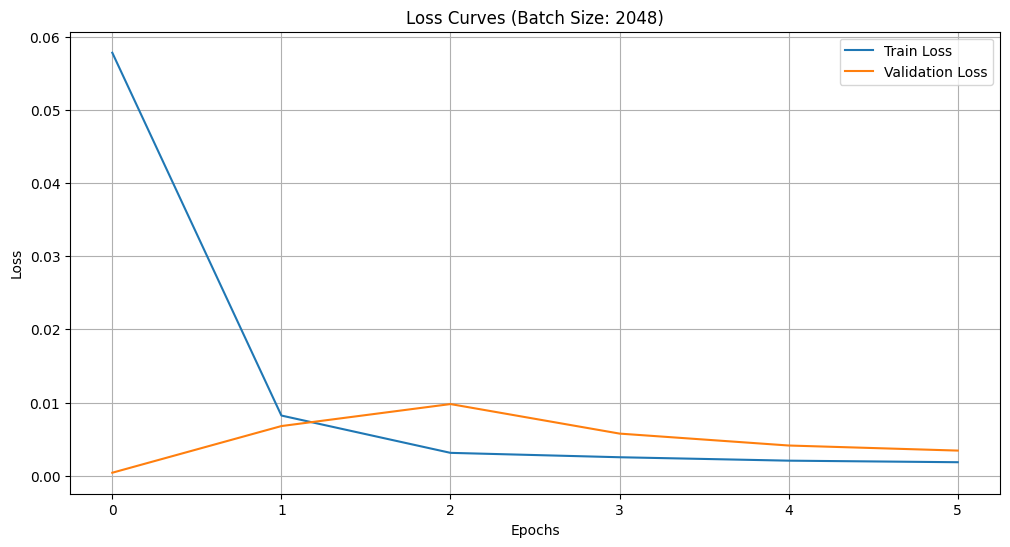

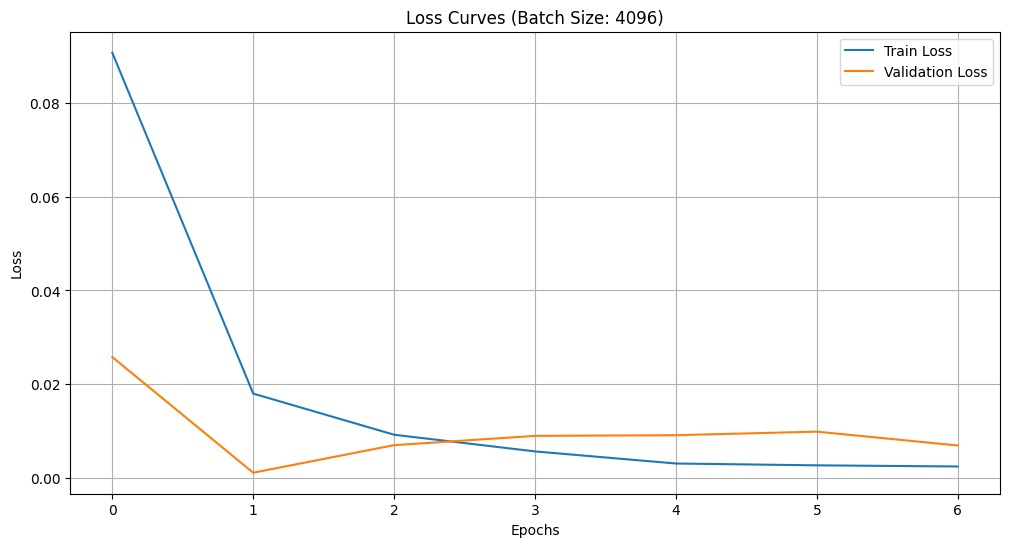

In [22]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 1024, MSE: 0.011, RMSE: 0.106, R-squared: 0.815
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 2048, MSE: 0.020, RMSE: 0.141, R-squared: 0.670
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 4096, MSE: 0.017, RMSE: 0.131, R-squared: 0.715


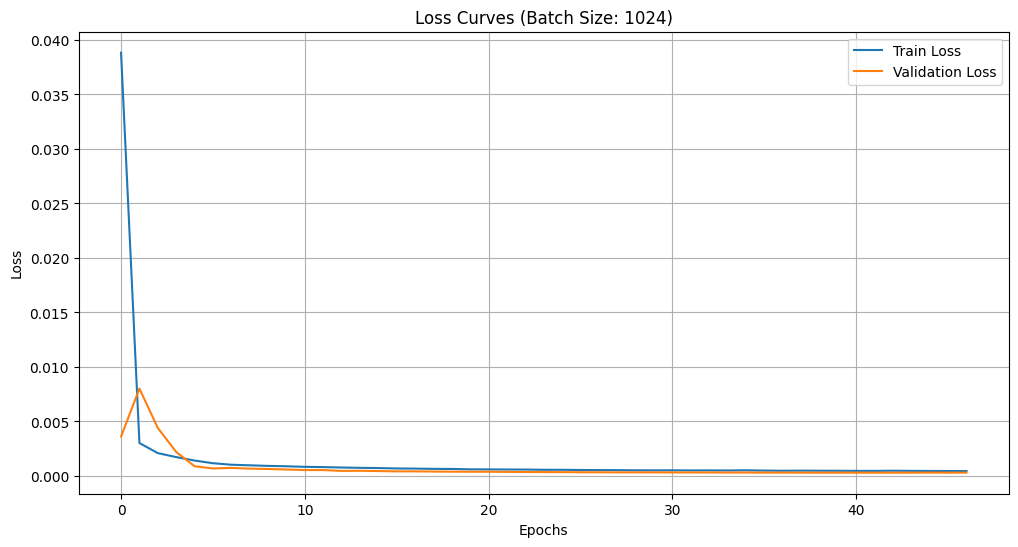

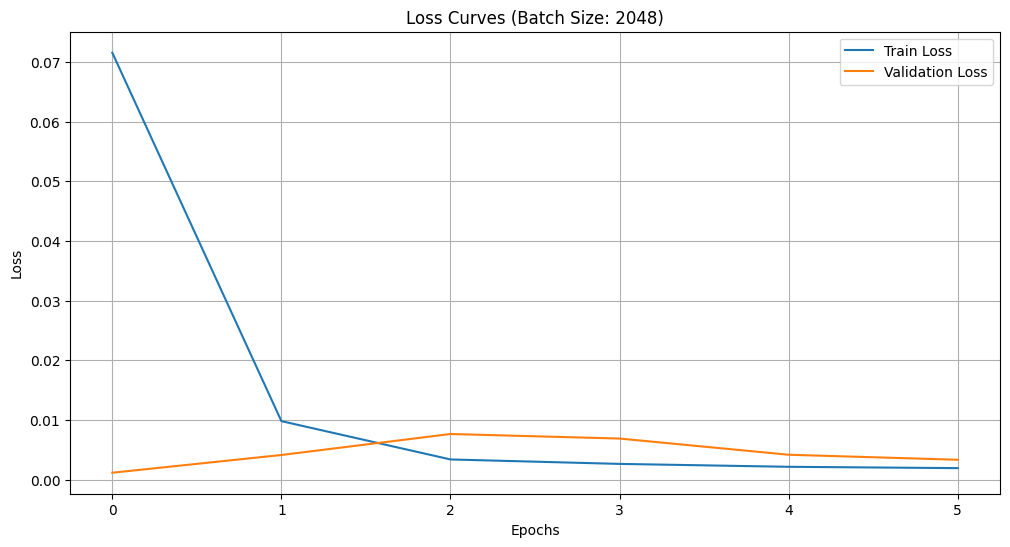

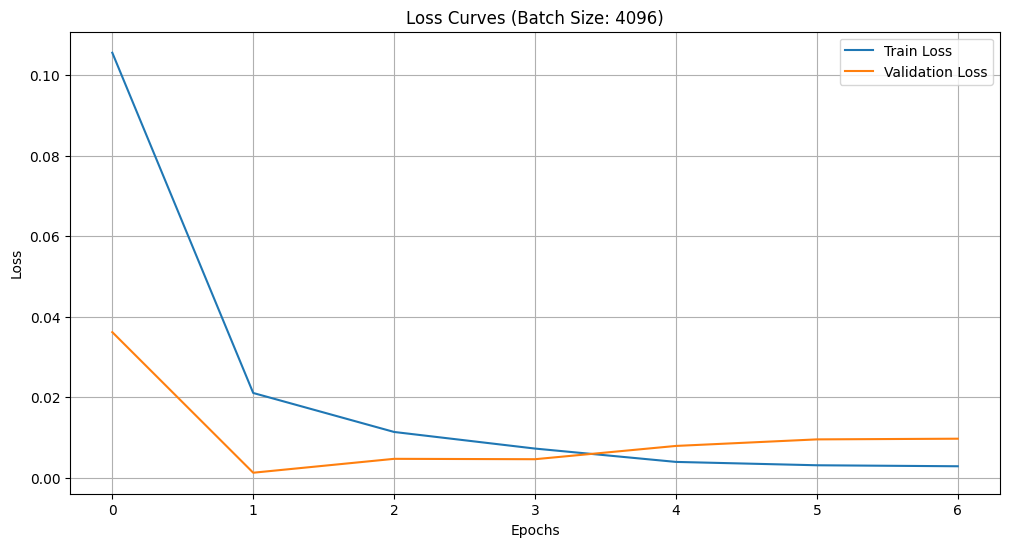

In [26]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Batch Size: 1024, MSE: 0.021, RMSE: 0.143, R-squared: 0.659
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Batch Size: 2048, MSE: 0.025, RMSE: 0.157, R-squared: 0.591
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Batch Size: 4096, MSE: 0.031, RMSE: 0.177, R-squared: 0.483


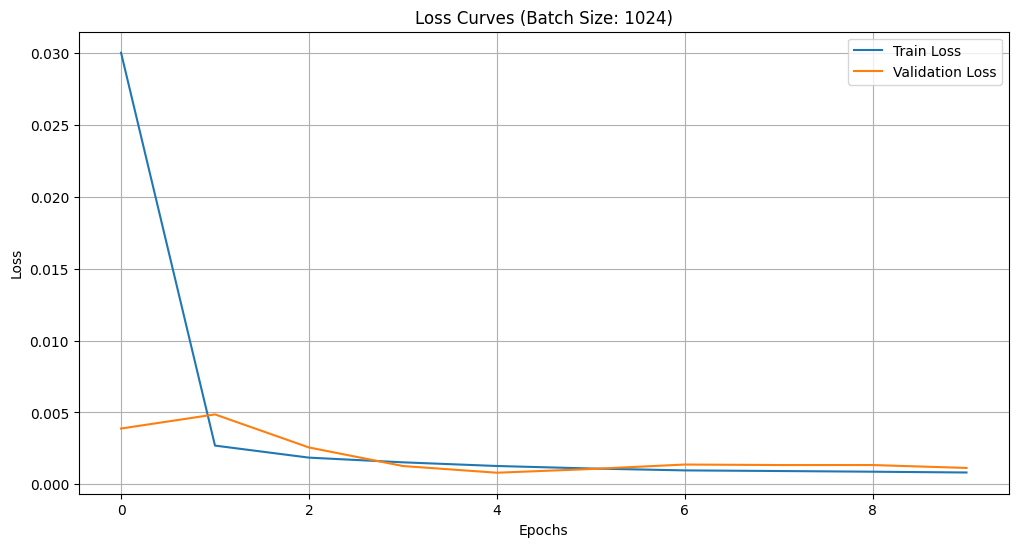

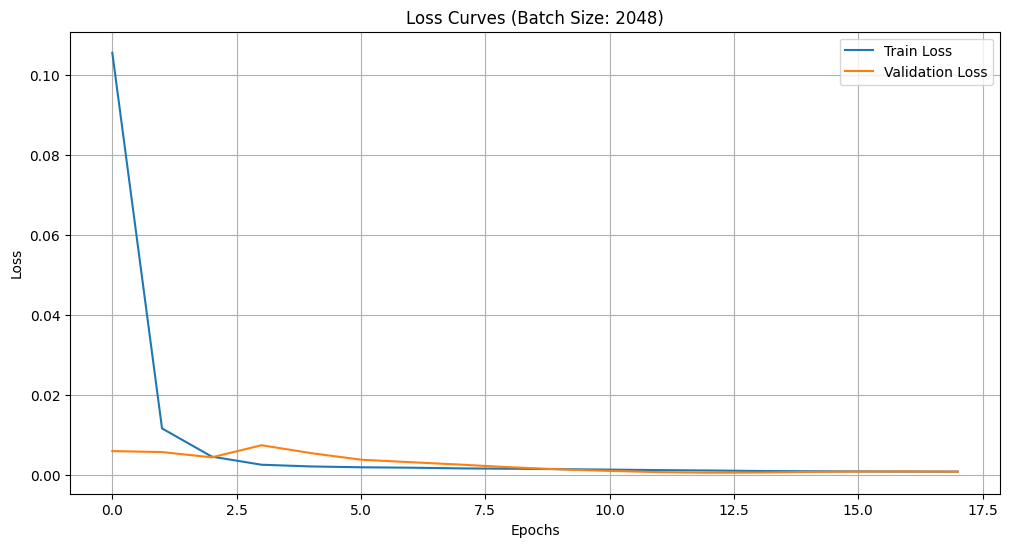

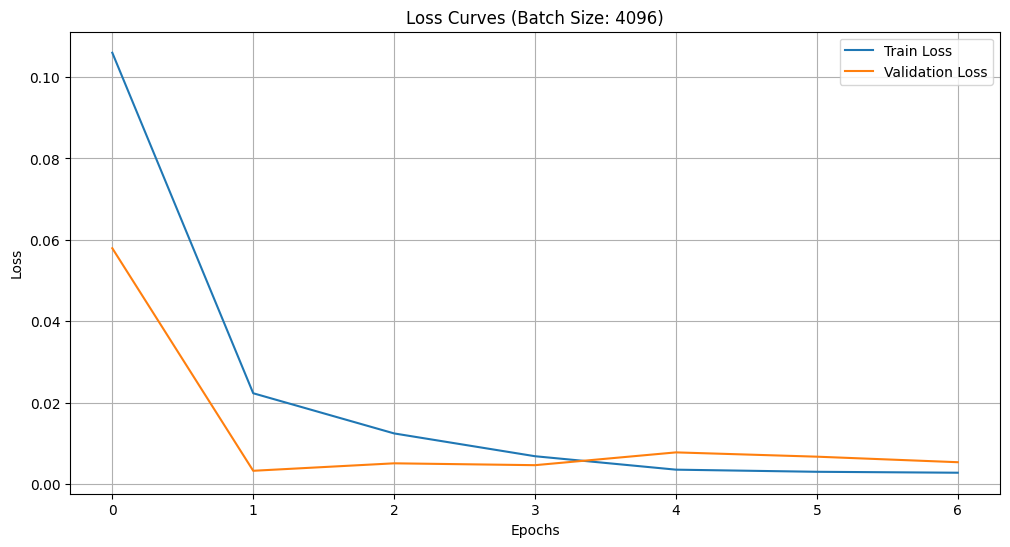

In [30]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Batch Size: 1024, MSE: 0.020, RMSE: 0.142, R-squared: 0.667
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Batch Size: 2048, MSE: 0.015, RMSE: 0.122, R-squared: 0.752
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 4096, MSE: 0.008, RMSE: 0.091, R-squared: 0.862


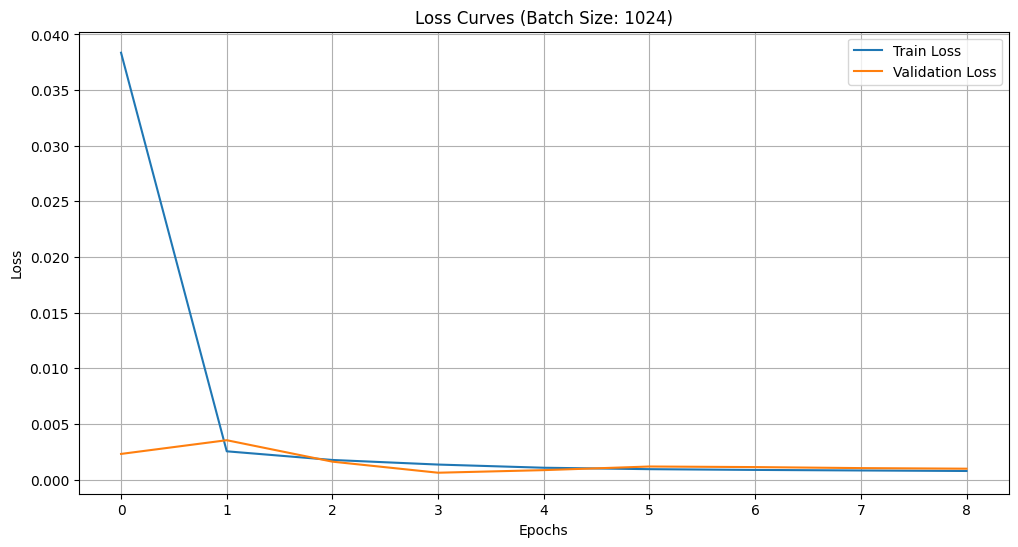

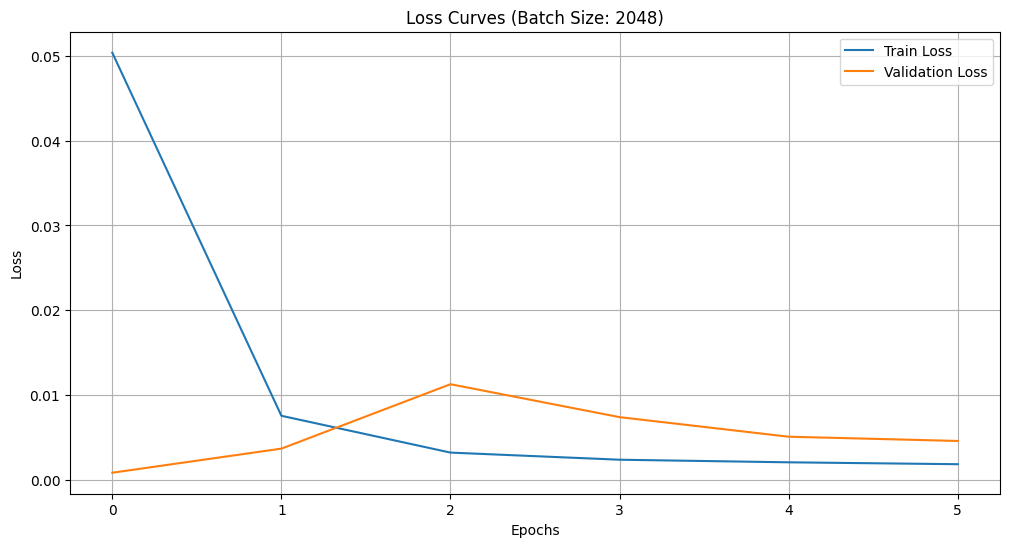

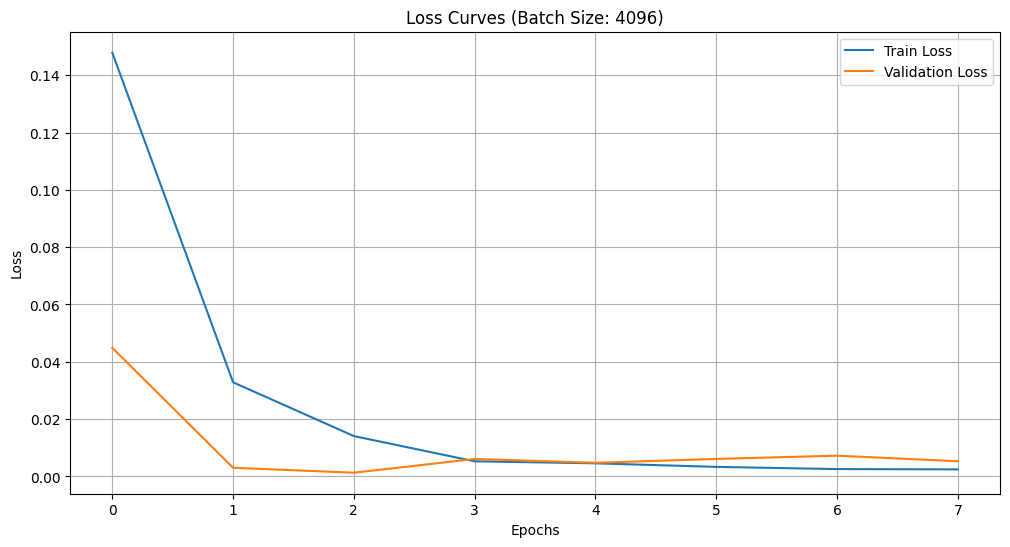

In [34]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()